<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy import stats

import copy

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [3]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy


In [4]:
import importlib

# Import your modules initially
import library.pipeline

# Reload the modules in case they were updated
importlib.reload(library.pipeline)

# Now you can import specific classes/functions
from library.pipeline.pipeline import Pipeline
from library.pipeline.pipeline_manager import PipelineManager

## Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT). Notebook-level constants should be written in the cell assigned to it (see below)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write a content index with the content included in that section (see 'feature engineering' section as an example)
- Please write paragraphs before and after each cell explain what u are about to do and the conclusions, correspondingly. Do not assume they are too obvious.
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)
- Ideally, add a "Questions" and "Things to be done" section in each major sections where u write about futher iterations u want to do (while sharing in with the rest)


## Set-up

In [5]:
dataset_path ="./dataset/dynamic_dataset.csv"
results_path = "results/results.csv"

In [6]:
metrics_to_evaluate = ["accuracy", "precision", "recall", "f1-score"]

We start off with a pipeline for all the models. Then at some moment, whenever we think the pipelines will diverge, we remove the by-object-refrence (that we will create in the next cell), and create a new copy with our modifications ready.

In [7]:
default_pipeline = ensembled_pipeline = tree_pipeline = linear_pipeline = baseline_pipeline = example = Pipeline(
                        dataset_path=dataset_path, 
                        results_path=results_path,
                        model_type="classification",
                        metrics_to_evaluate=metrics_to_evaluate)

In [8]:
pipelines = {
            "models": {
                  "ensembled": ensembled_pipeline,
                  "tree-based": tree_pipeline,
                  "linear": linear_pipeline,
                  }, 
            "baseline": {
                  "logistic": baseline_pipeline, 
                  "example":  example               
            }
}
pipeline_manager = PipelineManager(pipelines)

Here I show an example of how we will be working with by-object-reference.

In [9]:
baseline_pipeline.dataset.example_attribute = "1"

In [10]:
default_pipeline.dataset.example_attribute

'1'

However, if we do a (deep) copy:
Note that the difference between a deep and a shallow copy is that the former copies all the objects that are inside the class. We need that.
We will overwrite the prior attribute and show is this is not propagated to the other results anymore

In [11]:
new_pipeline = copy.deepcopy(default_pipeline)
new_pipeline.dataset.example_attribute = "2"

In [12]:
default_pipeline.dataset.example_attribute

'1'

It may also be of interest for you to propagate the same method's invokation to all the pipelines within the pipeline manager. For instance, after a divergence in, lets say, feature scaling, you may need to fit all the models in the corresponding pipelines. You would want to avoid reduntandly calling the same method with the same parameters for all the Pipeline class instances. In order to do so, we present an example that avoids such annoyance

In [13]:
pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="example", print_results=True)

Pipeline example in category baseline has diverged
 Pipeline schema is now: {'models': {'ensembled': <library.pipeline.pipeline.Pipeline object at 0x325488550>, 'tree-based': <library.pipeline.pipeline.Pipeline object at 0x325488550>, 'linear': <library.pipeline.pipeline.Pipeline object at 0x325488550>}, 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline object at 0x325488550>, 'example': <library.pipeline.pipeline.Pipeline object at 0x323cd2f10>}}


In [14]:
pipeline_manager.pipelines["baseline"]["example"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd")

Whats goooddd from 13512946640. You are at automatic feature selection!


In [15]:
pipeline_manager.all_pipelines_execute(methodName="speak", message="Hello, world!")

Hello, world! from 13510411600
Hello, world! from 13485551376


{'models': {'ensembled': None}, 'baseline': {'example': None}}

A method present deeper down the class:

Instead of doing:
'pipeline_manager.pipelines["baseline"]["logistic"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd") for all objects'

we can do:

In [16]:
pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_selection.automatic_feature_selection.speak", message="Whats good")

Whats good from 13510412368. You are at automatic feature selection!Whats good from 13512946640. You are at automatic feature selection!



{'models': {'ensembled': None}, 'baseline': {'example': None}}

In [17]:
# lets delete the example obj
del new_pipeline 
del pipeline_manager.pipelines["baseline"]["example"]

In [18]:
pipeline_manager.pipelines

{'models': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x325488550>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x325488550>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x325488550>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x325488550>}}

<hr>

# Start Of The Pipeline

In [19]:
default_pipeline.dataset.df.rename(columns={"reboot": "Reboot"}, inplace=True) # consistency with other features' names
default_pipeline.dataset.df.drop(columns=["Family", "Hash"], inplace=True) # We have decided to use only category as target variable; Hash is temporary while im debugging (it will be deleted in EDA)

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them.
Please access this document for a complete problem context description: https://docs.google.com/document/d/1yH9gvnJVSH9GLv9ATQ5JQWA2z8Jy4umxxRfMF-y2fiU/edit?usp=sharing

# 1. EDA

This section below shall be deleted

In [20]:
default_pipeline.preprocessing.remove_duplicates()

No duplicates found in the dataset


In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

## Initial Exploration

In [21]:
default_pipeline.dataset.df.head()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Category,Reboot
0,31053,2448,14044,23472,74824,2452,0,8919,4786,4132,...,0,2399,1635,2351,3285,1551,11221,193,Trojan_SMS,before
1,107787,21976,11852,74548,69052,23152,0,25341,20965,4375,...,0,2226,1816,826,1544,2045,8457,189,Trojan_SMS,before
2,86584,18460,12284,59992,91548,19376,0,24500,21378,3121,...,1,746,2244,3406,1565,2819,10780,195,Trojan_SMS,before
3,41248,924,10328,36280,55768,928,0,10082,7281,2800,...,0,1937,974,4134,3138,1556,11739,191,Trojan_SMS,before
4,38621,5080,12392,27388,71048,5088,0,9077,5750,3326,...,0,1510,936,2298,3752,1992,10488,188,Trojan_SMS,before


In [22]:
import re

all_columns = default_pipeline.dataset.df.columns.tolist()

underscore_columns = [col for col in all_columns if '_' in col]

prefix_groups = {}
for col in underscore_columns:
    prefix = col.split('_')[0]
    if prefix not in prefix_groups:
        prefix_groups[prefix] = []
    prefix_groups[prefix].append(col)

for prefix, columns in prefix_groups.items():
    print(f"\n{prefix} ({len(columns)} features):")
    print(", ".join(columns))
    
prefix_counts = {prefix: len(columns) for prefix, columns in prefix_groups.items()}
prefix_counts_df = pd.DataFrame(list(prefix_counts.items()), columns=['Prefix', 'Count'])
prefix_counts_df = prefix_counts_df.sort_values('Count', ascending=False)

display(prefix_counts_df)



Memory (23 features):
Memory_PssTotal, Memory_PssClean, Memory_SharedDirty, Memory_PrivateDirty, Memory_SharedClean, Memory_PrivateClean, Memory_SwapPssDirty, Memory_HeapSize, Memory_HeapAlloc, Memory_HeapFree, Memory_Views, Memory_ViewRootImpl, Memory_AppContexts, Memory_Activities, Memory_Assets, Memory_AssetManagers, Memory_LocalBinders, Memory_ProxyBinders, Memory_ParcelMemory, Memory_ParcelCount, Memory_DeathRecipients, Memory_OpenSSLSockets, Memory_WebViews

API (105 features):
API_Process_android.os.Process_start, API_Process_android.app.ActivityManager_killBackgroundProcesses, API_Process_android.os.Process_killProcess, API_Command_java.lang.Runtime_exec, API_Command_java.lang.ProcessBuilder_start, API_JavaNativeInterface_java.lang.Runtime_loadLibrary, API_JavaNativeInterface_java.lang.Runtime_load, API_WebView_android.webkit.WebView_loadUrl, API_WebView_android.webkit.WebView_loadData, API_WebView_android.webkit.WebView_loadDataWithBaseURL, API_WebView_android.webkit.WebView_

,Prefix,Count
1,API,105
0,Memory,23
4,Logcat,6
2,Network,4
3,Battery,2
5,Process,1


In [23]:
default_pipeline.dataset.df.shape

(53439, 143)

In [24]:
default_pipeline.preprocessing.get_missing_values()

No missing values found in the dataset


## Basic Analysis of Category

In [25]:
default_pipeline.dataset.df['Category'].unique()

array(['Trojan_SMS', 'Scareware', 'Adware', 'Trojan_Banker',
       'FileInfector', 'No_Category', 'Ransomware', 'Backdoor',
       'Trojan_Dropper', 'Riskware', 'Zero_Day', 'Trojan', 'Trojan_Spy',
       'PUA'], dtype=object)

In [26]:
default_pipeline.dataset.df['Category'].value_counts()

Category
Riskware          14053
Adware            10980
Trojan             8437
Zero_Day           4475
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
No_Category        1932
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

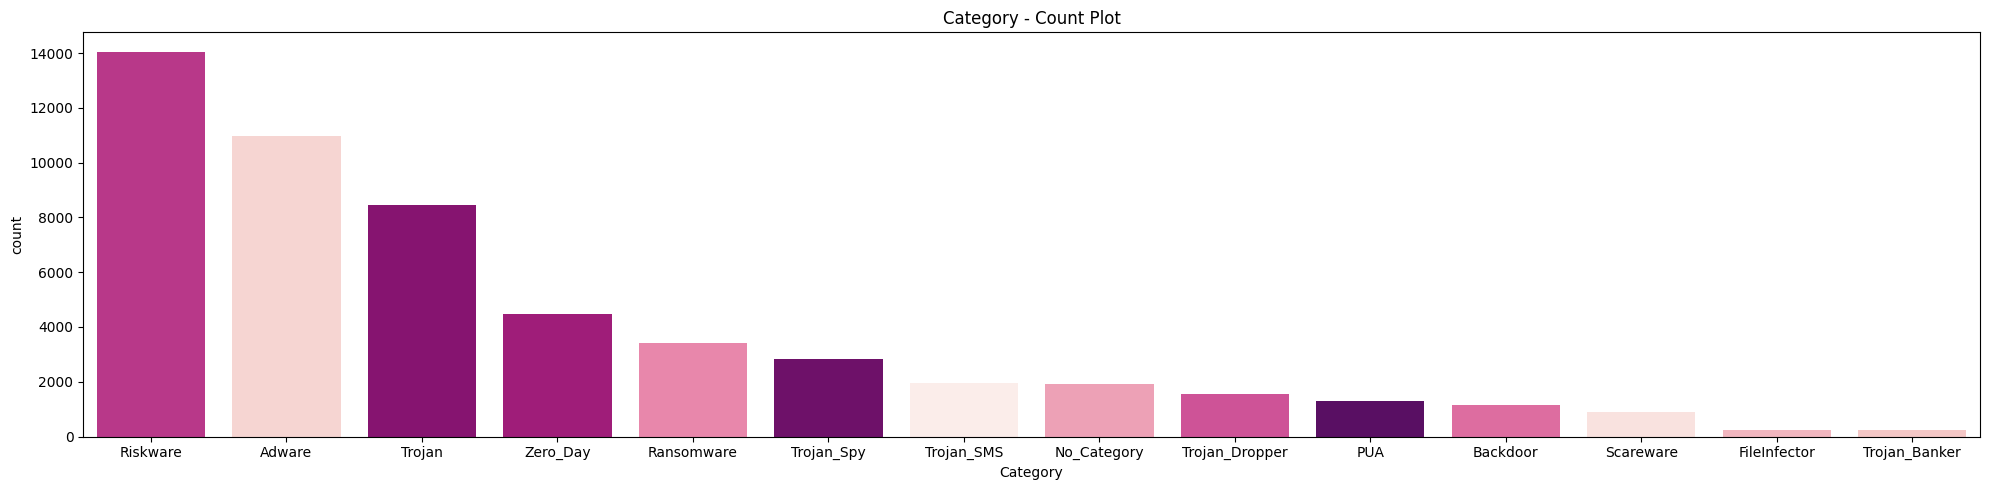

In [27]:
default_pipeline.EDA.plot_categorical_distributions(features=["Category"], n_cols=1, sorted = True)

## Data Type Distribution

In [28]:
# # Plotting the frequency of data types
# type_counts.plot(kind='bar', color='skyblue')

# # Add title and labels
# plt.title('Frequency of Data Types in DataFrame')
# plt.xlabel('Data Type')
# plt.ylabel('Frequency')

In [29]:
default_pipeline.dataset.df.dtypes.value_counts()

int64     141
object      2
Name: count, dtype: int64

We can see that most columns are numerical. Lets gets to see which are the variables that are of type object.

In [30]:
default_pipeline.dataset.df.select_dtypes(include=["object"]).columns

Index(['Category', 'Reboot'], dtype='object')

In [31]:
df = default_pipeline.dataset.df

## Network

In [32]:
network_columns = [col for col in default_pipeline.dataset.df.columns if col.startswith("Network_")]

for col in network_columns:
    print(f"{col}")

columns_to_display = network_columns + ['Reboot']
display(default_pipeline.dataset.df[columns_to_display].head(20))

Network_TotalReceivedBytes
Network_TotalReceivedPackets
Network_TotalTransmittedBytes
Network_TotalTransmittedPackets


,Network_TotalReceivedBytes,Network_TotalReceivedPackets,Network_TotalTransmittedBytes,Network_TotalTransmittedPackets,Reboot
0,0,0,0,0,before
1,12530,36,4595,42,before
2,157452,218,33555,233,before
3,0,0,0,0,before
4,0,0,0,0,before
5,118859,101,4565,73,before
6,0,0,0,0,before
7,0,0,0,0,before
8,8050,37,4585,60,before
9,0,0,0,0,before


A packet is a unit of data transmitted over a network. Each packet includes the data called payload (data from the web, packets from streaming, messaging or downloading files or any data downloaded/uploaded in the device), and metadata (like headers).

A byte is used to measure data size. A single character like 'A' takes 1 byte (8 bits). 

Packets do not have a fixed size, but there are limits and conventions that control how large they can be depending on the network protocol.

Features

Network_TotalReceivedBytes: total bytes received over the Network.

Network_TotalReceivedPackets: total network packets received.

Network_TotalTransmittedBytes: total bytes transmitted over the network. 

Network_TotalTransmittedPackets: total network packets transmitted. 

#### Network_TotalReceivedBytes

In [33]:
df["Network_TotalReceivedBytes"].describe()

count    5.343900e+04
mean     1.036051e+06
std      1.065564e+07
min      0.000000e+00
25%      0.000000e+00
50%      1.278000e+03
75%      1.212400e+04
max      2.320056e+08
Name: Network_TotalReceivedBytes, dtype: float64

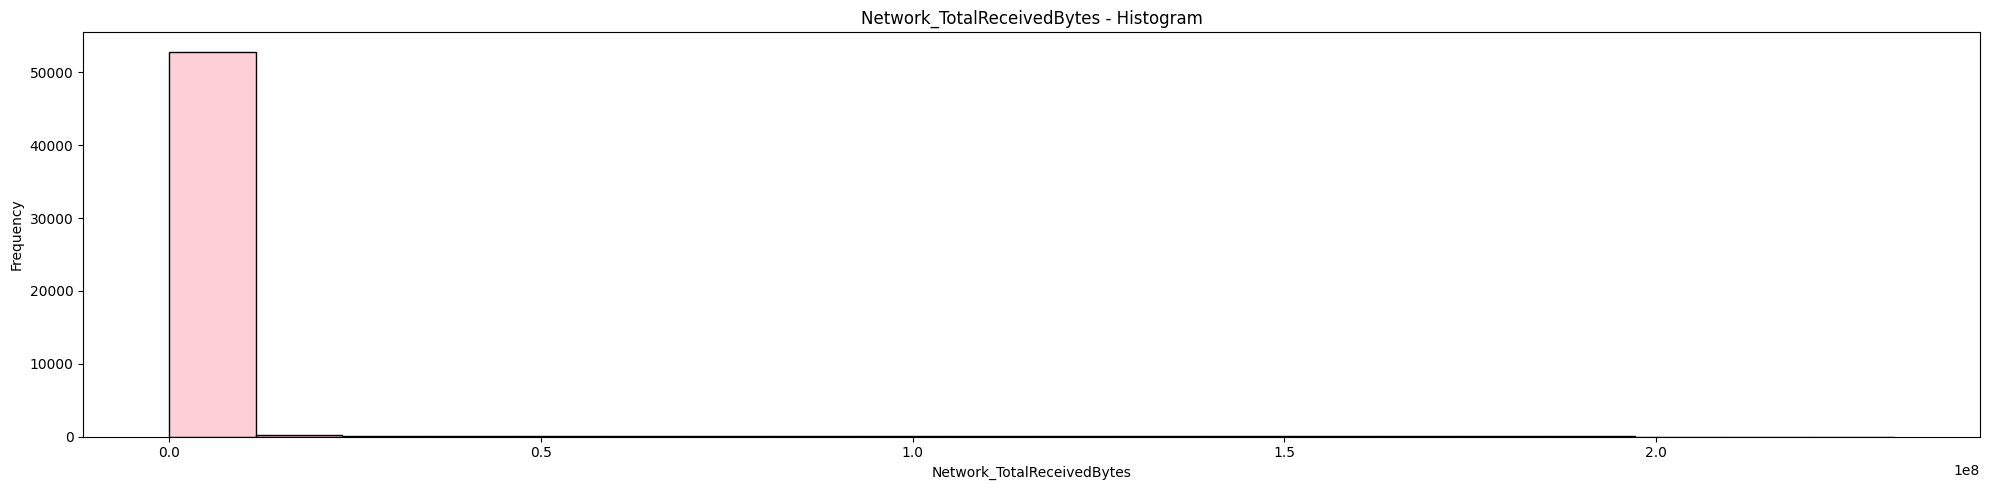

In [34]:
default_pipeline.EDA.plot_histograms(features=["Network_TotalReceivedBytes"], n_cols=1, bins=20)

Concentrate on outliers 

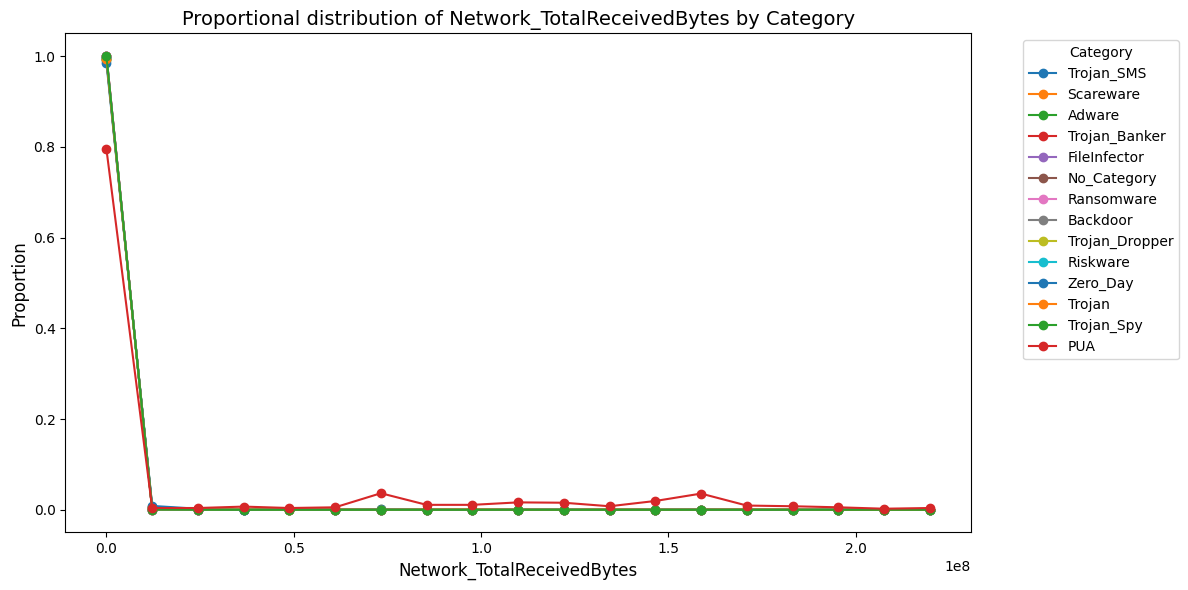

In [35]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalReceivedBytes",
    category_column="Category"
)

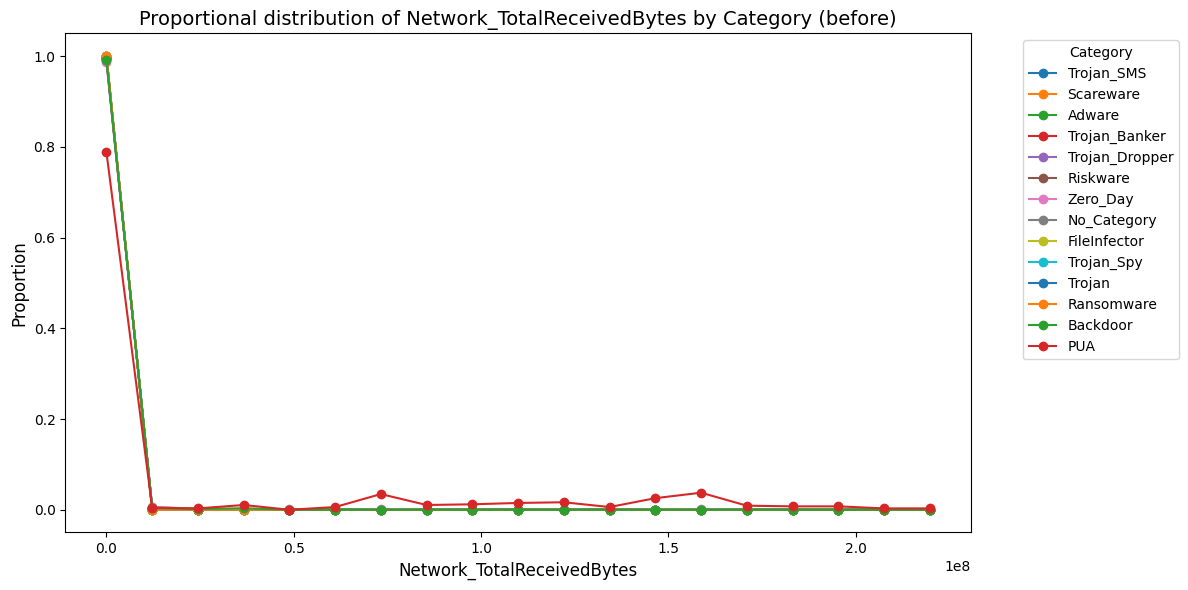

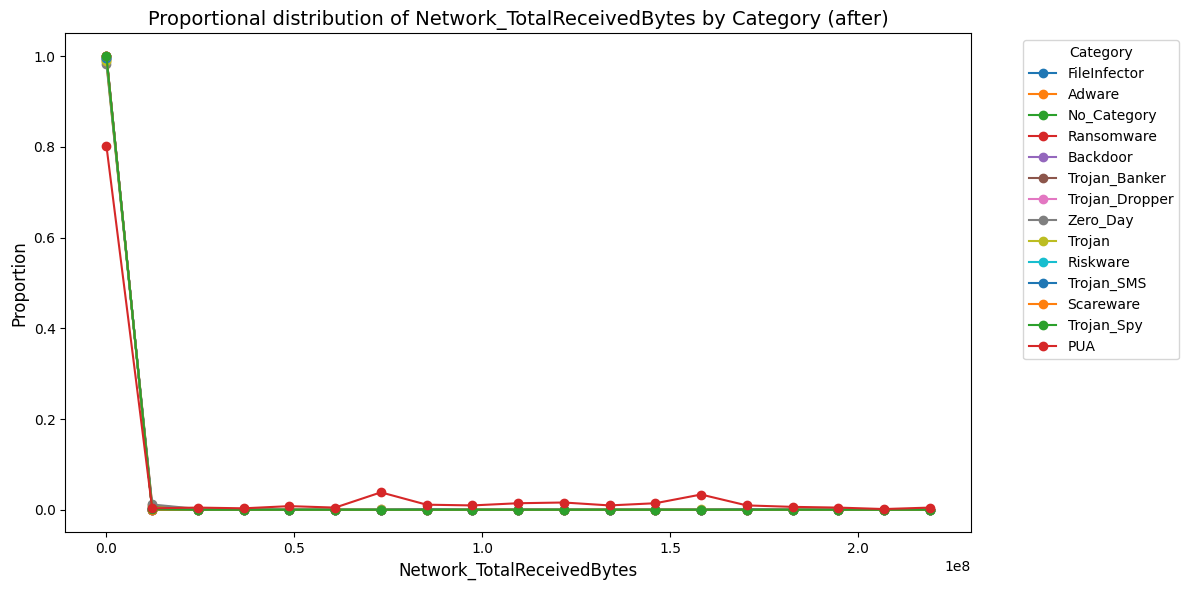

In [36]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalReceivedBytes",
    category_column="Category",
    by_reboot = True
)

In [37]:
df.groupby('Category')['Network_TotalReceivedBytes'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,4.298098e+05,2.253845e+06,0.0,0.0,2115.0,41648.00,72764982.0
Backdoor,1137.0,3.021029e+05,2.552046e+06,0.0,0.0,1124.0,12588.00,48017860.0
FileInfector,248.0,4.377719e+05,1.011675e+06,0.0,0.0,0.0,25627.75,5276554.0
No_Category,1932.0,2.894501e+05,1.437700e+06,0.0,0.0,1244.0,30636.50,23103441.0
PUA,1290.0,2.584931e+07,5.491832e+07,0.0,0.0,2664.0,1209355.75,232005650.0
Ransomware,3411.0,1.663876e+04,2.692598e+05,0.0,0.0,0.0,0.00,9761687.0
Riskware,14053.0,2.859320e+05,3.877343e+06,0.0,124.0,2060.0,12283.00,195896075.0
Scareware,886.0,3.243440e+05,9.479915e+05,0.0,0.0,0.0,70.00,9945086.0
Trojan,8437.0,7.624251e+05,9.572299e+06,0.0,0.0,2612.0,7820.00,228453520.0


#### Network_TotalTransmittedBytes

In [38]:
df["Network_TotalTransmittedBytes"].describe()

count    5.343900e+04
mean     3.136361e+04
std      1.626149e+05
min      0.000000e+00
25%      0.000000e+00
50%      3.429000e+03
75%      1.626300e+04
max      5.826047e+06
Name: Network_TotalTransmittedBytes, dtype: float64

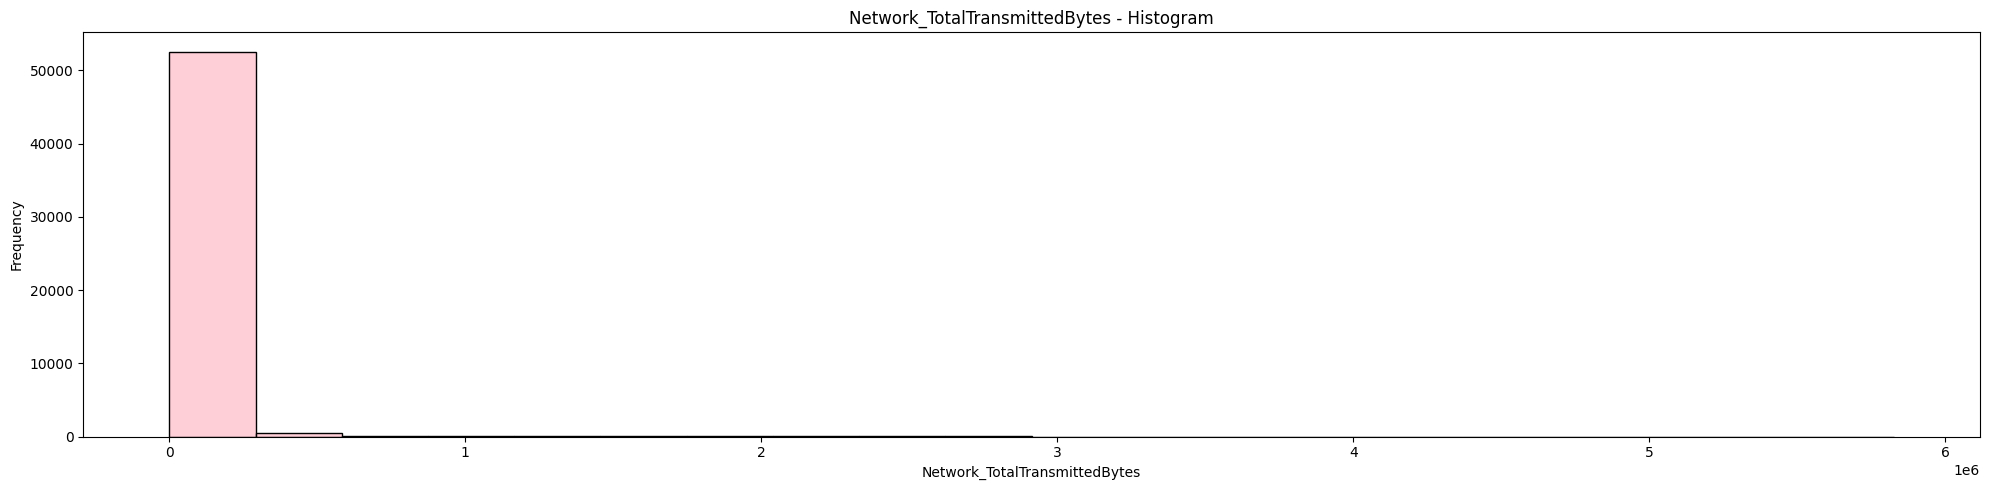

In [39]:
default_pipeline.EDA.plot_histograms(features=["Network_TotalTransmittedBytes"], n_cols=1, bins=20)

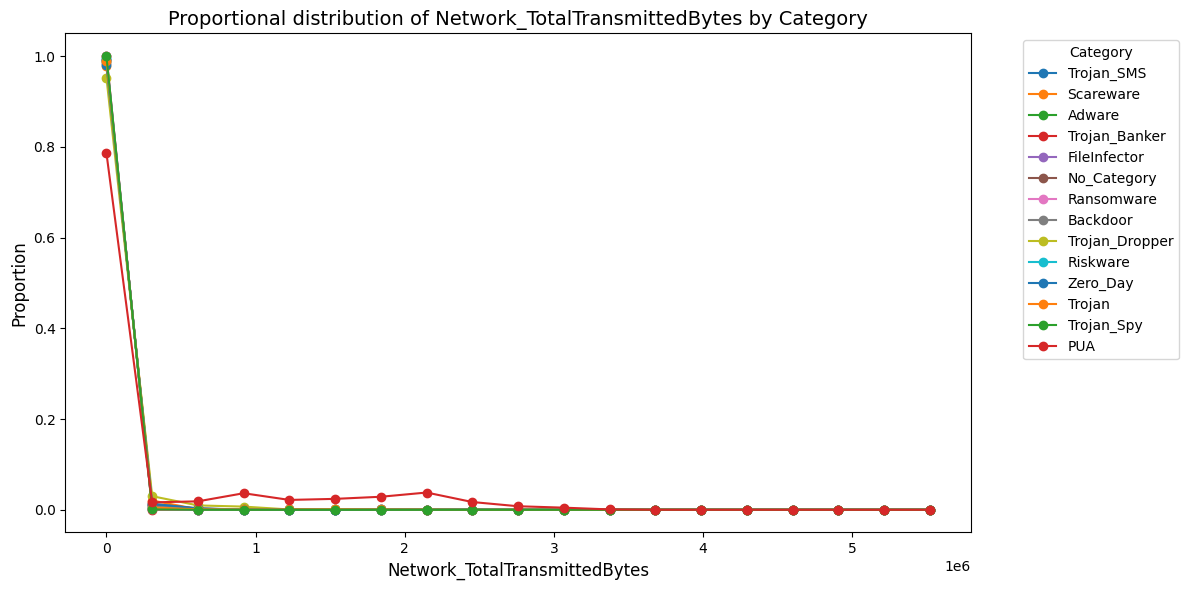

In [40]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalTransmittedBytes",
    category_column="Category"
)

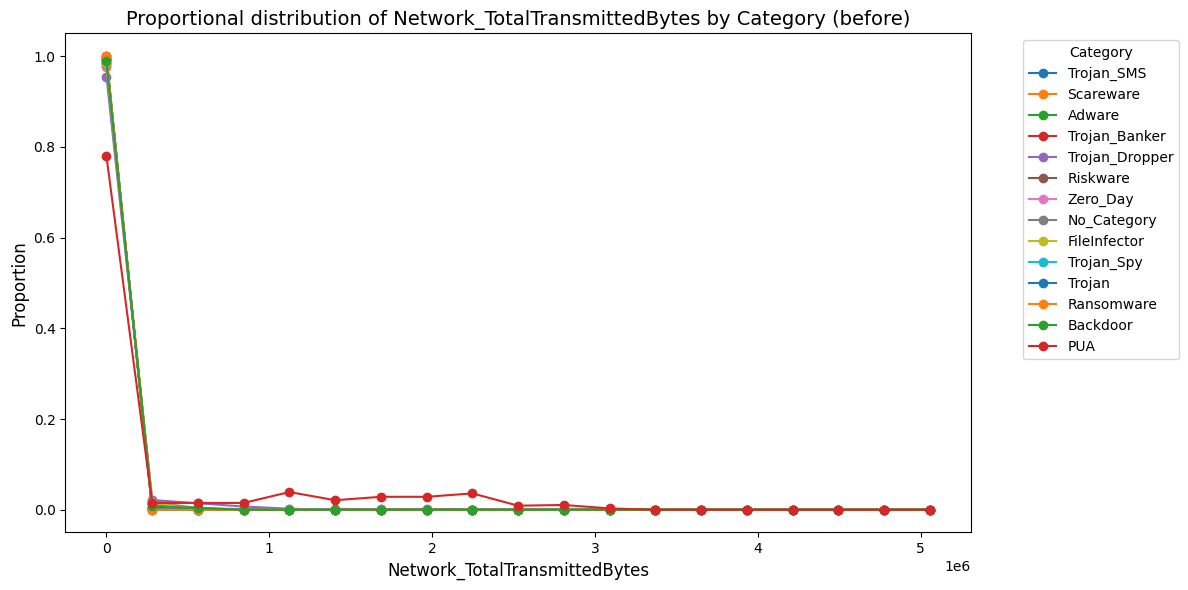

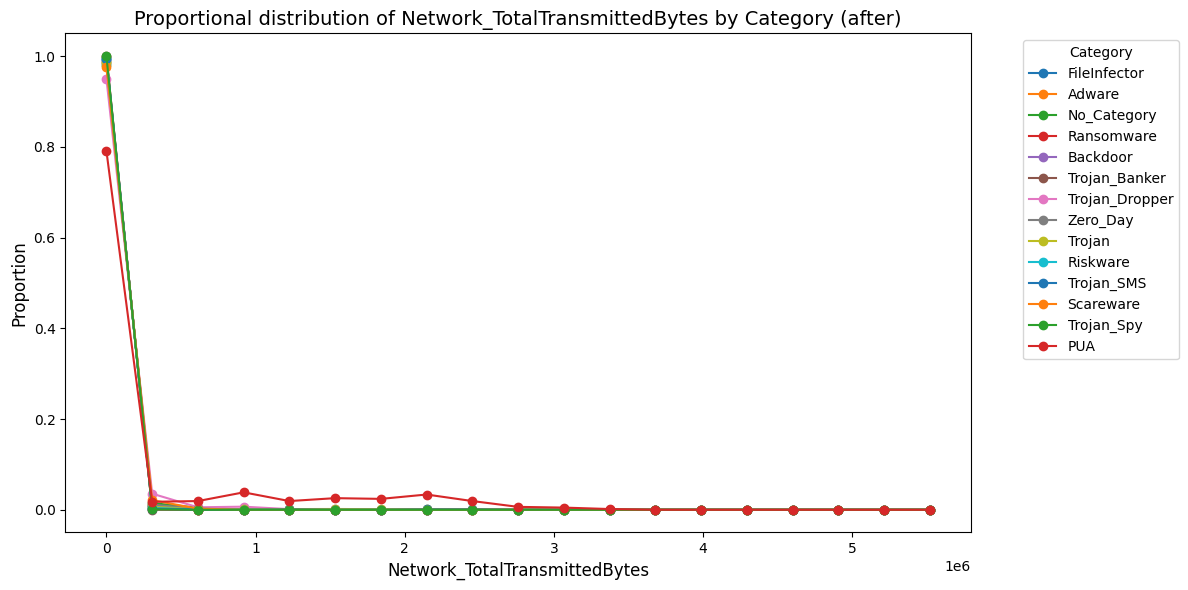

In [41]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalTransmittedBytes",
    category_column="Category",
    by_reboot = True
)

In [42]:
df.groupby('Category')['Network_TotalTransmittedBytes'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,29919.043534,106148.285667,0.0,843.0,4440.0,17158.25,5826047.0
Backdoor,1137.0,15985.079156,55447.976371,0.0,0.0,2160.0,7852.00,728616.0
FileInfector,248.0,31576.721774,69873.990899,0.0,0.0,0.0,9695.50,493424.0
No_Category,1932.0,24106.189441,74391.207397,0.0,0.0,2040.0,12771.00,908380.0
PUA,1290.0,377101.190698,762784.514738,0.0,0.0,4319.5,150112.50,3441332.0
Ransomware,3411.0,1403.851363,16030.746883,0.0,0.0,0.0,0.00,350571.0
Riskware,14053.0,20693.283641,84850.094634,0.0,1268.0,8061.0,22440.00,4112632.0
Scareware,886.0,28150.909707,77781.713860,0.0,0.0,0.0,1032.75,619830.0
Trojan,8437.0,22131.309233,119538.976582,0.0,453.0,5282.0,17018.00,2847552.0


#### Network_TotalReceivedPackets

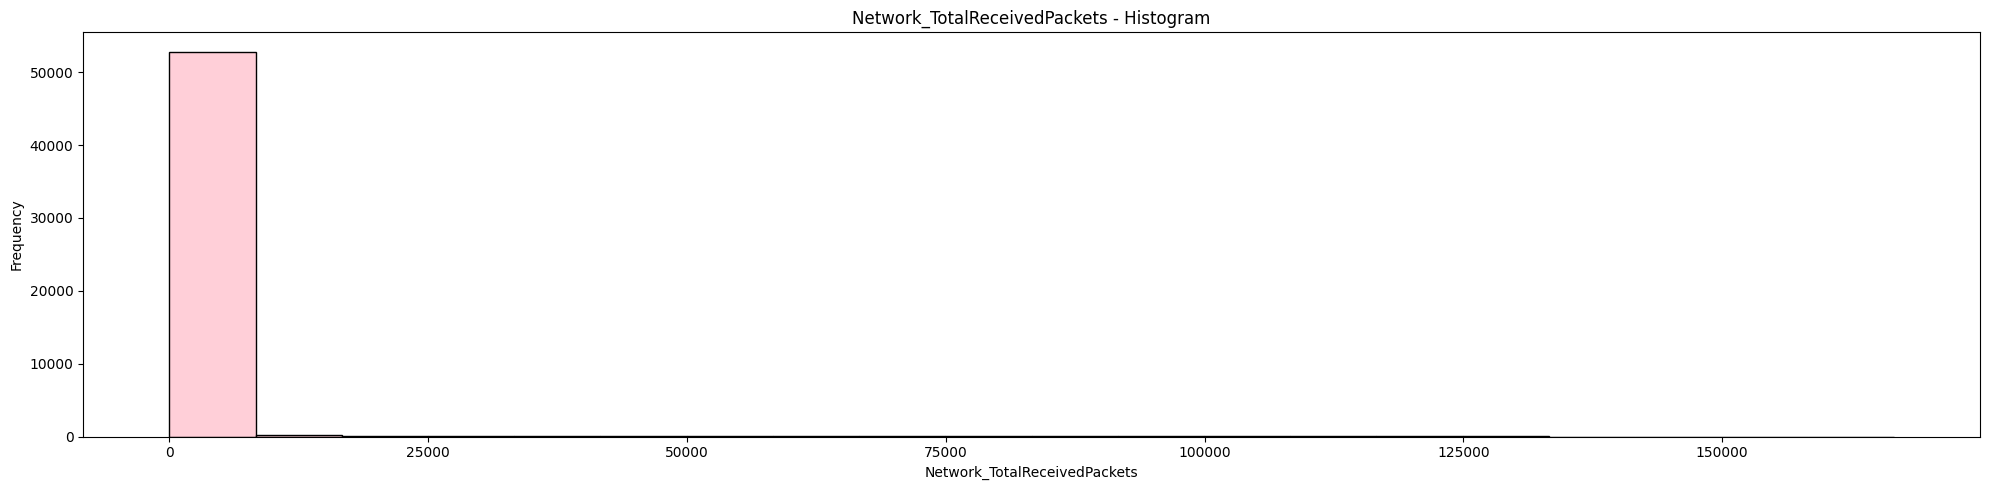

In [43]:
default_pipeline.EDA.plot_histograms(features=["Network_TotalReceivedPackets"], n_cols=1, bins=20)

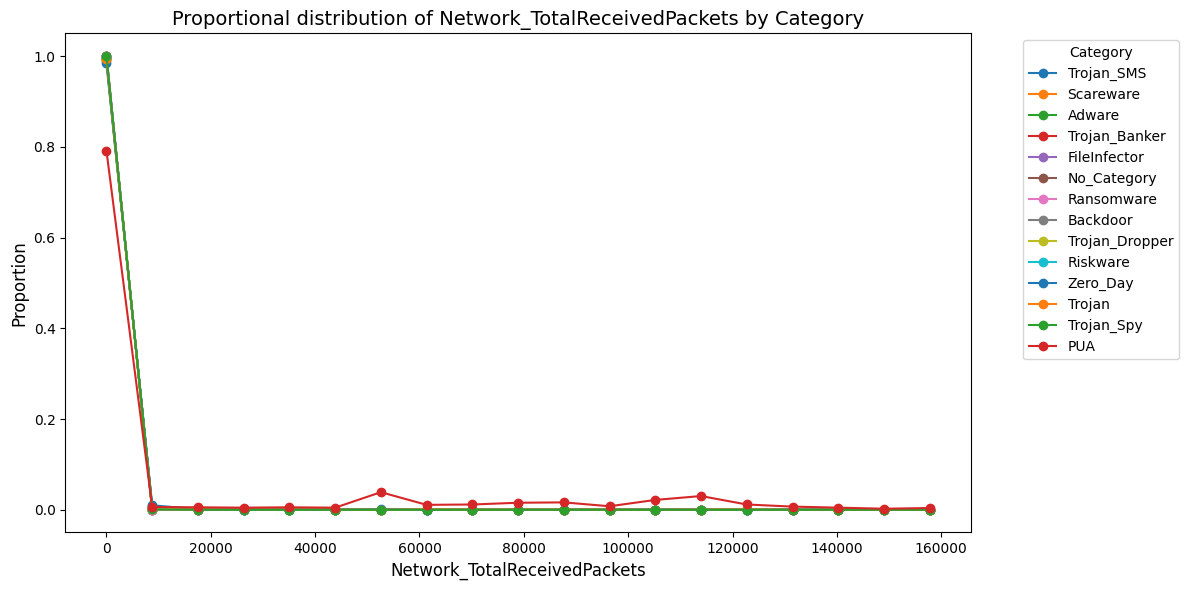

In [44]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalReceivedPackets",
    category_column="Category"
)

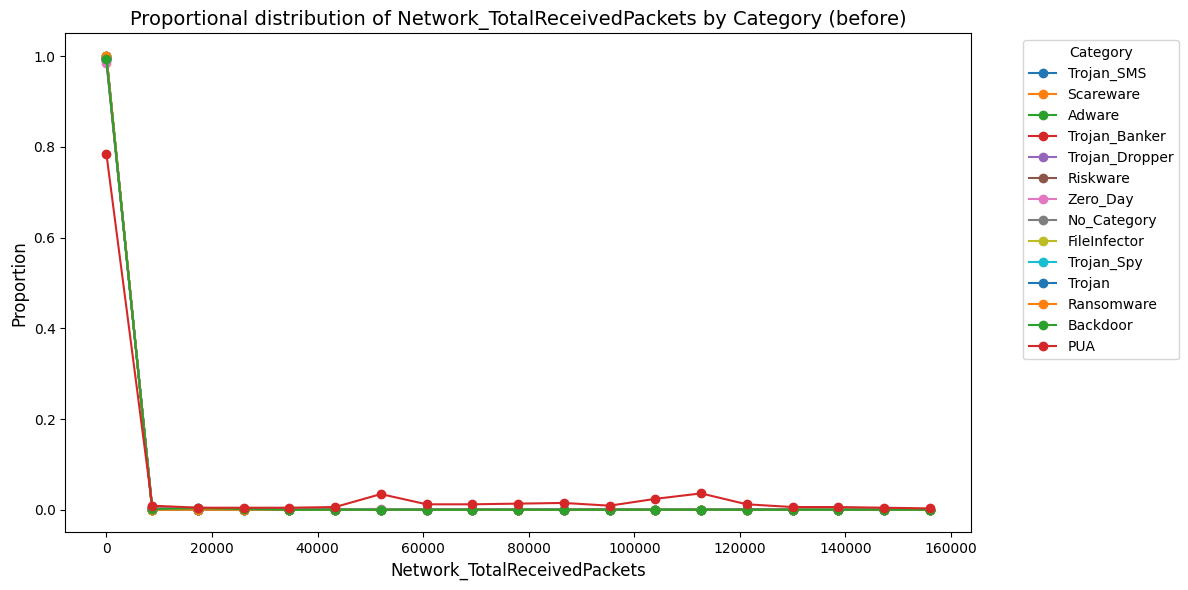

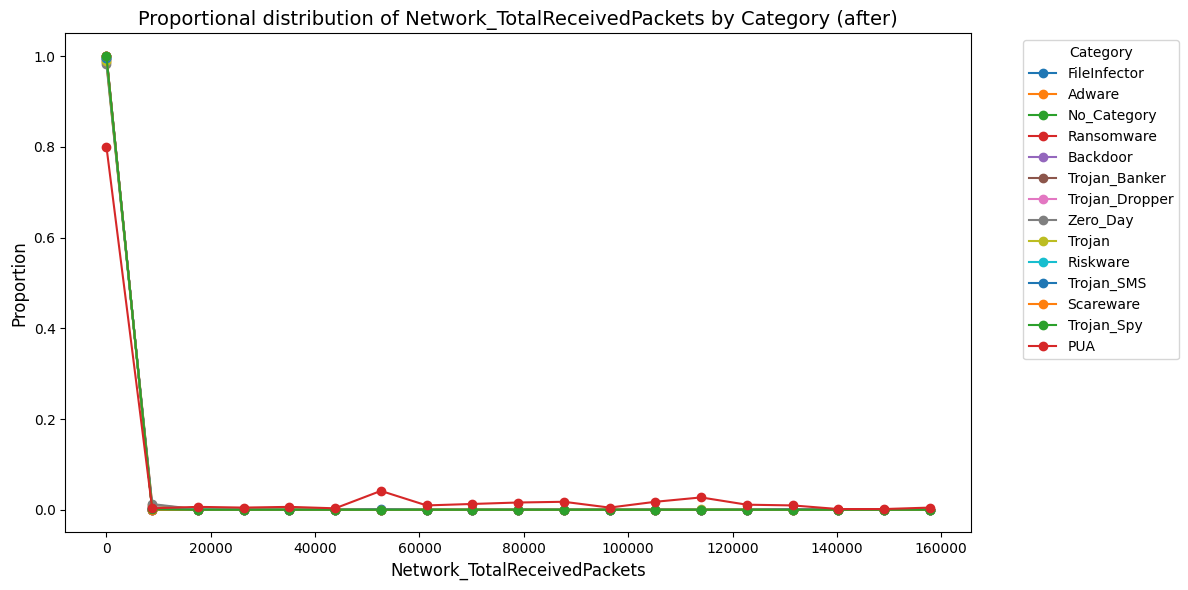

In [45]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalReceivedPackets",
    category_column="Category",
    by_reboot = True
)

In [46]:
df.groupby('Category')['Network_TotalReceivedPackets'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,397.623042,1691.604352,0.0,0.0,12.0,127.00,49261.0
Backdoor,1137.0,248.086192,1692.149185,0.0,0.0,12.0,40.00,34140.0
FileInfector,248.0,439.189516,975.729226,0.0,0.0,0.0,85.50,4911.0
No_Category,1932.0,301.412526,1256.696375,0.0,0.0,11.0,98.00,20259.0
PUA,1290.0,18387.518605,38899.030230,0.0,0.0,24.0,1401.50,166574.0
Ransomware,3411.0,16.842568,231.994371,0.0,0.0,0.0,0.00,7674.0
Riskware,14053.0,274.481961,2823.224416,0.0,3.0,13.0,88.00,145179.0
Scareware,886.0,319.257336,865.771586,0.0,0.0,0.0,1.75,8253.0
Trojan,8437.0,559.411876,6542.279058,0.0,0.0,20.0,40.00,156169.0


#### Network_TotalTransmittedPackets

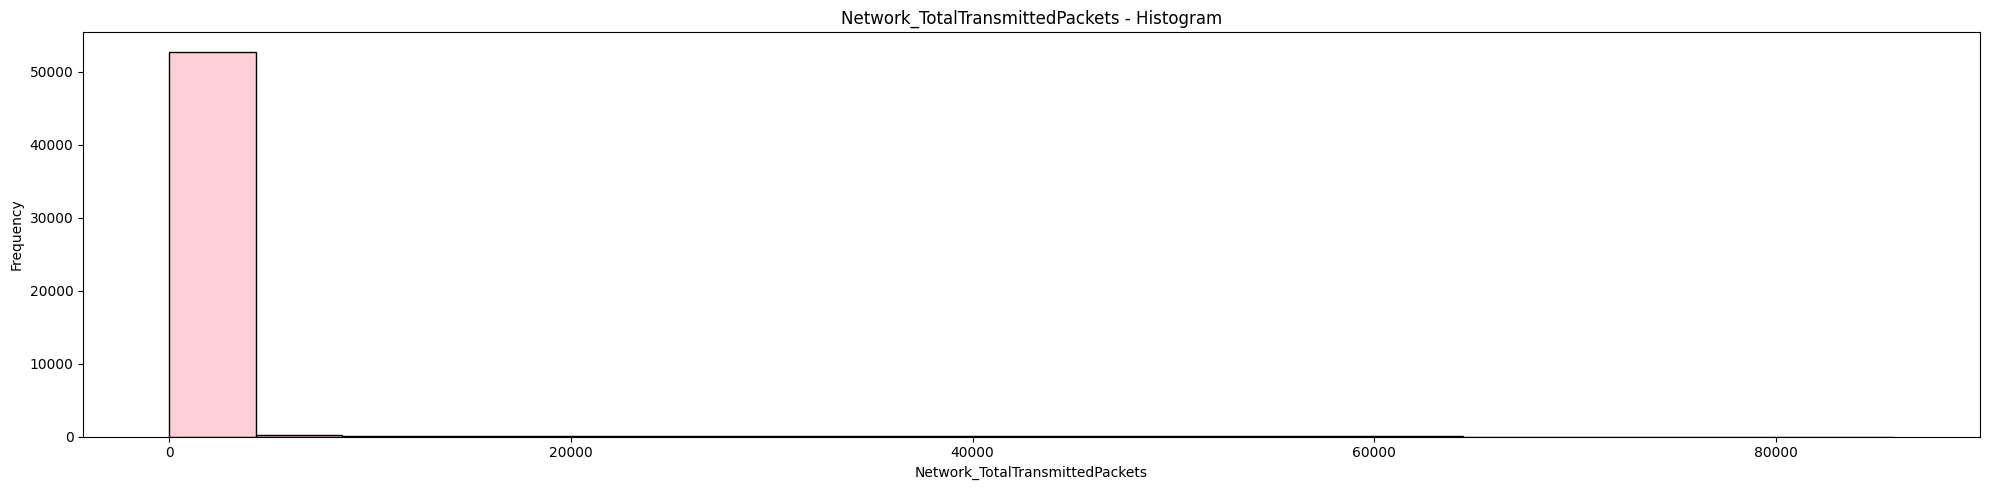

In [47]:
default_pipeline.EDA.plot_histograms(features=["Network_TotalTransmittedPackets"], n_cols=1, bins=20)

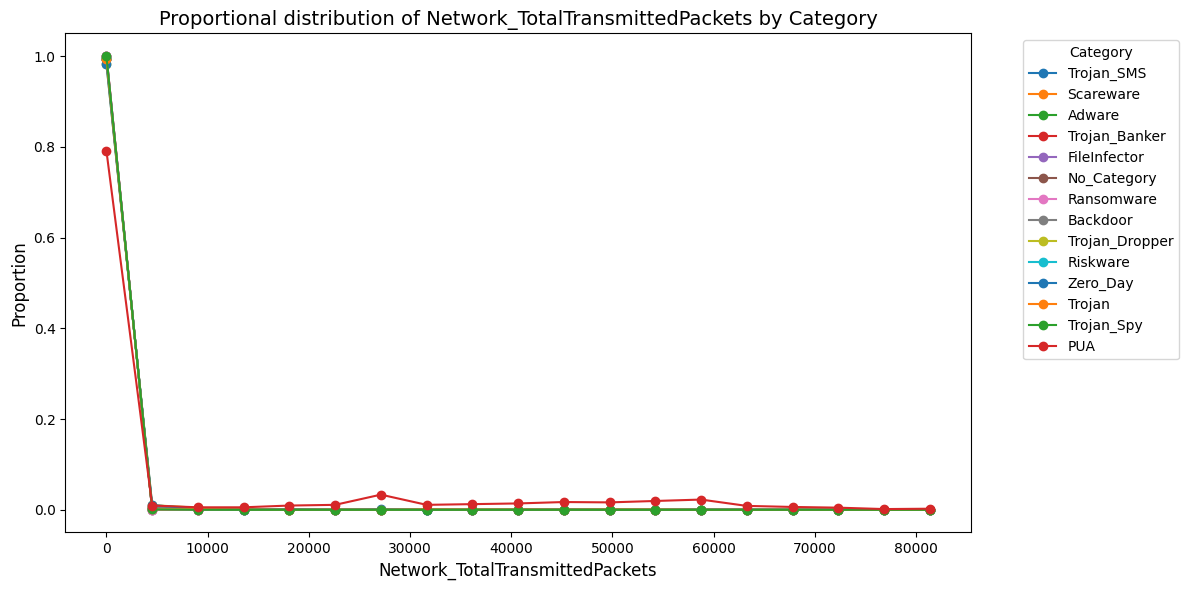

In [48]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalTransmittedPackets",
    category_column="Category"
)

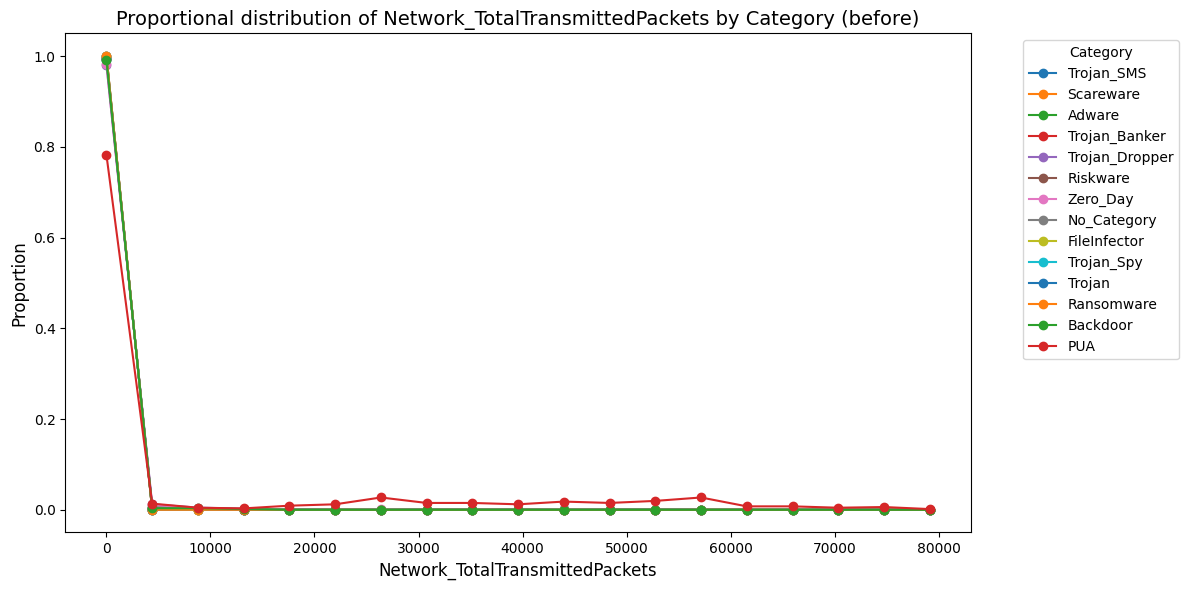

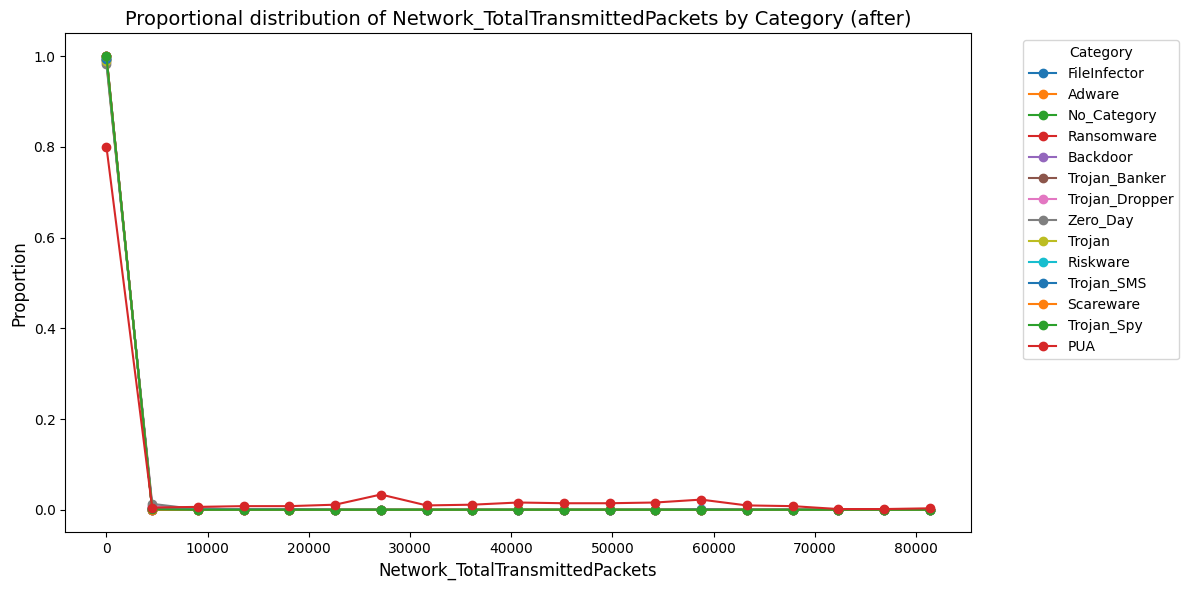

In [49]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Network_TotalTransmittedPackets",
    category_column="Category",
    by_reboot = True
)

In [50]:
df.groupby('Category')['Network_TotalTransmittedPackets'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,284.478233,866.618994,0.0,6.0,40.0,162.00,26171.0
Backdoor,1137.0,179.678980,918.590526,0.0,0.0,13.0,62.00,15541.0
FileInfector,248.0,325.685484,698.562478,0.0,0.0,0.0,95.50,3434.0
No_Category,1932.0,241.872153,813.499711,0.0,0.0,21.0,126.00,12056.0
PUA,1290.0,9012.811628,19075.297898,0.0,0.0,34.5,1179.25,85873.0
Ransomware,3411.0,14.437115,170.991565,0.0,0.0,0.0,0.00,4506.0
Riskware,14053.0,246.615385,1233.861029,0.0,6.0,64.0,286.00,57591.0
Scareware,886.0,244.194131,621.265354,0.0,0.0,0.0,11.50,5043.0
Trojan,8437.0,288.846746,2869.202881,0.0,5.0,27.0,64.00,71000.0


#### Metrics Comparison


--- Network_TotalReceivedBytes Analysis ---


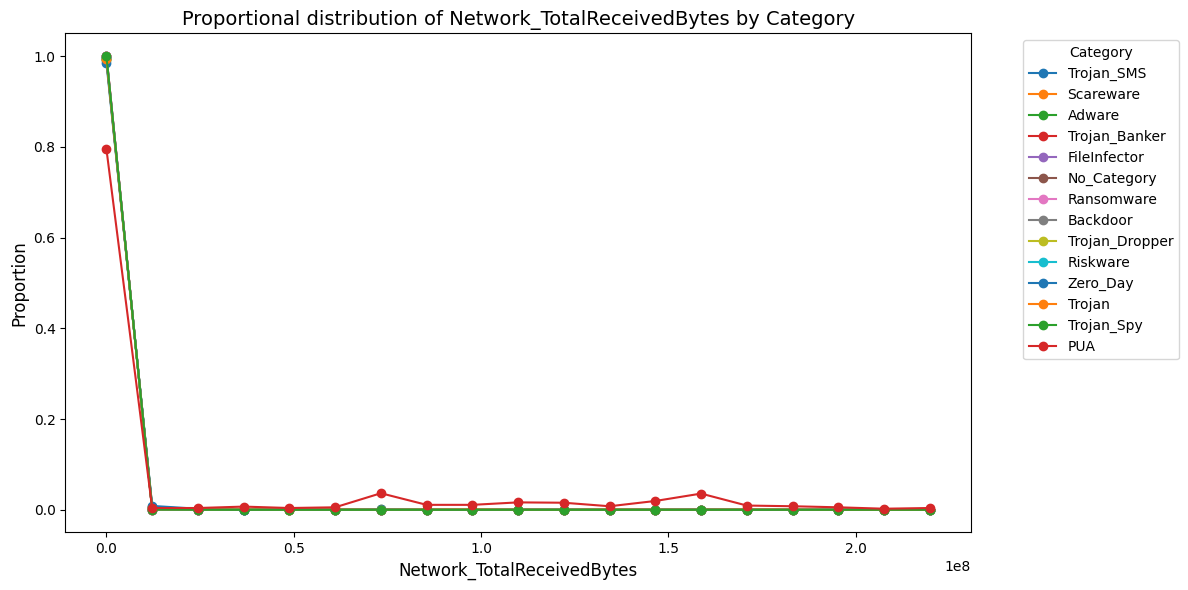


--- Network_TotalReceivedPackets Analysis ---


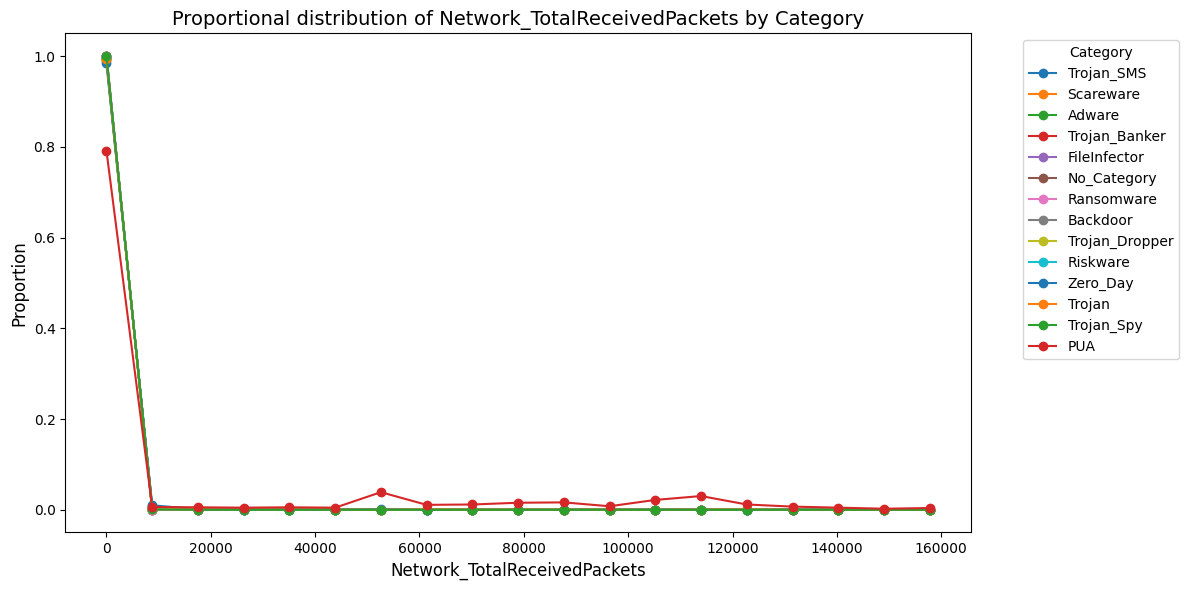


--- Network_TotalTransmittedBytes Analysis ---


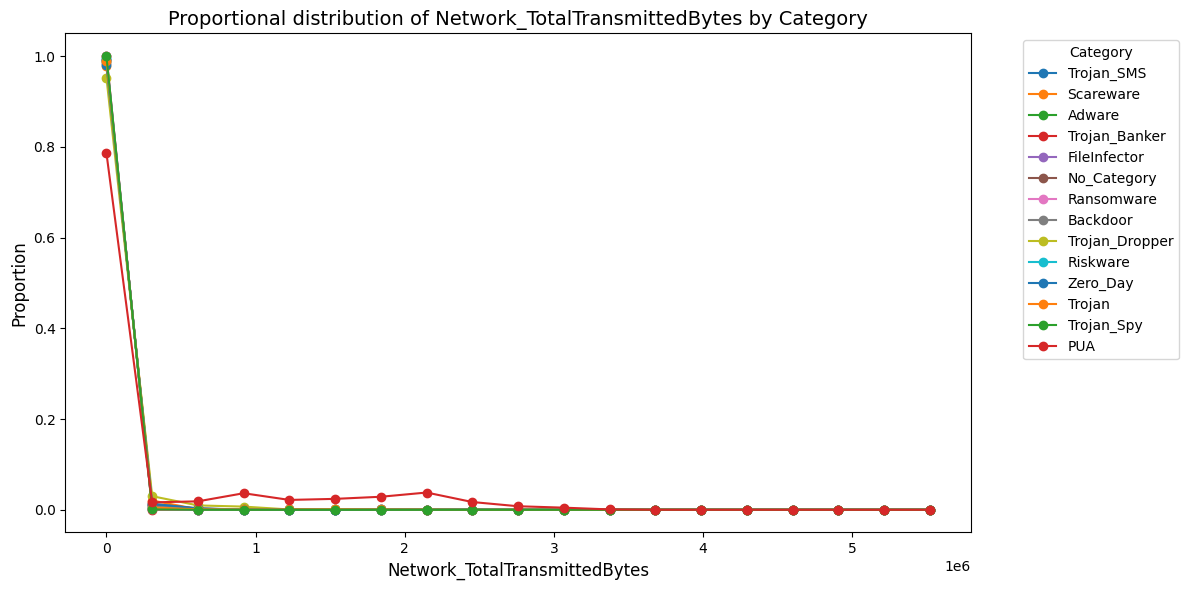


--- Network_TotalTransmittedPackets Analysis ---


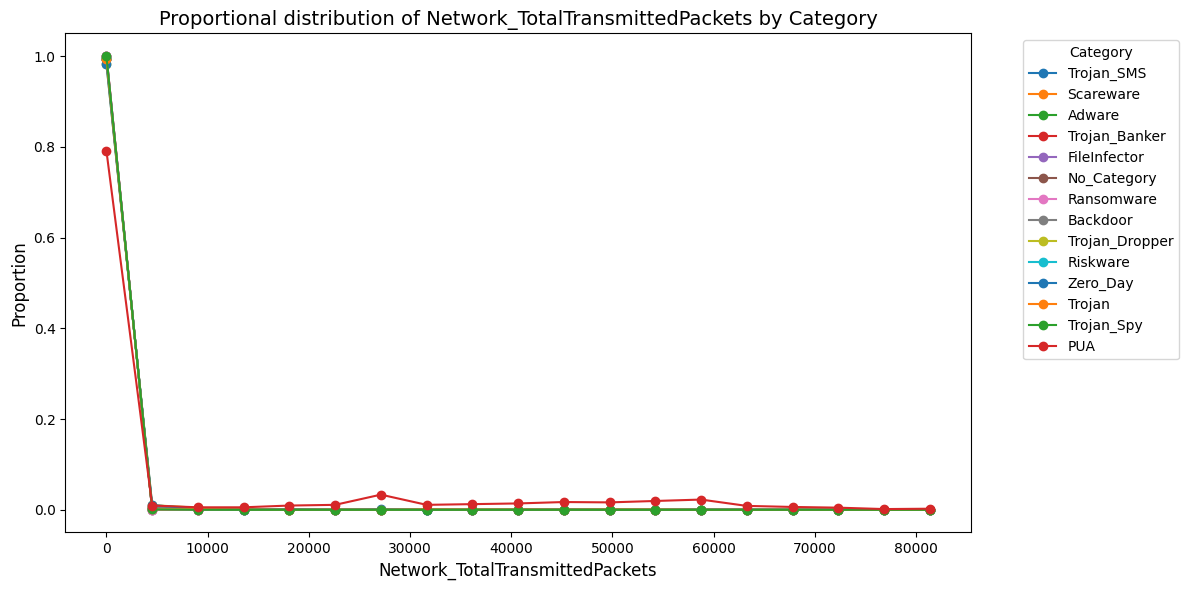

In [51]:
network_features = [
    "Network_TotalReceivedBytes", 
    "Network_TotalReceivedPackets",
    "Network_TotalTransmittedBytes", 
    "Network_TotalTransmittedPackets"
]

# Option 1: Call the method sequentially for all features
for feature in network_features:
    print(f"\n--- {feature} Analysis ---")
    default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
        feature=feature,
        category_column="Category",
    )

Option 1: Bytes vs Packets (Efficiency Analysis)
Comparing sent bytes vs sent packets (and received bytes vs received packets) reveals:

Traffic Efficiency: How much data per packet is being transmitted
Payload Size Patterns: Whether malware uses many small packets or fewer large packets
Exfiltration Signatures: Large bytes/packet ratio could indicate data theft
This helps identify efficiency patterns within each communication direction.

Option 2: Sent vs Received (Direction Analysis)
Comparing sent bytes vs received bytes (and sent packets vs received packets) reveals:

Traffic Direction Balance: Whether more data is flowing in or out
Command & Control Pattern: High incoming/outgoing packet ratio suggests frequent commands
Data Theft Pattern: High outgoing data volume suggests exfiltration

Differences in Network_TotalReceivedBytes, Network_TotalTransmittedBytes, Network_TotalReceivedPackets and Network_TotalTransmittedPackets (After - Before Reboot):
               Difference_ReceivedBytes Difference_TransmittedBytes  \
Reboot                                                                
Category                                                              
Adware                     1.027427e+05                 2658.745283   
Backdoor                  -2.171216e+05                -2952.379130   
FileInfector              -7.208441e+04                 1812.044753   
No_Category                2.259161e+04                 3663.961353   
PUA                       -2.512081e+06               -29801.224421   
Ransomware                 1.369609e+02                 -284.354588   
Riskware                  -1.376977e+05                -1561.097034   
Scareware                 -4.812272e+03                 3342.339133   
Trojan                     6.611583e+05                

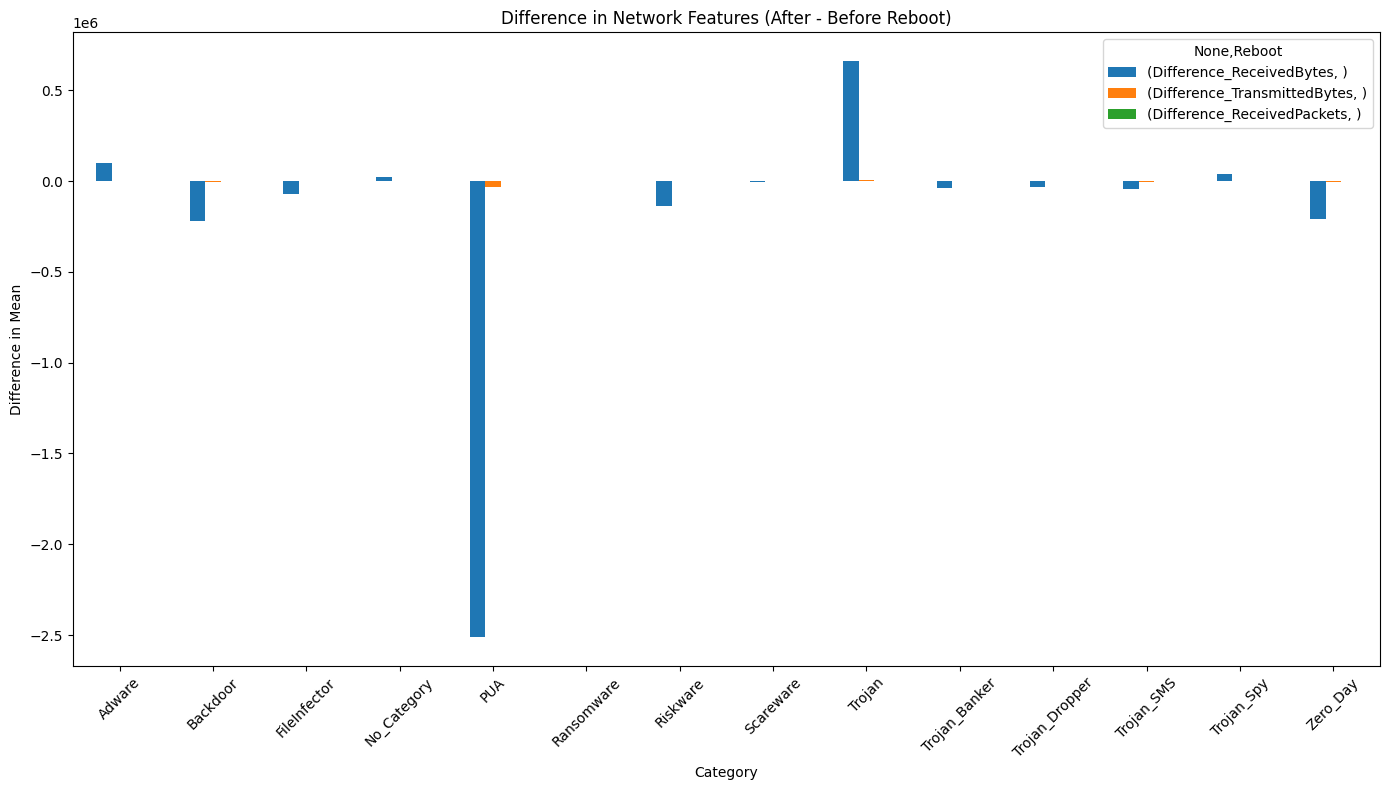

In [52]:
features_of_interest = ["Network_TotalReceivedBytes","Network_TotalTransmittedBytes", "Network_TotalReceivedPackets", "Network_TotalTransmittedPackets"]

category_means_filtered = (
    default_pipeline.dataset.df.groupby(['Category', 'Reboot'])[features_of_interest]
    .mean()
    .unstack()
)

category_means_filtered['Difference_ReceivedBytes'] = (
    category_means_filtered[('Network_TotalReceivedBytes', 'after')] - 
    category_means_filtered[('Network_TotalReceivedBytes', 'before')]
)
category_means_filtered['Difference_TransmittedBytes'] = (
    category_means_filtered[('Network_TotalTransmittedBytes', 'after')] - 
    category_means_filtered[('Network_TotalTransmittedBytes', 'before')]
)
category_means_filtered['Difference_ReceivedPackets'] = (
    category_means_filtered[('Network_TotalReceivedPackets', 'after')] - 
    category_means_filtered[('Network_TotalReceivedPackets', 'before')]
)
category_means_filtered['Difference_TransmittedPackets'] = (
    category_means_filtered[('Network_TotalTransmittedPackets', 'after')] - 
    category_means_filtered[('Network_TotalTransmittedPackets', 'before')]
)

print("Differences in Network_TotalReceivedBytes, Network_TotalTransmittedBytes, Network_TotalReceivedPackets and Network_TotalTransmittedPackets (After - Before Reboot):")
print(category_means_filtered[['Difference_ReceivedBytes', 'Difference_TransmittedBytes', 'Difference_ReceivedPackets', 'Difference_TransmittedPackets']])

category_means_filtered[['Difference_ReceivedBytes', 'Difference_TransmittedBytes', 'Difference_ReceivedPackets']].plot(
    kind='bar', figsize=(14, 8), title='Difference in Network Features (After - Before Reboot)'
)
plt.ylabel('Difference in Mean')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Zero Activity Rows: 

Hypothesis: 

Some types of malware might intentionally avoid any network activity during initial execution to stay under the radar. For example, they could be waiting for a trigger, like a reboot or user action, before doing anything suspicious. So just because a sample doesn’t show network behavior right away doesn’t mean it’s harmless — it could actually be a sign that it’s trying to hide.


Overall Zero Network Activity Statistics:
Total samples: 53439
Samples with no network activity: 18610
Percentage of samples with no network activity: 34.82%

Per-Category Zero Network Activity Statistics:
                Total  Zero_Network  Percentage
Category                                       
Adware          10980          2442   22.240437
Backdoor         1137           441   38.786280
FileInfector      248           162   65.322581
No_Category      1932           767   39.699793
PUA              1290           550   42.635659
Ransomware       3411          3273   95.954266
Riskware        14053          2645   18.821604
Scareware         886           655   73.927765
Trojan           8437          1971   23.361384
Trojan_Banker     241           174   72.199170
Trojan_Dropper   1570          1166   74.267516
Trojan_SMS       1939          1203   62.042290
Trojan_Spy       2840          1795   63.204225
Zero_Day         4475          1366   30.525140


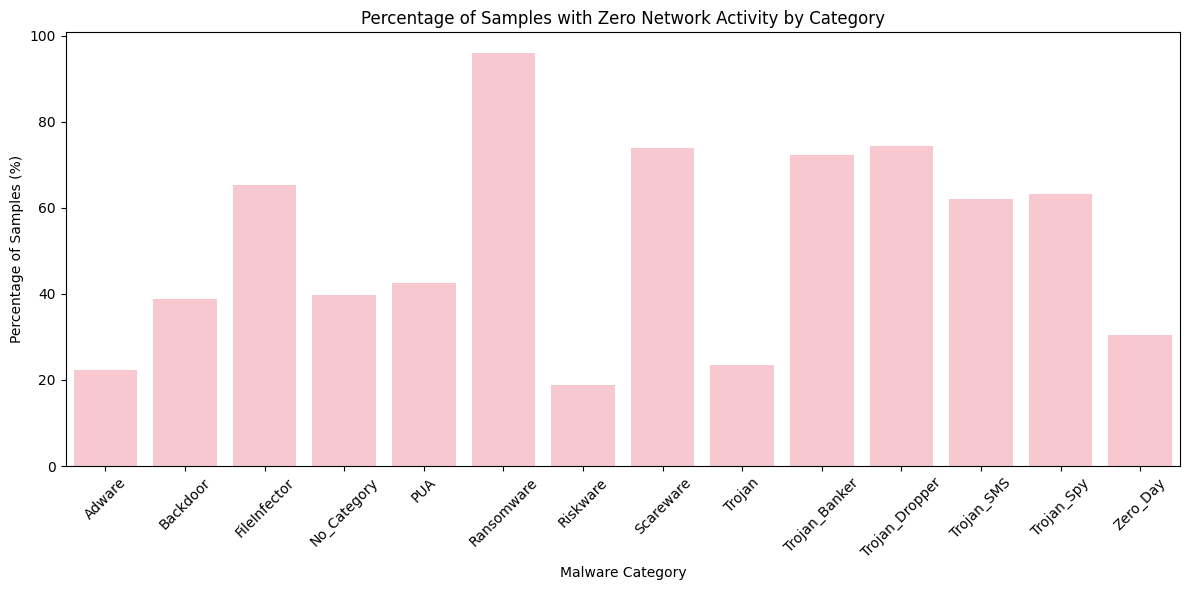

In [53]:
network_features = [
    'Network_TotalReceivedBytes',
    'Network_TotalReceivedPackets', 
    'Network_TotalTransmittedBytes',
    'Network_TotalTransmittedPackets'
]

# Get the data from your pipeline
df = default_pipeline.dataset.df

# Create a mask for rows where all network features are 0
zero_network_mask = (df[network_features] == 0).all(axis=1)

# Calculate overall statistics
total_samples = len(df)
zero_network_samples = zero_network_mask.sum()
zero_network_percentage = (zero_network_samples / total_samples) * 100

print(f"\nOverall Zero Network Activity Statistics:")
print(f"Total samples: {total_samples}")
print(f"Samples with no network activity: {zero_network_samples}")
print(f"Percentage of samples with no network activity: {zero_network_percentage:.2f}%")

# Calculate per-category statistics
category_stats = pd.DataFrame({
    'Total': df['Category'].value_counts(),
    'Zero_Network': df[zero_network_mask]['Category'].value_counts()
})
category_stats['Percentage'] = (category_stats['Zero_Network'] / category_stats['Total'] * 100)

print("\nPer-Category Zero Network Activity Statistics:")
print(category_stats)

#  Bar plot comparing categories
plt.figure(figsize=(12, 6))
sns.barplot(x=category_stats.index, y='Percentage', data=category_stats, color='pink')
plt.title('Percentage of Samples with Zero Network Activity by Category')
plt.xlabel('Malware Category')
plt.ylabel('Percentage of Samples (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Out of over 53,000 total samples, around 35% showed no network communication at all during execution, which shows to be a pretty high number. This supports the idea that some malware might suppress network behavior in early stages to avoid detection, possibly lying dormant until triggered. When breaking it down by category we can see that nearly 96% of ransomware samples had no network activity. Similarly, Scareware, Droppers, and various Trojan types also showed over 60% inactivity. On the other hand, categories like Adware and Riskware had much lower percentages, aligning with a noisy and persistent background behavior.

To dig deeper into whether this lack of network activity is part of a stealth strategy, we looked at how behavior changes before and after a device reboot. The idea here is that some malware might be designed to stay quiet initially, especially during sandbox analysis, and only activate after a reboot, when it assumes it’s running on a real device. 

So, we calculated the percentage of samples with zero network activity before versus after reboot for each malware category. By comparing these two stages with a barplot, we’re able to spot patterns where certain malware types start off dormant but become active later on. If we see a significant drop in zero activity samples after reboot, that would suggest those categories are using reboot as a trigger, possibly as a sandbox evasion technique.

Zero Network Activity Analysis - Before vs After Reboot:

Percentages by Category:
          Category  Before_Reboot_Zero_Pct  After_Reboot_Zero_Pct  Difference
3    Trojan_Banker               62.711864              81.300813   18.588949
11          Trojan               19.741614              27.329193    7.587579
10        Zero_Day               27.565479              33.737185    6.171707
7         Backdoor               37.055838              40.659341    3.603503
2           Adware               20.657760              24.037340    3.379580
8   Trojan_Dropper               72.879331              75.852660    2.973329
9         Riskware               17.766148              19.949941    2.183793
0       Trojan_SMS               61.284047              62.897914    1.613868
6       Ransomware               95.325094              96.709677    1.384583
13             PUA               42.105263              43.200000    1.094737
1        Scareware               74.242424              73.

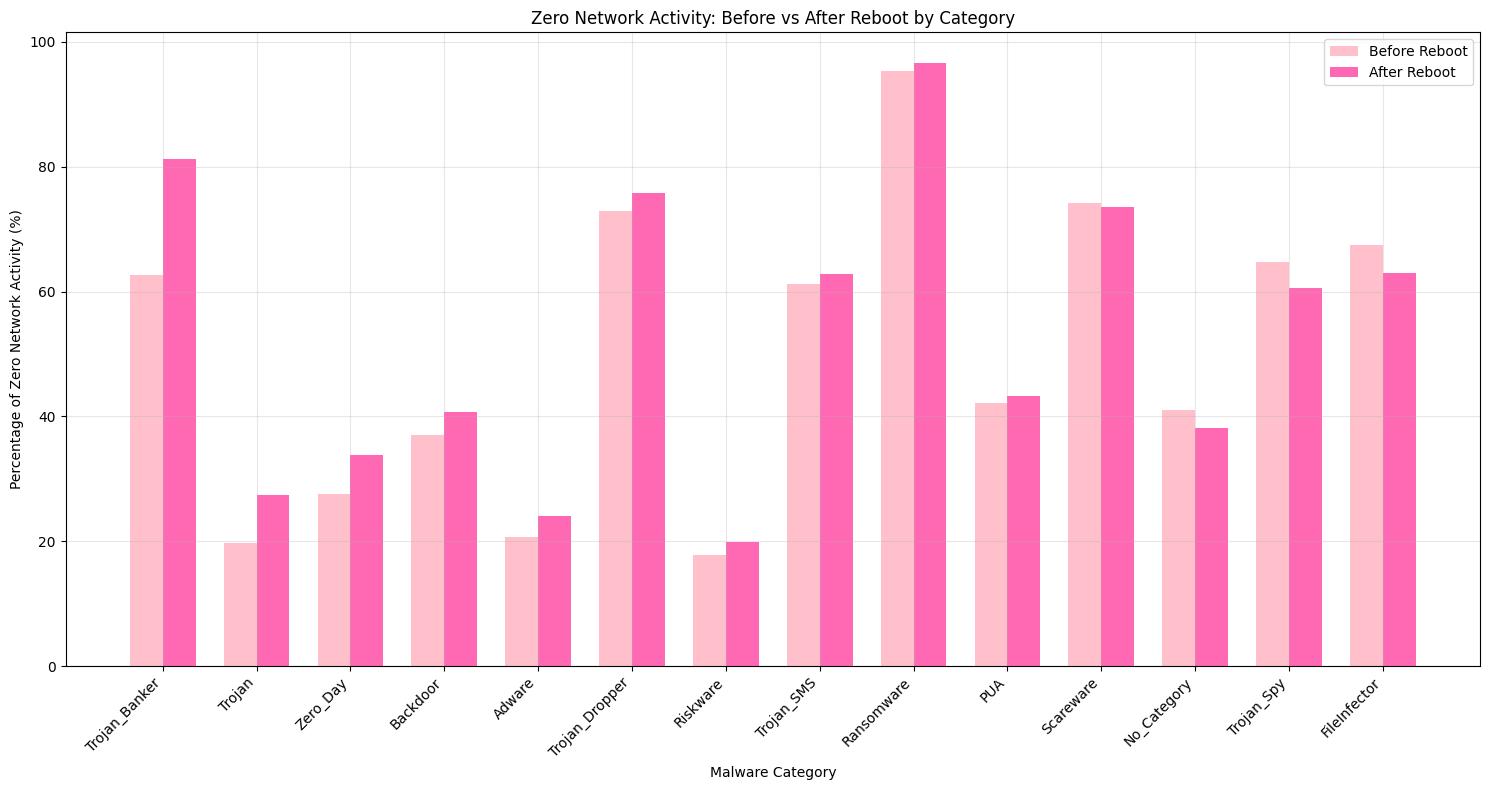


Detailed Analysis:

Categories with biggest increase in activity after reboot (largest negative difference):
        Category  Difference
4   FileInfector   -4.416650
12    Trojan_Spy   -4.202830
5    No_Category   -2.908362
1      Scareware   -0.657519
13           PUA    1.094737

Categories with biggest decrease in activity after reboot (largest positive difference):
         Category  Difference
3   Trojan_Banker   18.588949
11         Trojan    7.587579
10       Zero_Day    6.171707
7        Backdoor    3.603503
2          Adware    3.379580

Overall Statistics:
Overall zero network activity before reboot: 33.90%
Overall zero network activity after reboot: 35.87%

Categories with significant change (>10% difference):
        Category  Before_Reboot_Zero_Pct  After_Reboot_Zero_Pct  Difference
3  Trojan_Banker               62.711864              81.300813   18.588949


In [54]:
# Get the data from your pipeline
df = default_pipeline.dataset.df

# Split data by reboot status and calculate percentages
def calculate_zero_network_percentage(data):
    return (data[network_features] == 0).all(axis=1).mean() * 100

# Calculate percentages for before and after reboot for each category
stats = []
for category in df['Category'].unique():
    category_data = df[df['Category'] == category]
    
    before_reboot = category_data[category_data['Reboot'] == 'before']
    after_reboot = category_data[category_data['Reboot'] == 'after']
    
    before_zero_pct = calculate_zero_network_percentage(before_reboot)
    after_zero_pct = calculate_zero_network_percentage(after_reboot)
    
    stats.append({
        'Category': category,
        'Before_Reboot_Zero_Pct': before_zero_pct,
        'After_Reboot_Zero_Pct': after_zero_pct,
        'Difference': after_zero_pct - before_zero_pct,
        'Samples_Before': len(before_reboot),
        'Samples_After': len(after_reboot)
    })

# Convert to DataFrame
stats_df = pd.DataFrame(stats)
stats_df = stats_df.sort_values('Difference', ascending=False)

# Print statistics
print("Zero Network Activity Analysis - Before vs After Reboot:")
print("\nPercentages by Category:")
print(stats_df[['Category', 'Before_Reboot_Zero_Pct', 'After_Reboot_Zero_Pct', 'Difference']])

# Create grouped bar plot
plt.figure(figsize=(15, 8))
x = np.arange(len(stats_df))
width = 0.35

plt.bar(x - width/2, stats_df['Before_Reboot_Zero_Pct'], width, label='Before Reboot', color='pink')
plt.bar(x + width/2, stats_df['After_Reboot_Zero_Pct'], width, label='After Reboot', color='hotpink')

plt.xlabel('Malware Category')
plt.ylabel('Percentage of Zero Network Activity (%)')
plt.title('Zero Network Activity: Before vs After Reboot by Category')
plt.xticks(x, stats_df['Category'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nDetailed Analysis:")
print("\nCategories with biggest increase in activity after reboot (largest negative difference):")
print(stats_df.nsmallest(5, 'Difference')[['Category', 'Difference']])

print("\nCategories with biggest decrease in activity after reboot (largest positive difference):")
print(stats_df.nlargest(5, 'Difference')[['Category', 'Difference']])

# Calculate overall statistics
print("\nOverall Statistics:")
total_before = df[df['Reboot'] == 'before']
total_after = df[df['Reboot'] == 'after']
print(f"Overall zero network activity before reboot: {calculate_zero_network_percentage(total_before):.2f}%")
print(f"Overall zero network activity after reboot: {calculate_zero_network_percentage(total_after):.2f}%")

# Identify significant changes
significant_change = stats_df[abs(stats_df['Difference']) > 10]
print("\nCategories with significant change (>10% difference):")
print(significant_change[['Category', 'Before_Reboot_Zero_Pct', 'After_Reboot_Zero_Pct', 'Difference']])

Overall, the percentage of samples with zero network activity slightly increased after reboot (from 33.9% to 35.87%), which wasn’t what we initially expected. 

Trojan_Banker showed the bigget change jumping from 62.7% of samples being inactive before reboot to over 81% after. Similarly, categories like Trojan, Zero_Day, and Backdoor also became more dormant post reboot. This suggests that instead of reboot triggering activity, some malware might be designed to go quiet after reboot, possibly to blend in with normal system behavior or to delay actions until further conditions are met.

On the other side, a few categories did show a decrease in zero network activity after reboot. FileInfector and Trojan_Spy, for instance, had lower percentages of inactivity post reboot, which supports the idea that these types might actually be triggered to start behaving after the system restarts. 

Categories clearly respond to reboot differently, possibly using it as a way to hide longer or wait for the right moment to act.

### Asymmetric communication
Received vs Transmitted Ratio: Shows communication balance

Hypothesis: 

If a malware sample is only sending or only receiving data, that might tell us something about what it's trying to do. For instance, malware that only sends data could be stealing information, while one that only receives could be waiting for commands from a remote server. This kind of unbalanced communication pattern isn’t typical in most normal apps, so it could be a useful behavioral clue.

Code:

Create Boolean masks:

Sent > 0, Received = 0

Sent = 0, Received > 0

Group by category, count and visualize both cases


In [55]:
# Create boolean masks for unidirectional communication
only_sending_mask = (
    (df['Network_TotalTransmittedBytes'] > 0) & 
    (df['Network_TotalTransmittedPackets'] > 0) & 
    (df['Network_TotalReceivedBytes'] == 0) & 
    (df['Network_TotalReceivedPackets'] == 0)
)

only_receiving_mask = (
    (df['Network_TotalTransmittedBytes'] == 0) & 
    (df['Network_TotalTransmittedPackets'] == 0) & 
    (df['Network_TotalReceivedBytes'] > 0) & 
    (df['Network_TotalReceivedPackets'] > 0)
)

# Calculate statistics per category using a more efficient approach
stats = []
for category in df['Category'].unique():
    category_mask = df['Category'] == category
    total_samples = category_mask.sum()
    
    # Calculate intersections of masks
    only_sending = (category_mask & only_sending_mask).sum()
    only_receiving = (category_mask & only_receiving_mask).sum()
    
    stats.append({
        'Category': category,
        'Total_Samples': total_samples,
        'Only_Sending': only_sending,
        'Only_Receiving': only_receiving,
        'Only_Sending_Percentage': (only_sending / total_samples * 100),
        'Only_Receiving_Percentage': (only_receiving / total_samples * 100)
    })

# Convert to DataFrame
stats_df = pd.DataFrame(stats)

# Sort by total unidirectional communication
stats_df['Total_Unidirectional'] = stats_df['Only_Sending_Percentage'] + stats_df['Only_Receiving_Percentage']
stats_df = stats_df.sort_values('Total_Unidirectional', ascending=False)

# Print overall statistics
print("Unidirectional Network Communication Analysis")
print("\nOverall Statistics:")
print(f"Total samples: {len(df)}")
print(f"Samples only sending data: {only_sending_mask.sum()} ({only_sending_mask.mean()*100:.2f}%)")
print(f"Samples only receiving data: {only_receiving_mask.sum()} ({only_receiving_mask.mean()*100:.2f}%)")

# Print per-category statistics
print("\nPer-Category Statistics:")
print(stats_df[['Category', 'Total_Samples', 'Only_Sending_Percentage', 'Only_Receiving_Percentage']])


Unidirectional Network Communication Analysis

Overall Statistics:
Total samples: 53439
Samples only sending data: 2500 (4.68%)
Samples only receiving data: 0 (0.00%)

Per-Category Statistics:
          Category  Total_Samples  Only_Sending_Percentage  \
2           Adware          10980                11.848816   
3    Trojan_Banker            241                 8.713693   
7         Backdoor           1137                 5.628848   
9         Riskware          14053                 3.906639   
12      Trojan_Spy           2840                 3.838028   
5      No_Category           1932                 3.053830   
10        Zero_Day           4475                 2.837989   
8   Trojan_Dropper           1570                 2.484076   
11          Trojan           8437                 2.003082   
0       Trojan_SMS           1939                 1.856627   
1        Scareware            886                 0.677201   
13             PUA           1290                 0.542636   
6

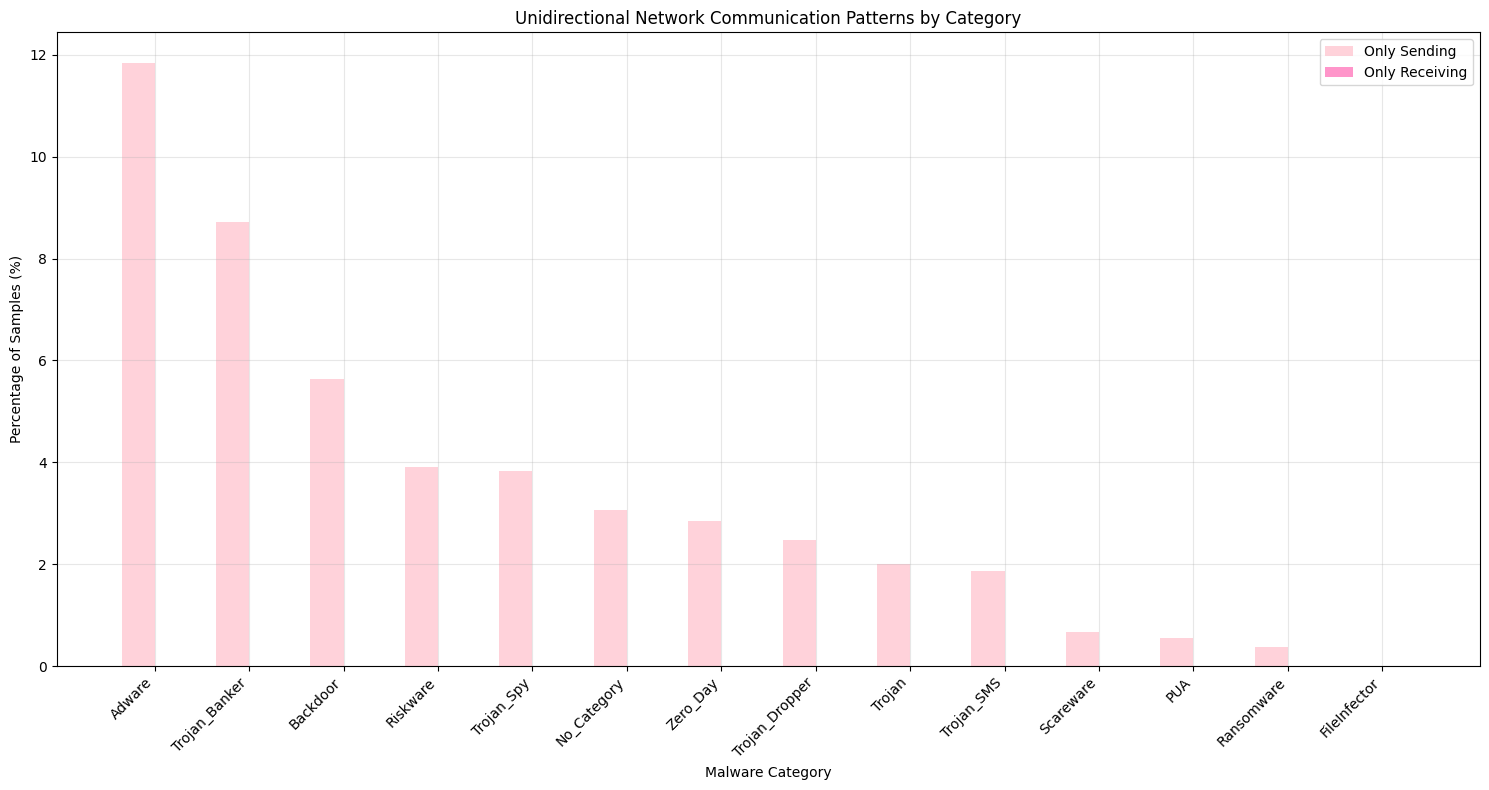

In [56]:
# Create grouped bar plot
plt.figure(figsize=(15, 8))
x = np.arange(len(stats_df))
width = 0.35

plt.bar(x - width/2, stats_df['Only_Sending_Percentage'], width, 
        label='Only Sending', color='pink', alpha=0.7)
plt.bar(x + width/2, stats_df['Only_Receiving_Percentage'], width, 
        label='Only Receiving', color='hotpink', alpha=0.7)

plt.xlabel('Malware Category')
plt.ylabel('Percentage of Samples (%)')
plt.title('Unidirectional Network Communication Patterns by Category')
plt.xticks(x, stats_df['Category'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [57]:
# Additional analysis: Look at the actual amounts of data for unidirectional communications
print("\nAverage Data Volumes in Unidirectional Communications:")

# For sending-only samples
sending_volumes = df[only_sending_mask].groupby('Category').agg({
    'Network_TotalTransmittedBytes': 'mean',
    'Network_TotalTransmittedPackets': 'mean'
}).round(2)

print("\nAverage volumes for sending-only samples:")
print(sending_volumes.sort_values('Network_TotalTransmittedBytes', ascending=False))

# For receiving-only samples
receiving_volumes = df[only_receiving_mask].groupby('Category').agg({
    'Network_TotalReceivedBytes': 'mean',
    'Network_TotalReceivedPackets': 'mean'
}).round(2)

print("\nAverage volumes for receiving-only samples:")
print(receiving_volumes.sort_values('Network_TotalReceivedBytes', ascending=False))



Average Data Volumes in Unidirectional Communications:

Average volumes for sending-only samples:
                Network_TotalTransmittedBytes  Network_TotalTransmittedPackets
Category                                                                      
Trojan_Spy                           11125.76                           181.71
Riskware                              8485.03                           141.42
No_Category                           5513.90                            91.90
Zero_Day                              5181.73                            85.20
Trojan_Dropper                        4603.08                            76.72
Adware                                4530.71                            75.02
Trojan_Banker                         4168.52                            69.10
Trojan_SMS                            4013.50                            53.78
Ransomware                            3242.77                            45.31
Trojan                          

Even though only a small portion of samples (4.68%) showed send only behavior, the fact that it’s most common in Adware, Trojan_Banker, and Backdoor isn’t surprising. These are the kinds of malware that usually need to push data out, whether it’s ads, stolen login details, or system information. 

What stood out more was that no malware was found to be receive only, which suggests most threats don’t just sit and wait for commands, they’re usually the ones reaching out. 

Also, while Trojan_Spy and Riskware didn’t have the highest counts for total_samples, the ones that did send only traffic were sending much larger volumes (As seen in Average volumes for sending-only samples). That points to more intentional, stealthy behavior, like stealing chunks of data quietly instead of just pinging a server.

### Combined behavior

Hypothesis: 

Looking at network behavior alone might miss important signs of malware. Some malware might not talk to the network much but could still be doing shady stuff in memory or through system calls. On the other hand, malware that does use the network a lot might also be more active in other areas. So combining different kinds of behavioral data could give a much clearer picture of what’s actually going on.

In [58]:
def identify_dormant_malware(df):
    """Check if samples with no network activity are completely dormant across all features."""
    network_features = [
        'Network_TotalReceivedBytes',
        'Network_TotalReceivedPackets',
        'Network_TotalTransmittedBytes',
        'Network_TotalTransmittedPackets'
    ]
    
    # Get all feature columns except Category and Reboot
    all_features = [col for col in df.columns if col not in ['Category', 'Reboot']]
    
    # Get samples with zero network activity
    network_zeros = df[network_features].sum(axis=1) == 0
    # Check if these samples have zero activity across all features
    complete_zeros = df[all_features].sum(axis=1) == 0
    
    dormant_samples = df[network_zeros & complete_zeros]
    return dormant_samples[['Category'] + all_features]

In [59]:
dormant = identify_dormant_malware(default_pipeline.dataset.df)
print(f"Found {len(dormant)} completely dormant samples")
display(dormant)

Found 0 completely dormant samples


,Category,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total


### Packets per ratio 

Hypothesis

The amount of data sent per packet can tell us a lot about what the malware is doing. For example, if it's sending lots of tiny packets, it might be pinging a server repeatedly. On the other hand, large packets could mean it’s uploading stolen data or downloading a payload. 

Different types of malware might have their own "signature" when it comes to how much data they send per packet. For example, spyware or banking trojans might send fewer but larger packets because they're exfiltrating specific chunks of sensitive data, while adware might generate lots of small packets through constant background communication for ad loading or tracking. 

By looking at how the bytes-per-packet ratio varies across categories, we might be able to use it as a feature that helps distinguish between things like adware, ransomware, and backdoors.

In [60]:
def calculate_bytes_per_packet(bytes_col, packets_col):
    # Avoid division by zero by masking where packets > 0
    mask = packets_col > 0
    bytes_per_packet = pd.Series(np.nan, index=bytes_col.index)
    bytes_per_packet[mask] = bytes_col[mask] / packets_col[mask]
    return bytes_per_packet

In [61]:
# Calculate received and transmitted bytes per packet
received_bytes_per_packet = calculate_bytes_per_packet(
    df['Network_TotalReceivedBytes'], 
    df['Network_TotalReceivedPackets']
)

transmitted_bytes_per_packet = calculate_bytes_per_packet(
    df['Network_TotalTransmittedBytes'], 
    df['Network_TotalTransmittedPackets']
)

analysis_df = pd.DataFrame({
    'Category': df['Category'],
    'Received_Bytes_Per_Packet': received_bytes_per_packet,
    'Transmitted_Bytes_Per_Packet': transmitted_bytes_per_packet
})

In [62]:
print("Bytes per packet statistics:")
bpp_stats = analysis_df[['Received_Bytes_Per_Packet', 'Transmitted_Bytes_Per_Packet']].describe()
display(bpp_stats)

Bytes per packet statistics:


,Received_Bytes_Per_Packet,Transmitted_Bytes_Per_Packet
count,32329.000000,34829.000000
mean,345.830169,160.739097
std,380.036140,143.491372
min,40.000000,40.027154
25%,112.758621,73.820611
50%,166.384615,108.140845
75%,397.823576,171.937500
max,6322.743352,1274.444376


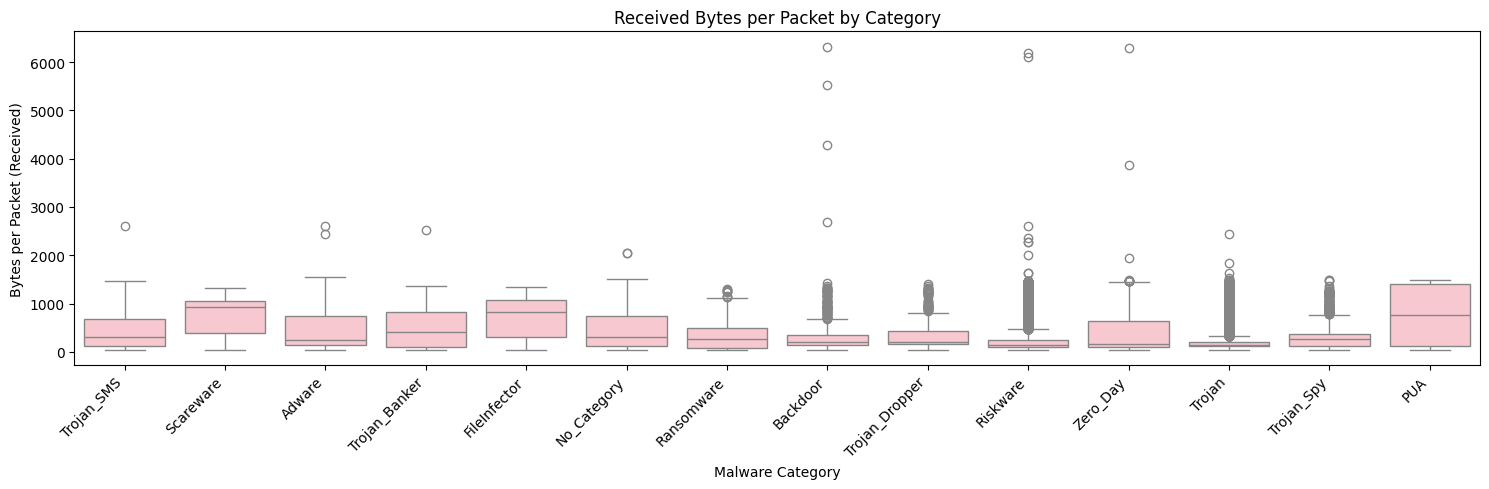

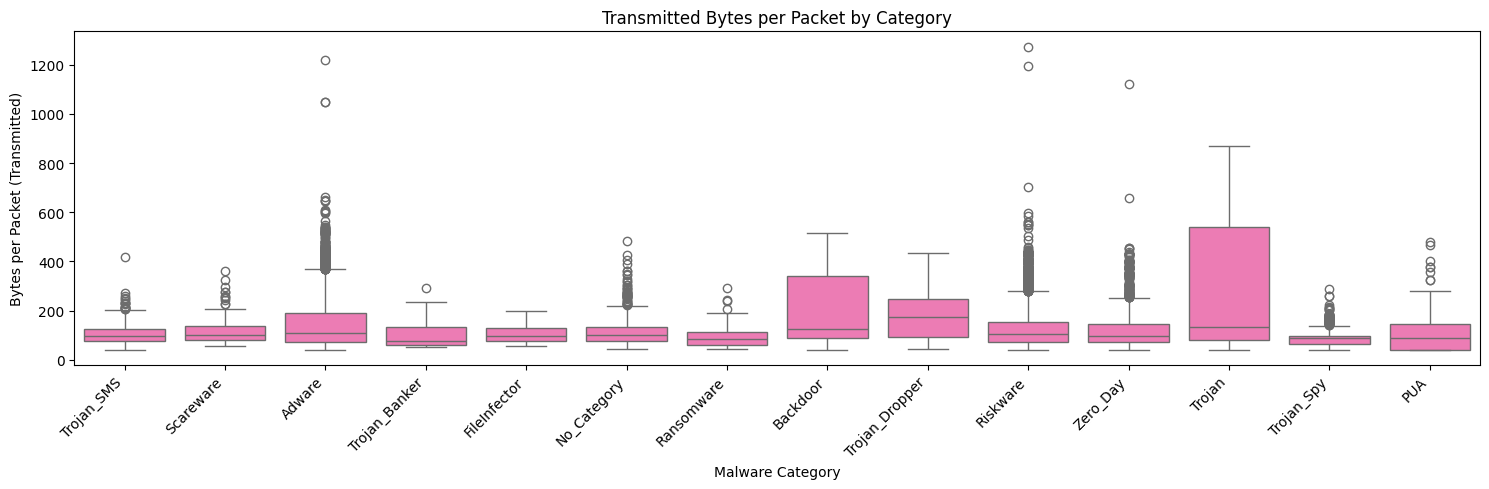

In [63]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=analysis_df, x='Category', y='Received_Bytes_Per_Packet', color='pink')
plt.xticks(rotation=45, ha='right')
plt.title('Received Bytes per Packet by Category')
plt.xlabel('Malware Category')
plt.ylabel('Bytes per Packet (Received)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(data=analysis_df, x='Category', y='Transmitted_Bytes_Per_Packet', color='hotpink')
plt.xticks(rotation=45, ha='right')
plt.title('Transmitted Bytes per Packet by Category')
plt.xlabel('Malware Category')
plt.ylabel('Bytes per Packet (Transmitted)')
plt.tight_layout()
plt.show()

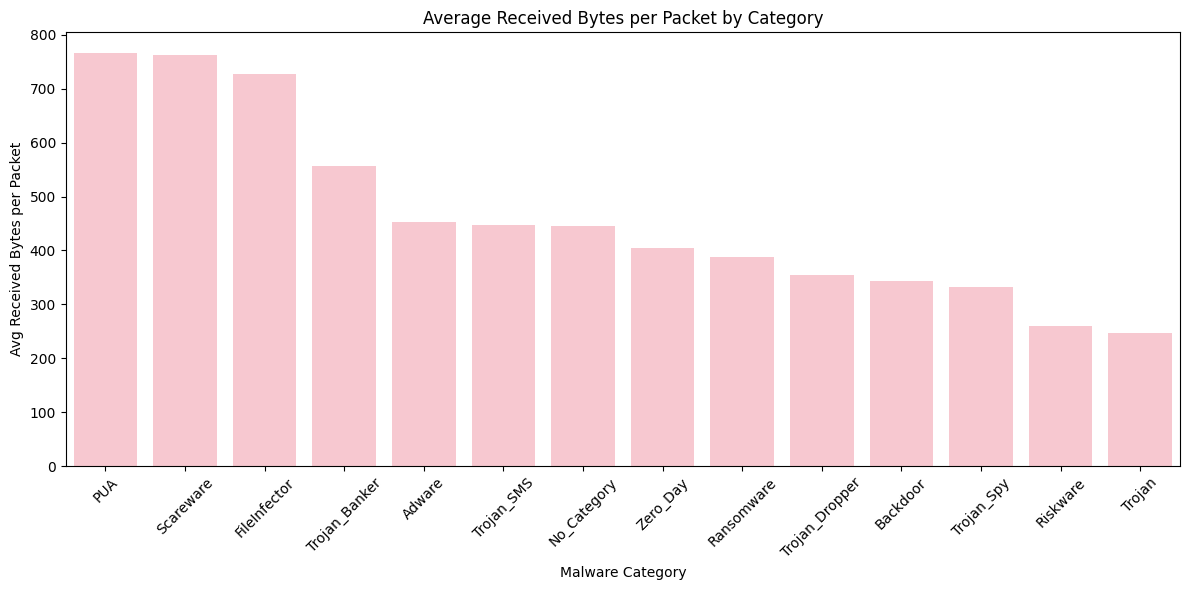

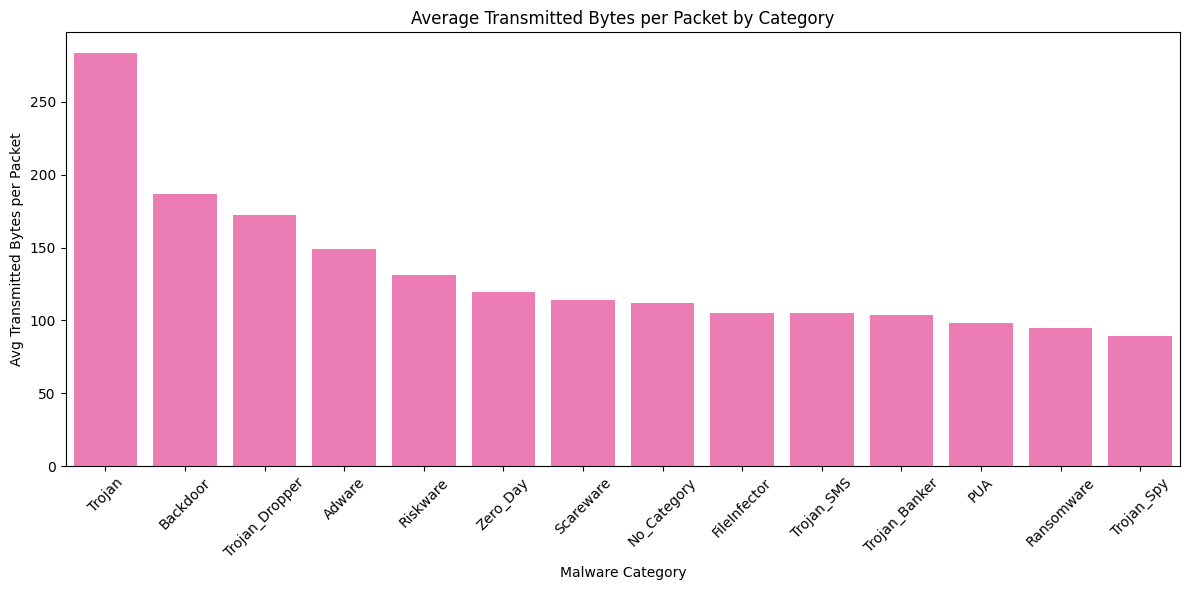

In [64]:
avg_by_category = analysis_df.groupby('Category')[['Received_Bytes_Per_Packet', 'Transmitted_Bytes_Per_Packet']].mean().reset_index()
avg_by_category = avg_by_category.sort_values('Received_Bytes_Per_Packet', ascending=False)

# 6. Bar plot for average RX bytes per packet
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Received_Bytes_Per_Packet', data=avg_by_category, 
           order=avg_by_category['Category'], color='pink')
plt.title('Average Received Bytes per Packet by Category')
plt.xlabel('Malware Category')
plt.ylabel('Avg Received Bytes per Packet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Bar plot for average TX bytes per packet
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Transmitted_Bytes_Per_Packet', data=avg_by_category, 
           order=avg_by_category.sort_values('Transmitted_Bytes_Per_Packet', ascending=False)['Category'], 
           color='hotpink')
plt.title('Average Transmitted Bytes per Packet by Category')
plt.xlabel('Malware Category')
plt.ylabel('Avg Transmitted Bytes per Packet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
# Count samples with unusually large or small bytes per packet
rx_mean, rx_std = analysis_df['Received_Bytes_Per_Packet'].mean(), analysis_df['Received_Bytes_Per_Packet'].std()
tx_mean, tx_std = analysis_df['Transmitted_Bytes_Per_Packet'].mean(), analysis_df['Transmitted_Bytes_Per_Packet'].std()

large_rx = analysis_df[analysis_df['Received_Bytes_Per_Packet'] > rx_mean + 2*rx_std]
large_tx = analysis_df[analysis_df['Transmitted_Bytes_Per_Packet'] > tx_mean + 2*tx_std]

print(f"Samples with unusually large Received bytes per packet (>2 std): {len(large_rx)}")
print(f"Samples with unusually large Transmitted bytes per packet (>2 std): {len(large_tx)}")

# Category distribution for samples with extreme bytes per packet
if len(large_rx) > 0:
    print("\nCategory distribution for samples with large Rreceived bytes per packet:")
    display(large_rx['Category'].value_counts())

if len(large_tx) > 0:
    print("\nCategory distribution for samples with large Transmitted bytes per packet:")
    display(large_tx['Category'].value_counts())

# Remove the dataframe copy to free memory
del analysis_df

Samples with unusually large Received bytes per packet (>2 std): 2425
Samples with unusually large Transmitted bytes per packet (>2 std): 2033

Category distribution for samples with large Rreceived bytes per packet:


Category
Adware            766
Riskware          550
Zero_Day          298
PUA               294
Trojan            195
No_Category        86
Trojan_SMS         67
Trojan_Spy         50
Scareware          36
Backdoor           27
Trojan_Dropper     25
FileInfector       13
Trojan_Banker       9
Ransomware          9
Name: count, dtype: int64


Category distribution for samples with large Transmitted bytes per packet:


Category
Trojan         1942
Adware           67
Riskware         15
Zero_Day          5
PUA               2
Backdoor          1
No_Category       1
Name: count, dtype: int64

On one hand, PUA, Scareware, and FileInfector had the highest average in received bytes per packet, which could mean they download larger chunks of data at once, like pulling down a payload. 

On the other hand, when it comes to sending data, Trojan  dominates, making up almost all of the samples with large transmitted packets. That kind of pattern is typical of data exfiltration, where malware gathers sensitive information (like credentials, messages, or files) and sends it out in fewer but larger packets, instead of lots of small messages. This helps it fly under the radar by reducing the number of connections, which could otherwise get flagged.

Adware and Riskware showed up on both sides, but with much smaller packet sizes, which fits with their typical behavior of sending out lots of lightweight requests, probably for ads or background activity. 

Overall, the bytes-per-packet ratio really seems to reflect what the malware is actually trying to do.


### Total Network Activity Score

Hypothesis:

Different types of malware probably have different "loudness" levels when it comes to network traffic. For example, adware might constantly send and receive data for ads, while something like ransomware might only make a quick connection to get a key. So looking at the total amount of network activity might help us tell apart different malware types, or at least help flag the really noisy ones.

Goal: Rank samples and categories by their overall network intensity.
Code:

Sum of all 4 network metrics per row 



In [66]:
def calculate_total_network_activity(df):
    """
    Calculate total network activity by summing all network metrics.
    Returns a new DataFrame with the total activity and category.
    """
    network_features = [
        'Network_TotalReceivedBytes',
        'Network_TotalReceivedPackets',
        'Network_TotalTransmittedBytes',
        'Network_TotalTransmittedPackets'
    ]
    
    # Create a new DataFrame with just Category and total activity
    activity_df = pd.DataFrame()
    activity_df['Category'] = df['Category']
    activity_df['Total_Network_Activity'] = df[network_features].sum(axis=1)
    
    return activity_df

In [67]:
activity_df = calculate_total_network_activity(default_pipeline.dataset.df)
display(activity_df)

,Category,Total_Network_Activity
0,Trojan_SMS,0
1,Trojan_SMS,17203
2,Trojan_SMS,191458
3,Trojan_SMS,0
4,Trojan_SMS,0
...,...,...
53434,PUA,14591
53435,PUA,0
53436,PUA,0
53437,PUA,0


In [68]:
top_samples = activity_df.sort_values(by='Total_Network_Activity', ascending=False).head(10)
print("Top 10 Most Network-Intensive Samples:")
display(top_samples)

Top 10 Most Network-Intensive Samples:


,Category,Total_Network_Activity
52978,PUA,235602190
52292,PUA,234915229
52184,PUA,231983704
52461,PUA,231642531
45510,Trojan,231528241
53013,PUA,230666899
52952,PUA,217883216
53424,PUA,215045371
52207,PUA,211397184
52846,PUA,209601597


In [69]:
category_avg = activity_df.groupby('Category')['Total_Network_Activity'].mean().sort_values(ascending=False)
print("\nAverage Total Network Activity by Category:")
display(category_avg)



Average Total Network Activity by Category:


Category
PUA               2.625382e+07
Zero_Day          8.939281e+05
Trojan            7.854047e+05
FileInfector      4.701135e+05
Adware            4.604110e+05
Trojan_SMS        4.396528e+05
Trojan_Dropper    4.022314e+05
Scareware         3.530584e+05
Backdoor          3.185157e+05
No_Category       3.140995e+05
Riskware          3.071464e+05
Trojan_Spy        1.000736e+05
Trojan_Banker     6.280614e+04
Ransomware        1.807389e+04
Name: Total_Network_Activity, dtype: float64

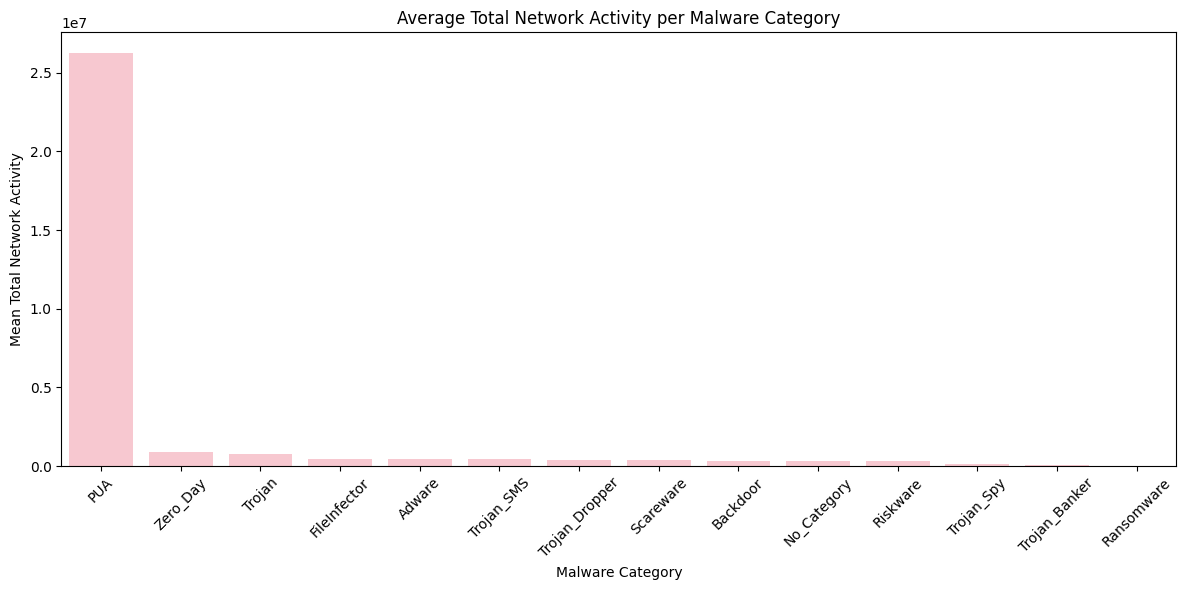

In [70]:
plt.figure(figsize=(12, 6))
sns.barplot(x=category_avg.index, y=category_avg.values, color='pink')
plt.title('Average Total Network Activity per Malware Category')
plt.xlabel('Malware Category')
plt.ylabel('Mean Total Network Activity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There’s a massive difference in total network activity across malware types, with PUA standing out as the loudest by far. On average, it generates over 26 million bytes of traffic per sample, which is way more than any other category. In fact, it almost completely dominates the top 10 most network intensive samples. This kind of behavior probably comes from constantly pulling ads, sending telemetry, or doing background communication. 

On the other hand, malware like Ransomware, Trojan_Banker, and Trojan_Spy are much quieter. These types seem to keep network activity minimal, likely because they don’t need to constantly talk to a server, they just connect once or twice to fetch a key or send stolen data. 

So just by looking at how "loud" a sample is on the network, we can already get an idea of what kind of malware it might be.

## Battery

Features: 

Battery_wakelock: Tracks wake lock usage. 

Wavelock: mechanism that keeps the device CPU active even if the screen is turned off or the device is in a low-power state. When an app wants to keep the device awake for a specific period, it acquires a wake lock to then release it when no longer needed. However, when a wakelock is held for an extended period, it prevents the device from entering a deep sleep state, which drains the battery.

Malware may abuse wakelocks to keep the device awake for tasks like:

Persistent network communication (e.g., beaconing or data exfiltration), background monitoring or spying, draining the battery deliberately.

High or frequent wakelock usage might suggest long-running background activity, which could be indicative of malware trying to stay active undetected.

Battery_service: measures interactions with battery-related Android system services, like monitoring battery state, registering for battery events (charging, discharging, low battery)

Certain malware may monitor the system’s power status to decide when to execute payloads or avoid draining the battery, which might alert the user.

### Wakelocks usage 

Hypothesis:

Malware that needs to stay active in the background may abuse wakelocks to keep the device’s CPU awake. This allows them to continue operations like listening for events, uploading stolen data, or showing ads, even when the user isn’t using the device. 

<Axes: xlabel='Category'>

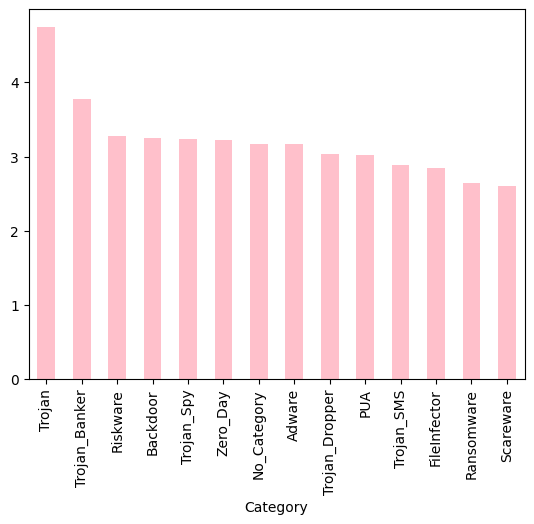

In [71]:
df.groupby('Category')['Battery_wakelock'].mean().sort_values(ascending=False).plot(kind='bar', color='pink')

On average, Trojans hold the most wakelocks, which might mean they’re staying active in the background for longer, maybe to keep sending data, wait for instructions, or just avoid going to sleep. Bankers and Riskware aren’t far behind. 
On the other hand, malware like Ransomware and Scareware barely use wakelocks at all, these types often execute quickly and don’t need to remain active long. This kind of pattern suggests wakelock usage could be a useful signal for spotting malware that tries to stick around silently.


### Battery interaction

Hypothesis:

Some malware categories may interact with battery related system services to time their actions and avoid detection. For example, they may wait until the device is charging or has sufficient battery before executing a heavy payload to avoid detection or/and ensure successful execution. 

<Axes: xlabel='Category'>

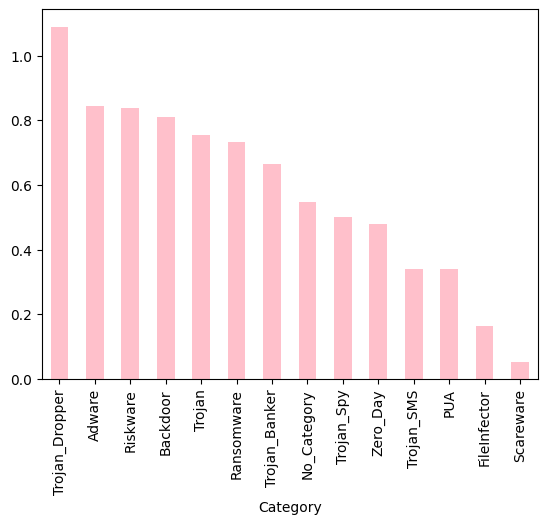

In [72]:
df.groupby('Category')['Battery_service'].mean().sort_values(ascending=False).plot(kind='bar', color='pink')


Trojan_Dropper, Adware, and Riskware show the highest battery service access, suggesting they might be monitoring power status as part of their execution logic. This could mean they’re trying to stay hidden (by avoiding execution while charging for example), or optimizing for long-running background behavior. In contrast, Scareware and FileInfector barely use battery services at all, which indicate they’re short attacks and don’t need to track system conditions. So, high battery service usage could be a clue that the malware is more “aware” of the device’s state and trying to adapt its behavior accordingly.

### Combined effect

The reason battery wakelock usage and battery service access are not the same across malware categories is because they have different underlying meanings. 

Wakelocks are used to keep the device awake, which means the malware that wants to stay active in the background, like constantly running, sending data, or maintaining a connection. 

On the other hand, battery service usage is more about awareness, the malware is checking the device’s power state to decide when or whether to act. 

So while wakelocks are about persistence, battery service access is more about stealth or timing.

High wakelock & high battery service: Stealthy but persistent - long-running and context-aware

High wakelock & low battery service: Persistent — doesn’t care about battery state, just stays on

Low wakelock & high battery service: Stealthy — checks system state but avoids staying awake

Low wakelock & low battery service: Quick or inactive — does its thing fast or waits quietly

The classification will now be done based on whether each malware category’s average Battery_wakelock and Battery_service values are above or below the overall median across all samples, placing them into one of four behavioral profiles that reflect different levels of persistence and system awareness.

In [73]:
# Step 1: Compute average wakelock and battery service usage by malware category
avg_battery_usage = df.groupby('Category')[['Battery_wakelock', 'Battery_service']].mean()

# Step 2: Define thresholds using the overall medians
wakelock_median = df['Battery_wakelock'].median()
service_median = df['Battery_service'].median()

# Step 3: Classification logic into four behavior types
def classify_behavior(row):
    if row['Battery_wakelock'] > wakelock_median and row['Battery_service'] > service_median:
        return 'High Wakelock + High Service'
    elif row['Battery_wakelock'] > wakelock_median:
        return 'High Wakelock + Low Service'
    elif row['Battery_service'] > service_median:
        return 'Low Wakelock + High Service'
    else:
        return 'Low Wakelock + Low Service'

# Step 4: Apply classification
avg_battery_usage['Battery_Behavior_Type'] = avg_battery_usage.apply(classify_behavior, axis=1)

# Step 5: Group categories by their behavior type - Fix the deprecation warning
behavior_groups = {}
for behavior_type, group_df in avg_battery_usage.groupby('Battery_Behavior_Type'):
    behavior_groups[behavior_type] = list(group_df.index)

# Step 6: Display results
for behavior, categories in behavior_groups.items():
    print(f"\n{behavior}:")
    for cat in categories:
        print(f" - {cat}")


High Wakelock + High Service:
 - Adware
 - Backdoor
 - No_Category
 - PUA
 - Riskware
 - Trojan
 - Trojan_Banker
 - Trojan_Dropper
 - Trojan_Spy
 - Zero_Day

Low Wakelock + High Service:
 - FileInfector
 - Ransomware
 - Scareware
 - Trojan_SMS


### Outliers

High Battery Feature Samples (Outlier Analysis)

Filter top 5% of samples with the highest Battery_wakelock or Battery_service

Group by Category and count


## Process

Process_total: Tracks total active processes (Actively executing)

Higher values could indicate:

Malware spawning many child processes 

Attempts at evasion or persistence, like breaking into smaller threads

Abusive use of the system

Lower values may reflect:

Silent or dormant behavior

Lightweight payloads that don’t fork or persist

### Relationship Between API Usage and Active Process Count

In [74]:
df = default_pipeline.dataset.df
process_cols = [col for col in df.columns if any(term in col.lower() for term in 
                ['process', 'proc'])]

print(f"Found {len(process_cols)} process-related columns:")
print(process_cols)

Found 5 process-related columns:
['API_Process_android.os.Process_start', 'API_Process_android.app.ActivityManager_killBackgroundProcesses', 'API_Process_android.os.Process_killProcess', 'API_Command_java.lang.ProcessBuilder_start', 'Process_total']


There are four API specific features that involve the creation and kill of processes. In this section we check whether the number of active processes reflect how often the app starts or kills processes. In other words, whether process_total can be rebuilt from API behavior.

The four mentioned features are:

API_Process_android.os.Process_start: an app starts a new process. Most likely increases process_total.

API_Process_android.app.ActivityManager_killBackgroundProcesses: An app terminates background processes. Most likely decreases process_total.

API_Process_android.os.Process_killProcess: an app kills a specific process by its PID. Most likely decreases process_total.

API_Command_java.lang.ProcessBuilder_start: Starts a new process using ProcessBuilder. This provides a more flexible way to control and manage a process, useful when you want to perform complex system commands. Most likely increases process_total.



In [75]:
# List of process-related API/command features
process_api_features = [
    'API_Process_android.os.Process_start',
    'API_Process_android.app.ActivityManager_killBackgroundProcesses',
    'API_Process_android.os.Process_killProcess',
    'API_Command_java.lang.ProcessBuilder_start'
]

# Correlation with Process_total
corr_df = df[['Process_total'] + process_api_features].corr()
process_corrs = corr_df['Process_total'].drop('Process_total').sort_values(ascending=False)

print("Correlation of Process_total with process-related APIs/commands:")
print(process_corrs)


Correlation of Process_total with process-related APIs/commands:
API_Process_android.app.ActivityManager_killBackgroundProcesses    0.005946
API_Process_android.os.Process_killProcess                         0.000013
API_Command_java.lang.ProcessBuilder_start                        -0.021609
API_Process_android.os.Process_start                                    NaN
Name: Process_total, dtype: float64


The correlation between Process_total and process-related API usage is surprisingly weak. None of the APIs showed any strong relationship, most correlation values are very close to zero, and one is even negative. ProcessBuilder.start commonly used to start new processes, had slight negative correlation (−0.02). This suggests that the total number of active processes isn’t directly explained by how often these specific APIs are used.

### Stealth vs. Active Malware

Hypothesis:

Some malware might rely on creating multiple processes to execute different stages of its attack. At the same time, other types of malware may prioritize stealth. Malware that focuses on staying hidden is likely to keep its number of active processes as low as possible to avoid detection. Instead of creating multiple visible subprocesses, it might run as a single, quiet background task.

In [76]:
df = default_pipeline.dataset.df.copy()
print("Basic statistics for process_total:")
display(df['Process_total'].describe())

Basic statistics for process_total:


count    53439.000000
mean       190.167181
std          2.902841
min        172.000000
25%        188.000000
50%        190.000000
75%        192.000000
max        226.000000
Name: Process_total, dtype: float64

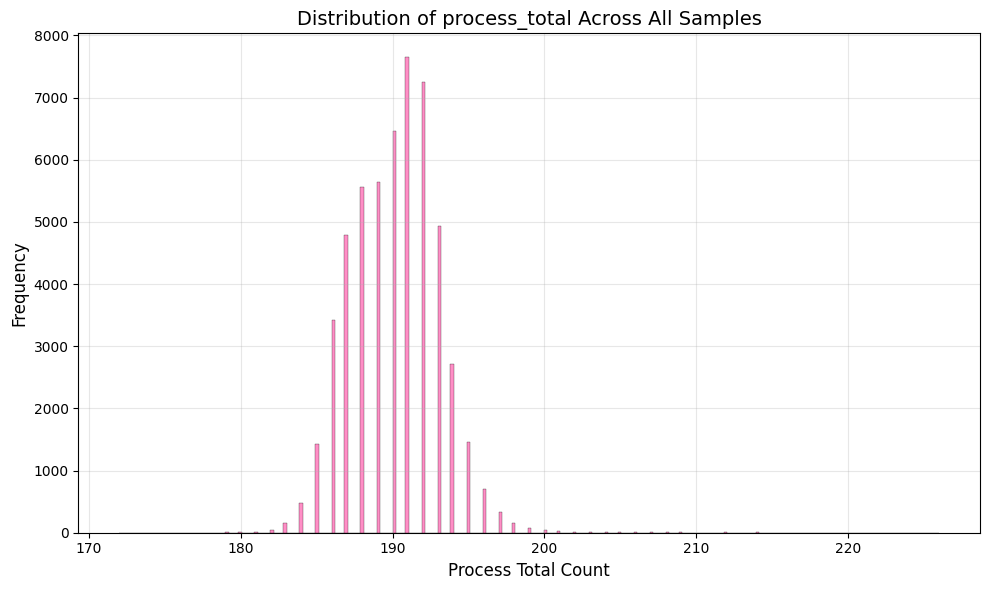

In [77]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Process_total'], color='hotpink')
plt.title('Distribution of process_total Across All Samples', fontsize=14)
plt.xlabel('Process Total Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [78]:
category_col = 'Category'  
category_stats = df.groupby(category_col)['Process_total'].agg(['mean', 'median', 'std', 'count'])
category_stats = category_stats.sort_values('mean', ascending=False)

print("\nProcess total statistics by category:")
display(category_stats)


Process total statistics by category:


,mean,median,std,count
Category,,,,
Scareware,191.198646,191.0,2.484537,886
Trojan_Banker,191.012448,191.0,2.659075,241
No_Category,190.960663,191.0,3.042510,1932
Trojan_Spy,190.748944,191.0,2.640087,2840
Trojan_SMS,190.668901,191.0,2.986851,1939
FileInfector,190.612903,191.0,2.636430,248
Adware,190.500364,191.0,2.995017,10980
Trojan_Dropper,190.406369,190.0,2.037685,1570
Backdoor,190.358839,190.0,2.534202,1137


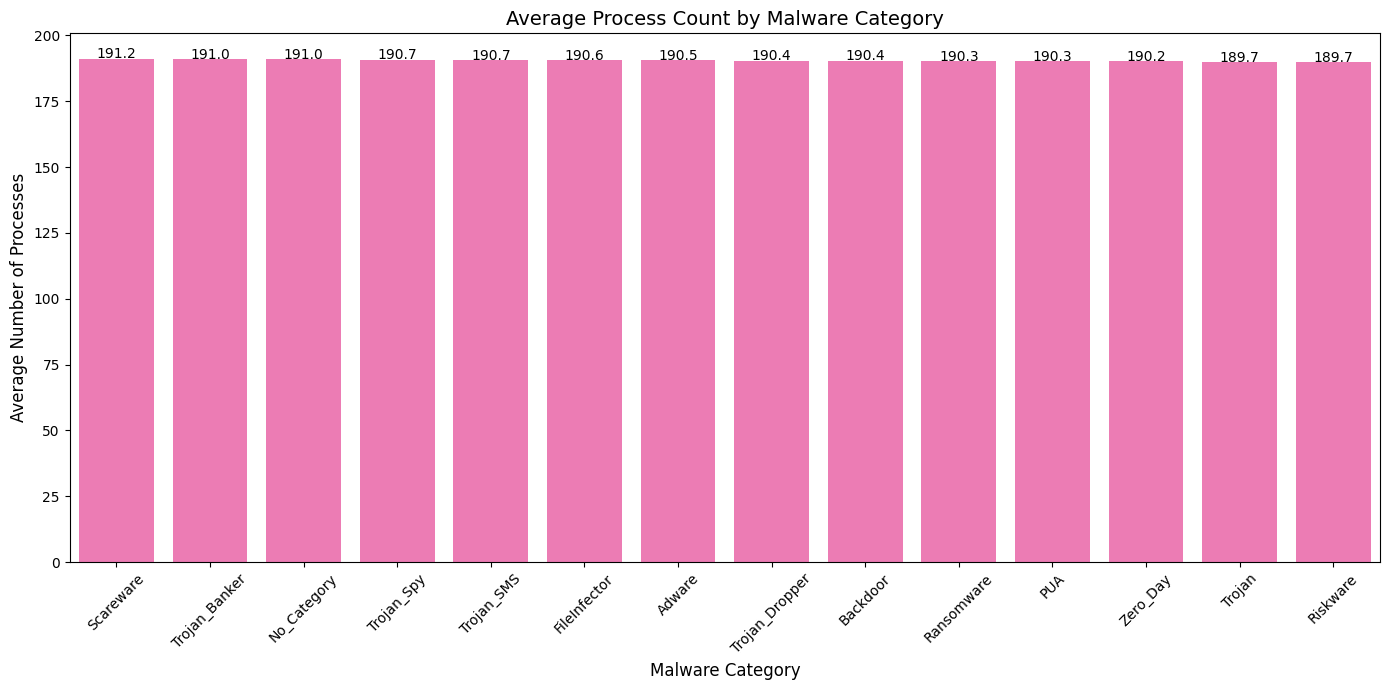

In [79]:
# Average processes by category
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=category_stats.index, y=category_stats['mean'], 
                order=category_stats.index, color='hotpink')
plt.title('Average Process Count by Malware Category', fontsize=14)
plt.ylabel('Average Number of Processes', fontsize=12)
plt.xlabel('Malware Category', fontsize=12)
plt.xticks(rotation=45)

# Add mean values as text labels
for i, v in enumerate(category_stats['mean']):
    ax.text(i, v + 0.1, f"{v:.1f}", ha='center')

plt.tight_layout()
plt.show()

Despite the hypothesis, the number of active processes looks almost the same across all malware categories. Most averages cluster around 190, with very little spread, the standard deviation is just under 3. This suggests that Process_total might not be influenced by malware behavior.

### Trigger-Based Activation

Hypothesis:

Some malware may lie dormant before reboot and only become active (spawning processes) after reboot, as part of a sandbox evasion strategy.

In [80]:
copy = default_pipeline.dataset.df.copy()

# mean Process_total for each category and reboot state
pivot = copy.pivot_table(
    values='Process_total',
    index='Category',
    columns='Reboot',
    aggfunc='mean'
)

pivot['difference'] = pivot['after'] - pivot['before']
pivot = pivot.sort_values('difference', ascending=False)
print("Process count comparison before vs after reboot:")
display(pivot)


Process count comparison before vs after reboot:


Reboot,after,before,difference
Category,,,
Trojan,191.834286,187.800771,4.033515
Riskware,191.767373,187.782812,3.984561
Adware,192.523921,188.718054,3.805867
Zero_Day,192.123486,188.343066,3.780420
Trojan_SMS,192.558727,188.994163,3.564563
FileInfector,192.277311,189.077519,3.199792
Scareware,192.768868,189.757576,3.011292
Trojan_Spy,192.617902,189.670738,2.947163
Ransomware,191.886452,188.969909,2.916543


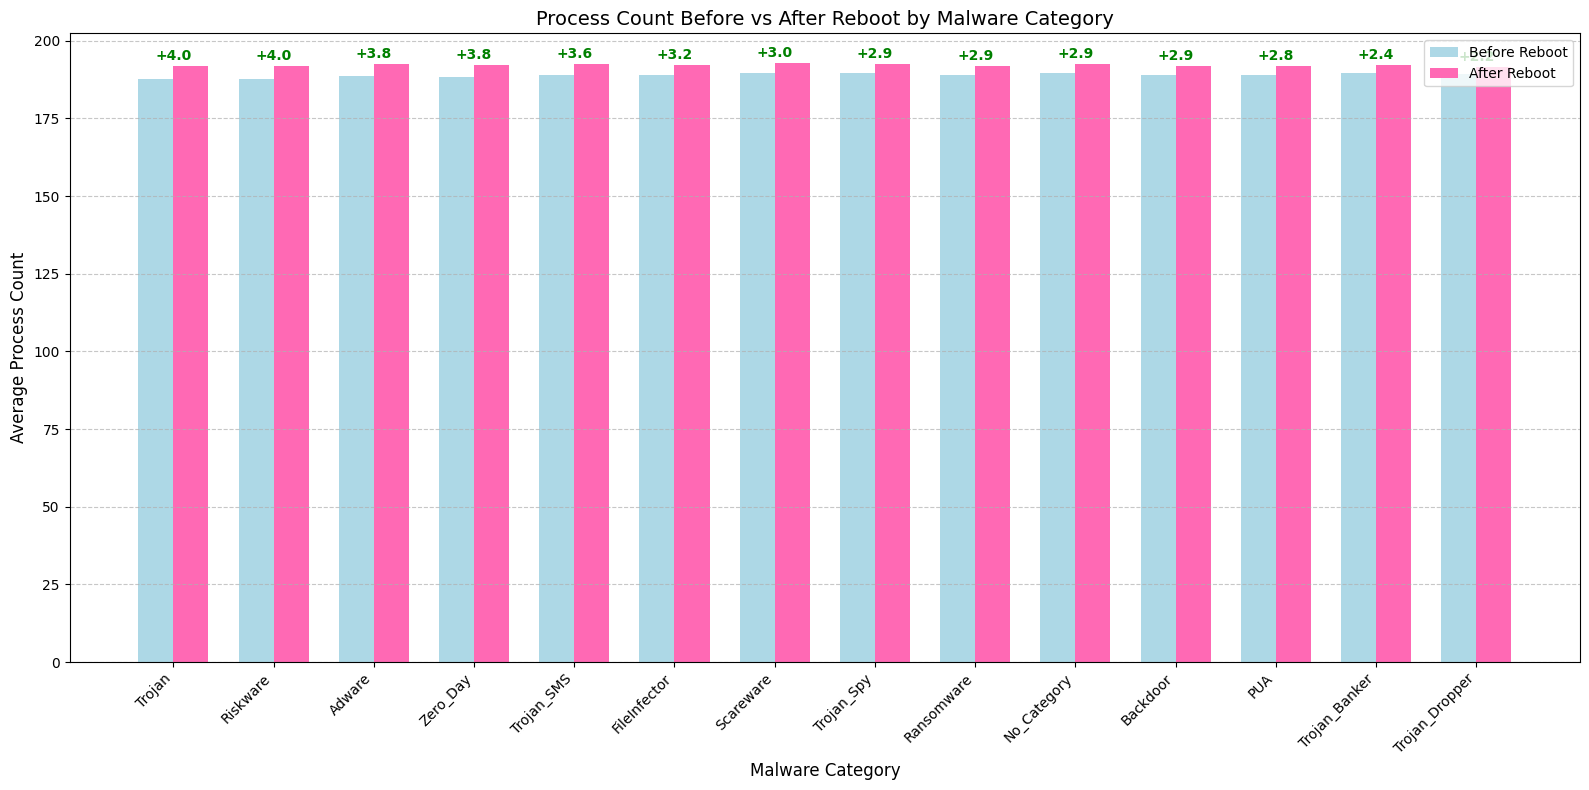

In [81]:
# Create a grouped bar chart
plt.figure(figsize=(16, 8))

# Set width of bars
barWidth = 0.35
r1 = np.arange(len(pivot.index))
r2 = [x + barWidth for x in r1]

# Create bars
plt.bar(r1, pivot['before'], width=barWidth, color='lightblue', label='Before Reboot')
plt.bar(r2, pivot['after'], width=barWidth, color='hotpink', label='After Reboot')

# Add labels and title
plt.xlabel('Malware Category', fontsize=12)
plt.ylabel('Average Process Count', fontsize=12)
plt.title('Process Count Before vs After Reboot by Malware Category', fontsize=14)
plt.xticks([r + barWidth/2 for r in r1], pivot.index, rotation=45, ha='right')
plt.legend()

# Add text annotations for differences
for i, (idx, row) in enumerate(pivot.iterrows()):
    diff = row['difference']
    if not np.isnan(diff):
        color = 'green' if diff > 0 else 'red'
        plt.text(i + barWidth/2, 
                 max(row['before'], row['after']) + 2, 
                 f"{diff:+.1f}", 
                 color=color,
                 ha='center',
                 fontweight='bold')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

There’s a consistent increase in average process count after reboot across all malware categories of about 3 to 4 more processes. While the difference isn’t huge, it’s consistent. However, the effect is too small to confidently attribute it to sandbox evasion.

## Memory (Proportional Set Size)

- outliers
- check the sum

### PSS


PSS refers to the portion of memory that is proportionally assigned to a process, taking into acount shared memory.

Features:
- Memory_PssTotal
- Memory_PssClean
- Memory_SharedDirty
- Memory_PrivateDirty
- Memory_SharedClean
- Memory_PrivateClean
- Memory_SwapPssDirty

Clean vs Dirty:
- Clean: memory pages that hasnt been modified since it was mapped (Example: Libraries)
- Dirty: memory pages that have been modified.

Private vs Shared:
- Private: only available to a process
- Shared: mapped by multiple processes. The most important thing to take into account is that we divide the number of Kb by number of proccesses accessing to it.

Hypothesis:  
If malware is present on a system, it can load code or data into shared memory (e.g., a shared library), which reduces its individual memory footprint. Additionally, malware can inject code into other processes, keeping its own PSS relatively low. This is why PSS alone is likely insufficient for reliably detecting malicious applications.

#### Memory_PssTotal

This is the sum of Memory_PssClean, Memory_sharedDirty and Memory_PrivateDirty (Memory_PssDirty is not a feature). 

In [82]:
default_pipeline.dataset.df['Memory_PssTotal'].describe()

count     53439.000000
mean      70918.399034
std       36366.690217
min        4506.000000
25%       46165.000000
50%       61284.000000
75%       91740.000000
max      829169.000000
Name: Memory_PssTotal, dtype: float64

There is a really high standard deviation. The max value is extremely high. It's more than 10 times the mean. In general we can see a quite high mempry usage.

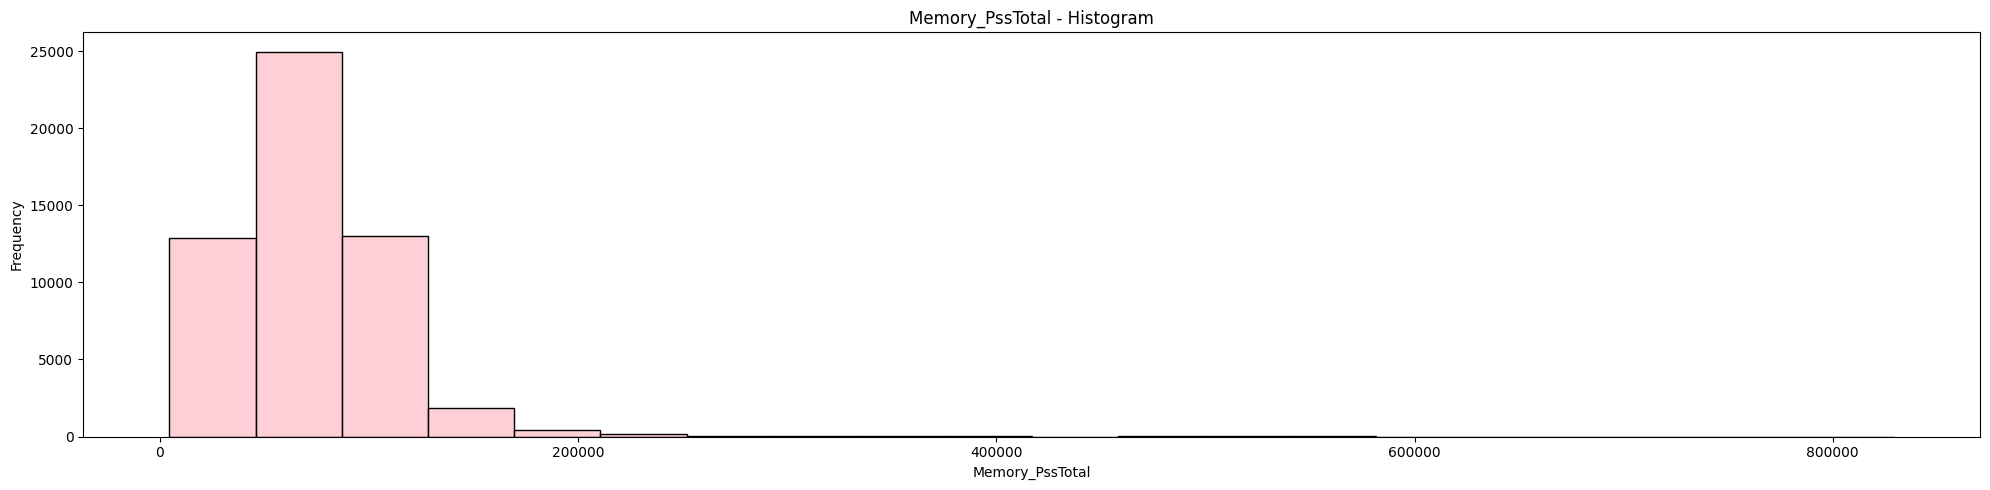

In [83]:
default_pipeline.EDA.plot_histograms(features=["Memory_PssTotal"], n_cols=1, bins=20)

In [84]:
default_pipeline.dataset.df['Memory_PssTotal'].max()

829169

In [85]:
default_pipeline.dataset.df.groupby('Category')['Memory_PssTotal'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,77691.313297,43186.372156,5514.0,47795.75,68345.5,100486.50,819456.0
Backdoor,1137.0,64872.519789,39258.133286,11073.0,43599.00,56469.0,71140.00,624063.0
FileInfector,248.0,74002.084677,32795.806609,23866.0,48291.75,52681.5,95831.75,178637.0
No_Category,1932.0,74386.863872,47941.296109,6028.0,44583.25,63812.5,94133.75,714868.0
PUA,1290.0,66573.948062,43089.788673,9255.0,32788.25,59511.5,81596.50,346117.0
Ransomware,3411.0,54950.799472,17360.548792,6340.0,45842.50,49349.0,58562.00,214365.0
Riskware,14053.0,67867.346261,32394.741622,4808.0,45893.00,60339.0,87167.00,829169.0
Scareware,886.0,88980.173815,26323.681386,13429.0,86004.75,93253.5,99570.75,279678.0
Trojan,8437.0,75164.102169,29651.677461,4506.0,52458.00,73496.0,91806.00,519285.0


It's interesting to note that both Scareware and Adware consume more memory, likely due to the UI activity. While Ransomware and Trojan_spy have relatively low memory consumption, meaning they are more memory efficient.

#### Memory_PssClean

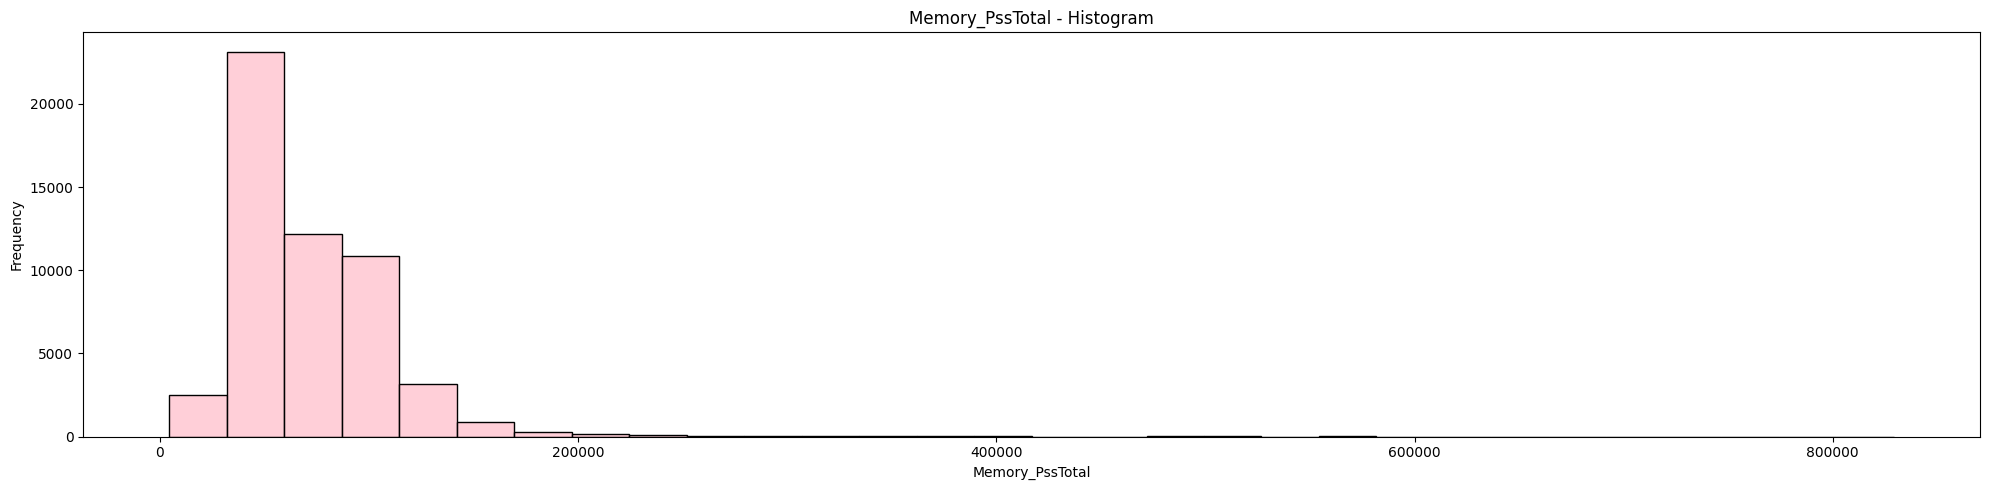

In [86]:
default_pipeline.EDA.plot_histograms(features=["Memory_PssTotal"], n_cols=1)

In [87]:
default_pipeline.dataset.df.groupby('Category')['Memory_PssClean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,15741.613115,14063.508342,0.0,4436.0,8132.0,28520.0,56272.0
Backdoor,1137.0,8961.051891,10868.760200,68.0,3780.0,5060.0,7740.0,102320.0
FileInfector,248.0,16491.806452,15122.073528,0.0,4263.0,5834.0,31208.0,44780.0
No_Category,1932.0,13225.552795,13327.507898,0.0,3267.0,6536.0,22988.0,62708.0
PUA,1290.0,8119.677519,10475.622550,0.0,2265.0,3476.0,7863.0,105164.0
Ransomware,3411.0,5504.368220,5846.970870,0.0,2584.0,4844.0,6252.0,47020.0
Riskware,14053.0,14030.660215,12198.188924,0.0,4780.0,7636.0,24012.0,106360.0
Scareware,886.0,30622.988713,14283.361500,0.0,22470.0,38542.0,40859.0,48364.0
Trojan,8437.0,11913.528031,13163.803987,0.0,4128.0,5344.0,13972.0,78380.0


## API 

The following features are functions from android APIs, which are a set of tools to create and manage Android devices. They let you interact with features such as processes, commands, activities. 

GENERAL EDA NOTE: as soon as the app tries to reach system level configurations we should be sceptical. This is the main pathway for intrusive attacks

Public APIs = intended for developers (normal app developers, malware writers too)

Hidden/Internal APIs = system-level functions not officially exposed to apps (need reflection, NDK, or privileged access)

In [88]:
network_columns = [col for col in default_pipeline.dataset.df.columns if col.startswith("API_")]

for col in network_columns:
    print(f"{col}")

columns_to_display = network_columns + ['Reboot']
display(default_pipeline.dataset.df[columns_to_display].head(10))

API_Process_android.os.Process_start
API_Process_android.app.ActivityManager_killBackgroundProcesses
API_Process_android.os.Process_killProcess
API_Command_java.lang.Runtime_exec
API_Command_java.lang.ProcessBuilder_start
API_JavaNativeInterface_java.lang.Runtime_loadLibrary
API_JavaNativeInterface_java.lang.Runtime_load
API_WebView_android.webkit.WebView_loadUrl
API_WebView_android.webkit.WebView_loadData
API_WebView_android.webkit.WebView_loadDataWithBaseURL
API_WebView_android.webkit.WebView_addJavascriptInterface
API_WebView_android.webkit.WebView_evaluateJavascript
API_WebView_android.webkit.WebView_postUrl
API_WebView_android.webkit.WebView_postWebMessage
API_WebView_android.webkit.WebView_savePassword
API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword
API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword
API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled
API_FileIO_libcore.io.IoBridge_open
API_FileIO_android.content.ContextWrapper_openFileInpu

,API_Process_android.os.Process_start,API_Process_android.app.ActivityManager_killBackgroundProcesses,API_Process_android.os.Process_killProcess,API_Command_java.lang.Runtime_exec,API_Command_java.lang.ProcessBuilder_start,API_JavaNativeInterface_java.lang.Runtime_loadLibrary,API_JavaNativeInterface_java.lang.Runtime_load,API_WebView_android.webkit.WebView_loadUrl,API_WebView_android.webkit.WebView_loadData,API_WebView_android.webkit.WebView_loadDataWithBaseURL,...,API_DeviceData_android.accounts.AccountManager_getAccountsByType,API_DeviceData_android.accounts.AccountManager_getAccounts,API_DeviceData_android.location.Location_getLatitude,API_DeviceData_android.location.Location_getLongitude,API_DeviceData_android.media.AudioRecord_startRecording,API_DeviceData_android.media.MediaRecorder_start,API_DeviceData_android.os.SystemProperties_get,API_DeviceData_android.app.ApplicationPackageManager_getInstalledPackages,API__sessions,Reboot
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,before
1,0,0,0,0,0,0,0,30,0,0,...,0,0,0,0,0,0,6,0,1,before
2,0,0,0,0,0,0,0,43,0,0,...,0,0,0,0,0,0,8,0,1,before
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,58,0,1,before
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,41,0,7,before
5,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,30,0,3,before
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,24,0,24,before
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,0,1,before
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5181,0,6,before
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,0,4,before


### Process Android

API_Process_android.os.Process_start: an app starts a new process. 

API_Process_android.app.ActivityManager_killBackgroundProcesses: An app terminates background processes.

API_Process_android.os.Process_killProcess: an app kills a specific process by its PID

#### os.Process_start

In [89]:
df['API_Process_android.os.Process_start'].describe()

count    53439.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: API_Process_android.os.Process_start, dtype: float64

The start method was not called by any sample during the dynamic analysis. This means that no new process was started by any malware or that the instrumentation used to track this API call did not function correctly.

Malware typically don't use this API call since it is a system-level functions they are not meant for regular app use and requires special permissions that they do not have. This would only make the malware fail and make it easier to detect.

The tool could have been tracking user space behaviour rather than the kernel space where this system call runs.

Other ways to spawning processes could be using the shell command runtime.exec() or by a programmatic process creation like ProcessBuilder.start() which will be analysed in the next section.

As a result, API_Process_android.os.Process_start is not a meaningful feature and should be dropped since it provides no information.


#### app.ActivityManager_killBackgroundProcesses

In [90]:
df['API_Process_android.app.ActivityManager_killBackgroundProcesses'].describe()

count    53439.000000
mean         0.767249
std          9.219923
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        260.000000
Name: API_Process_android.app.ActivityManager_killBackgroundProcesses, dtype: float64

At lease 75% of all samples never use this API indicating a very rare usage.

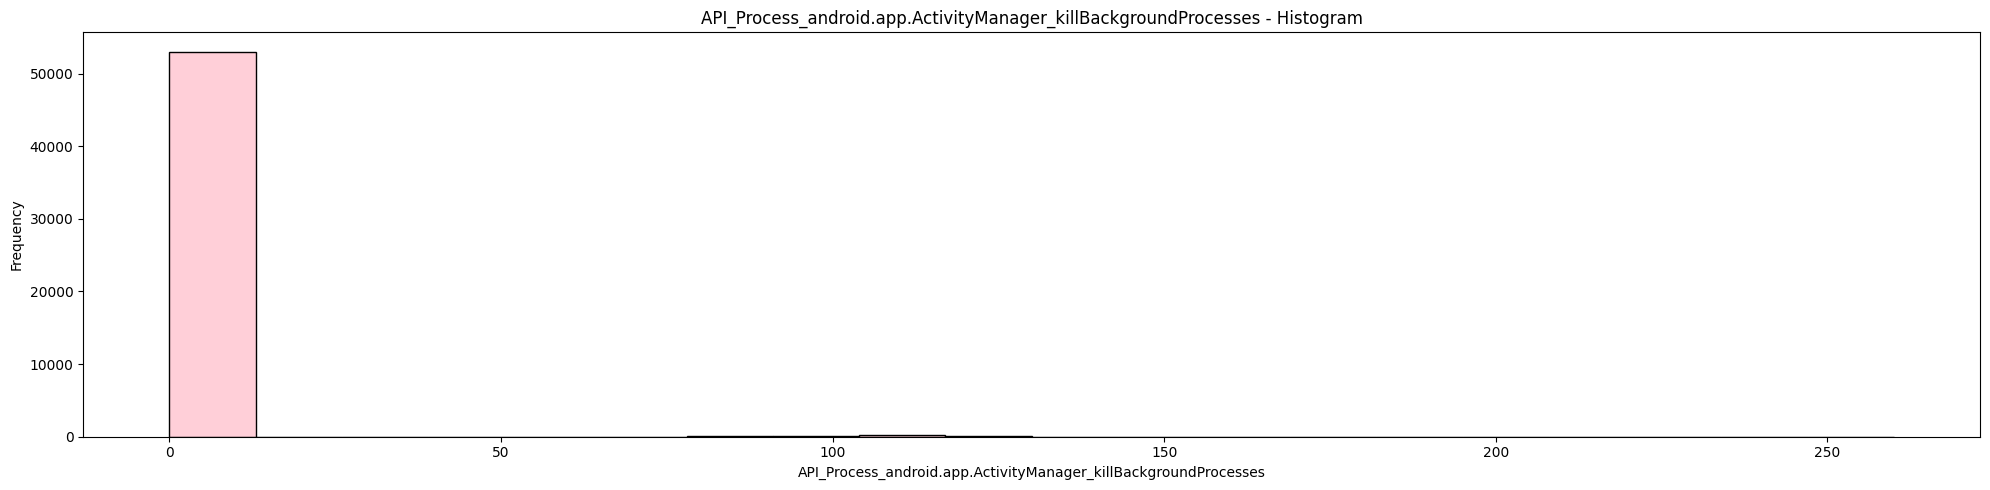

In [91]:
default_pipeline.EDA.plot_histograms(features=["API_Process_android.app.ActivityManager_killBackgroundProcesses"], n_cols=1, bins=20)

The feature is heavily right skewed. Around 50000 samples do not use the API. 

In order to better visualize outliers we will plot the distribution of the feature excluding the zero value.

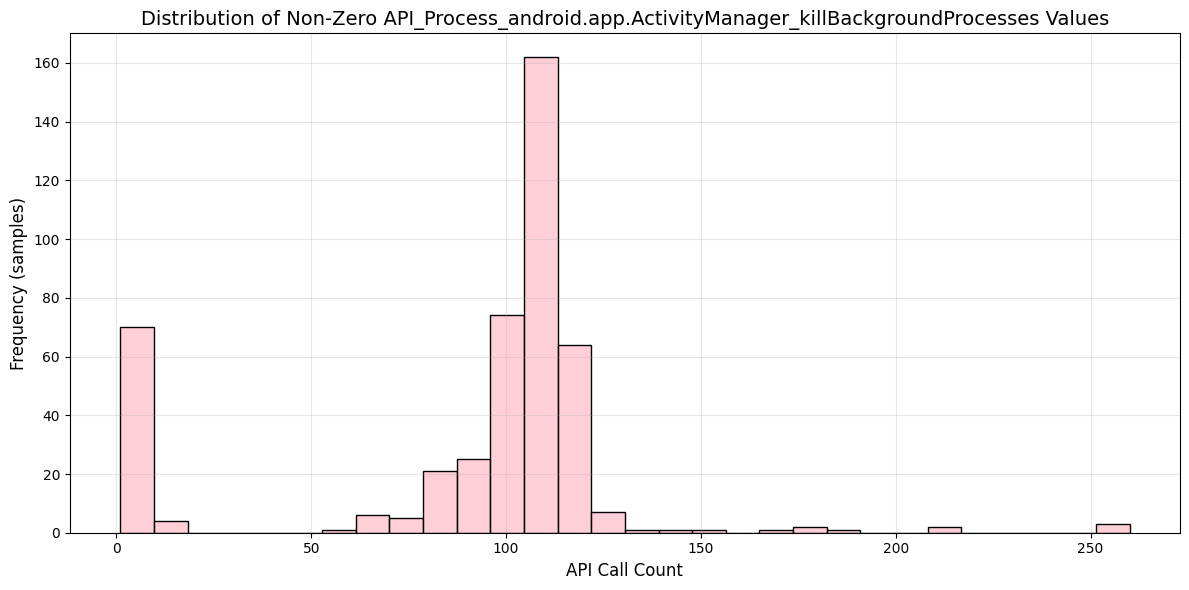

In [ ]:
plt.figure(figsize=(12, 6))
nonzero_samples = df[df["API_Process_android.app.ActivityManager_killBackgroundProcesses"] > 0]
sns.histplot(nonzero_samples["API_Process_android.app.ActivityManager_killBackgroundProcesses"], bins=30, color='pink')
plt.title(f'Distribution of Non-Zero {"API_Process_android.app.ActivityManager_killBackgroundProcesses"} Values', fontsize=14)
plt.xlabel('API Call Count', fontsize=12)
plt.ylabel('Frequency (samples)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Outliers are very sparse. The distribution shows two clusters. A small group of around 70 samples with 1 to 10 calls and a larger concentration of around 300 samples with 95 to 125 calls.

This might imply there is two different strategies. 
One where malware eliminates specific selected processes (low call count) and one where malware has a systematic clearing of the environment (high call count).

For these reasons binning could be a good approach for this feature since the distribution shows clear groupings of no activity, low usage, high usage and a few extreme outliers.

Given that the feature is highly skewed since over 50000 samples have zero calls and is spread everywhere else, binning could create a more balanced and meaningful representation.

Based on the strategic analysis, the exact count of kills is less important than the overall behavioral pattern. 

Binning would also help reduce the influence of extreme outlier values, preventing them from disproportionately affecting the models.

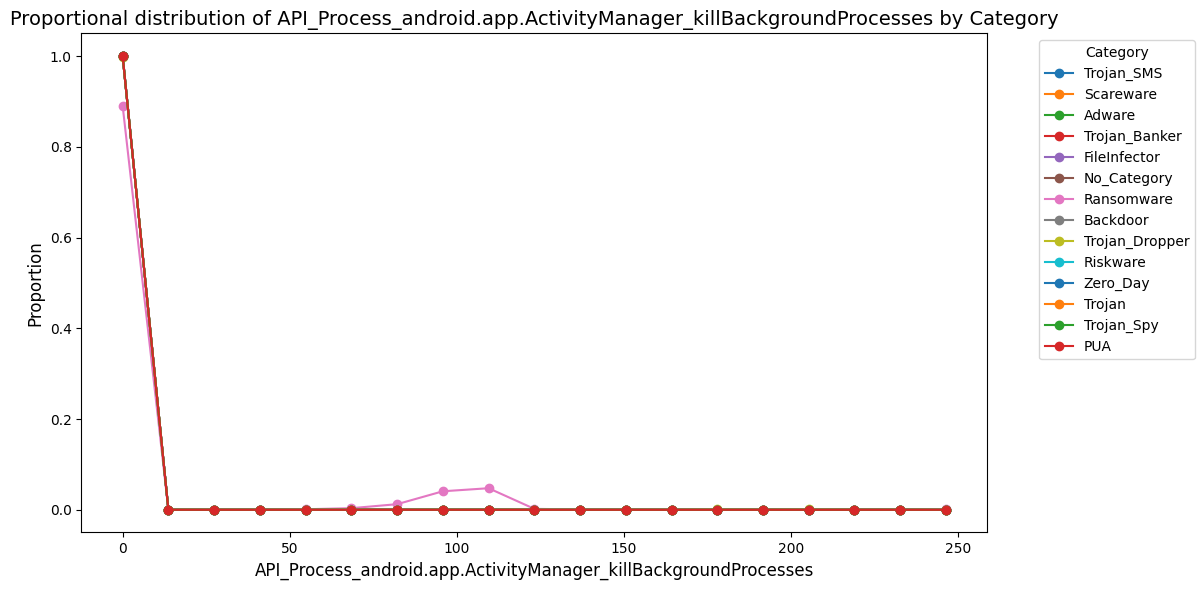

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Process_android.app.ActivityManager_killBackgroundProcesses",
    category_column="Category"
)

Apparently, all 95 to 125 calls that demonstrated high usage belong to the category Ransomware. This malware probably methodically eliminates any process that might interfere with its encryption objectives.

This feature appears mostly a behavioral signature of this type of malware compared to the others.

/var/folders/_l/fwt_9dvs30g55rs94h95qn8w0000gn/T/ipykernel_3356/2867034519.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  default_pipeline.EDA.dataset.df = default_pipeline.EDA.dataset


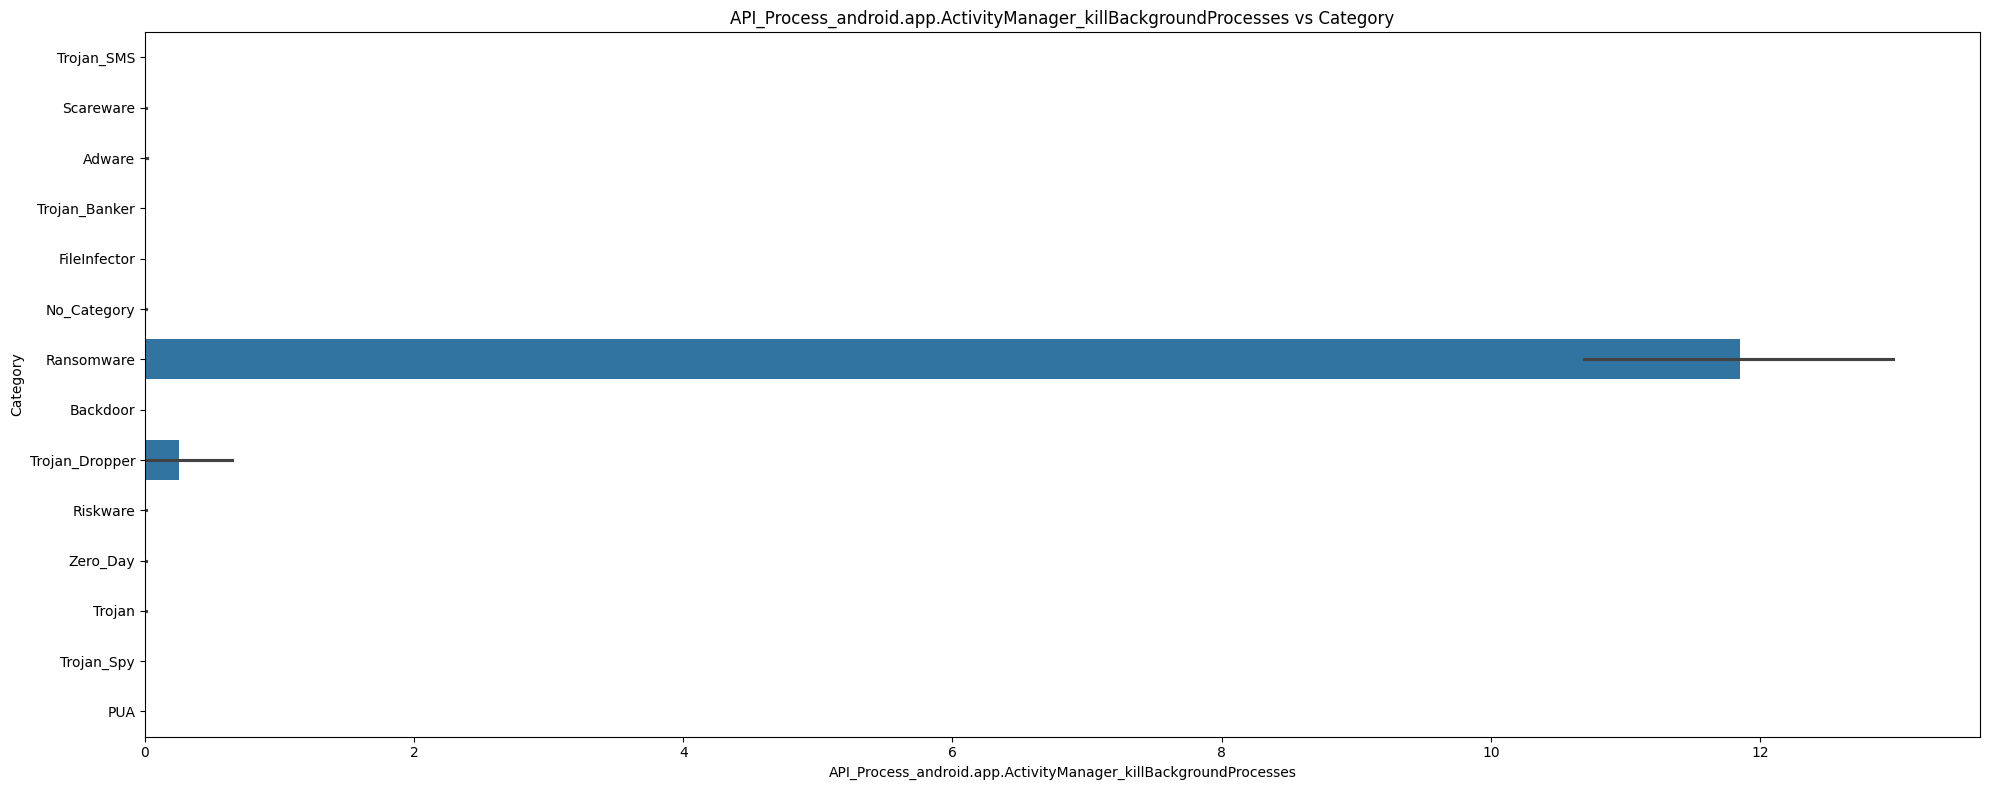

In [ ]:
# Using your EDA's barplot_bivariate method
default_pipeline.EDA.dataset.df = default_pipeline.EDA.dataset
default_pipeline.EDA.barplot_bivariate(
    features=["API_Process_android.app.ActivityManager_killBackgroundProcesses"],
    target="Category",
    n_cols=1
)

This pattern actually suggest that process killing is not a tactic for all malware but rather specific to Ransomware and Trojan_Dopper. Making this feature extremely important for ransomware and trojan_dopper detection.
Since Trojan_Dopper has a low usage, this feature offers a very low false positive potential when used to predict ransomware having nearly perfect discriminative power.

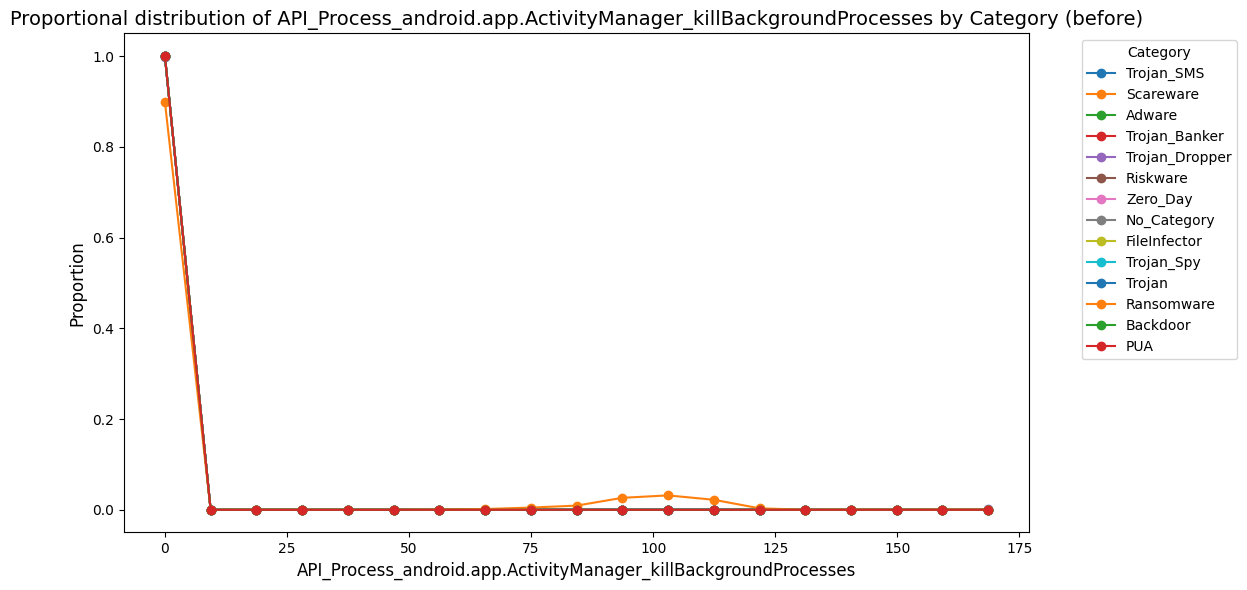

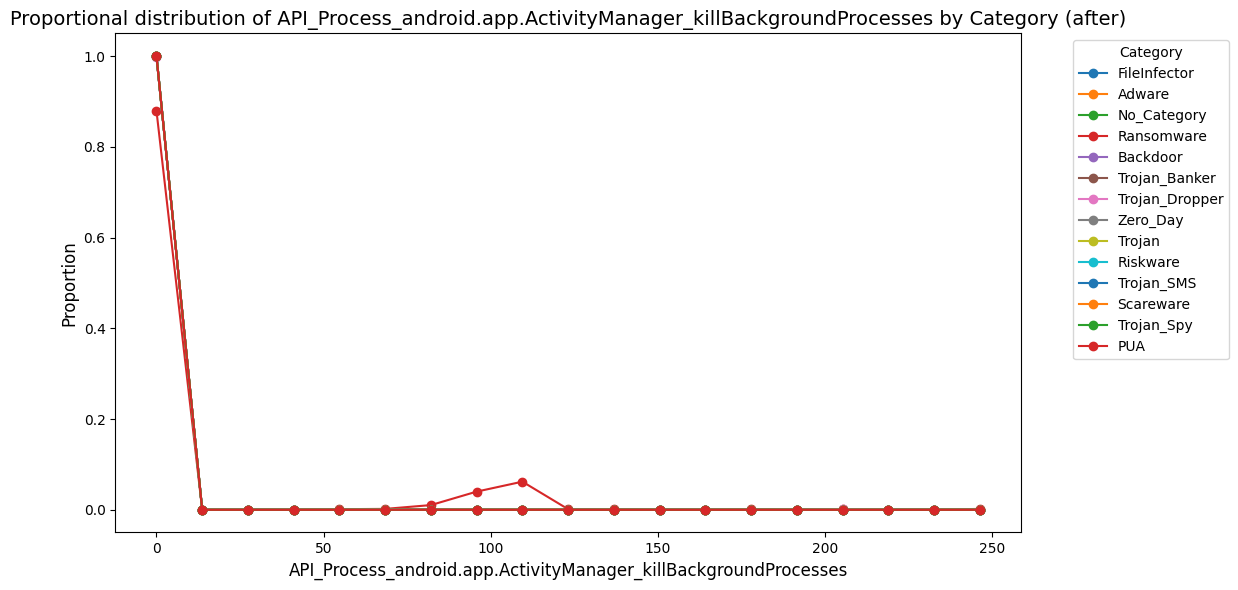

In [ ]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="API_Process_android.app.ActivityManager_killBackgroundProcesses",
    category_column="Category",
    by_reboot = True
)

In [95]:
df.groupby('Category')['API_Process_android.app.ActivityManager_killBackgroundProcesses'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,0.007559,0.231890,0.0,0.0,0.0,0.0,15.0
Backdoor,1137.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FileInfector,248.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
No_Category,1932.0,0.003623,0.060099,0.0,0.0,0.0,0.0,1.0
PUA,1290.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Ransomware,3411.0,11.853122,34.316337,0.0,0.0,0.0,0.0,260.0
Riskware,14053.0,0.002775,0.132013,0.0,0.0,0.0,0.0,10.0
Scareware,886.0,0.004515,0.094969,0.0,0.0,0.0,0.0,2.0
Trojan,8437.0,0.001896,0.153190,0.0,0.0,0.0,0.0,14.0


H3: Malware with high kill rates might correlate with lower network or process activity afterward (because it's "killing" things before doing its work).


To better understand which malware families are responsible for the most aggressive behavior, we focus on the top 5% of samples with the highest number of killBackgroundProcesses calls — what we call the "extreme killers."
Instead of looking at the full dataset (which includes many less active samples), we create a filtered subset and plot the category distribution only for these extreme cases.
This approach gives a clearer view of which malware types are aggressively interacting with other processes, potentially indicating more hostile, self-preserving, or stealth-focused behavior.
Without this filtering, the full category distribution would be dominated by more common but less interesting samples, making it harder to spot the true outliers.

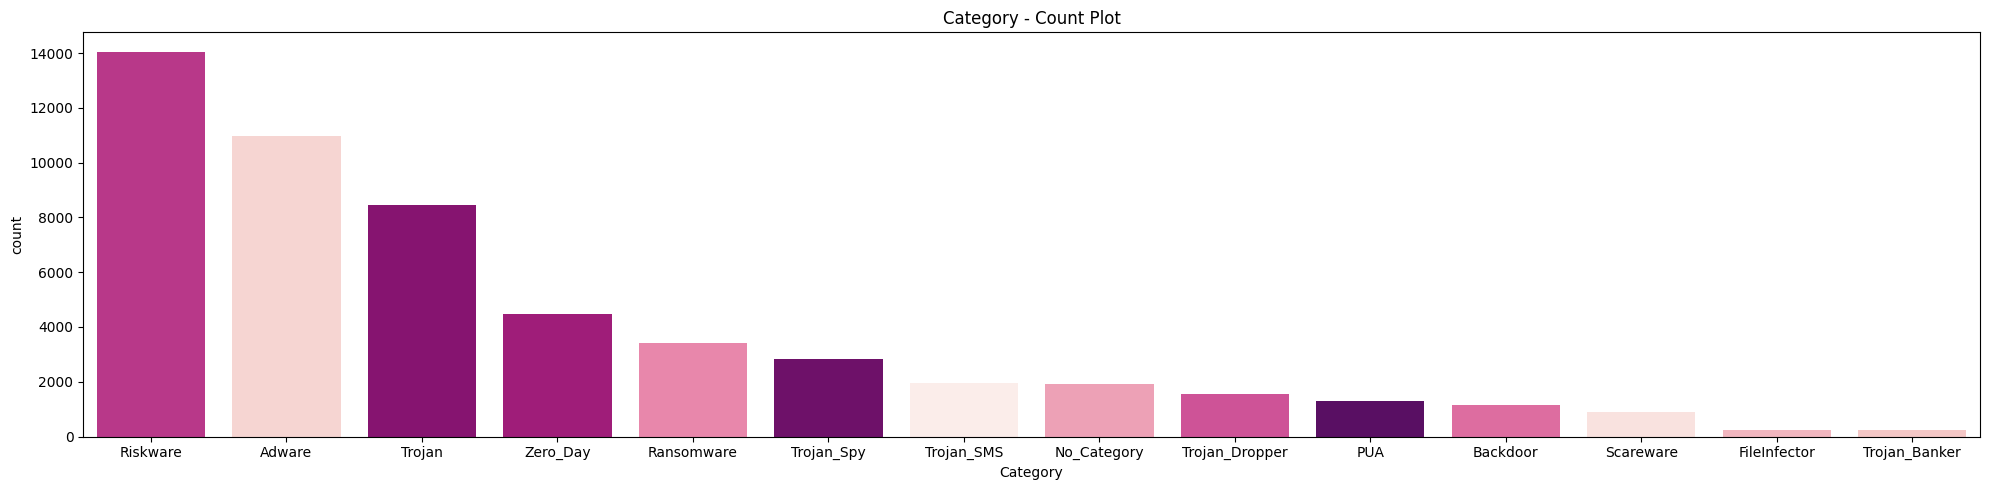

In [ ]:
# Define extreme killers
kill_background_threshold = default_pipeline.EDA.dataset.df['API_Process_android.app.ActivityManager_killBackgroundProcesses'].quantile(0.95)

extreme_killers = default_pipeline.EDA.dataset.df[
    default_pipeline.EDA.dataset.df['API_Process_android.app.ActivityManager_killBackgroundProcesses'] > kill_background_threshold
]

# Plot how many extreme killers per category
default_pipeline.EDA.plot_categorical_distributions(
    features=["Category"],
    n_cols=1,
    sorted=True
)


Goal:
Since most samples probably don’t call killBackgroundProcesses at all,
maybe this feature is better as binary:

0 = No killing

1 = Called killBackgroundProcesses (at least once)

In [ ]:
# Binarize for quick exploration
default_pipeline.EDA.dataset.df['killBackgroundProcesses_bin'] = (
    default_pipeline.EDA.dataset.df['API_Process_android.app.ActivityManager_killBackgroundProcesses'] > 0
).astype(int)

# Now check distribution
default_pipeline.EDA.plot_categorical_distributions(
    features=["killBackgroundProcesses_bin"],
    n_cols=1
)


 What to look for:

If 95%+ of samples are 0 ➔ binarization could help create a strong flag feature.

If distribution is balanced ➔ could use both raw + binary versions.

#### os.Process_killProcess

In [ ]:
df['API_Process_android.os.Process_killProcess'].describe()

count    53439.000000
mean         0.007448
std          1.207620
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        215.000000
Name: API_Process_android.os.Process_killProcess, dtype: float64

Hypotheses to analyze:

H4: Malware that calls killProcess specifically may be targeting exact processes, showing more precise or sophisticated behavior.

H5: High killProcess usage could correlate with advanced malware (spyware, backdoors) trying to surgically remove defenses (e.g., anti-virus apps).

✅ Key checks:

Compare killProcess usage per category.

Find samples with only killProcess calls (no killBackgroundProcesses) to spot precision attacks.

See if high killProcess usage relates to specific stealthy malware behaviors (e.g., zero network traffic but high API usage).

#### others

(Apply using either or both kill APIs together.)

H6: Malware with high combined kill API usage behaves differently — likely more stealthy, aggressive, or hostile.

H7: Malware with zero kill API usage might either be:

Dormant (doing nothing),

Or straightforward (doesn't care about hiding).

H8: Malware types could cluster based on total kill behavior — heavy killers vs. light/no killers.

✅ Key checks:

Create a Kill_API_Total = killBackgroundProcesses + killProcess

Visualize distribution by category (boxplot, histogram)

Identify extreme outliers.

### Command java lang

This commands allows us to execute system-level commands and manage processes using Java-based methods

Features:

API_Command_java.lang.Runtime_exec: Executes a system command. This is used for running shell commands or interacting with the os from the android app 

EDA => too many calls from the app is likely a worrying signal. 

API_Command_java.lang.ProcessBuilder_start: Starts a new process using ProcessBuilder. This provides a more flexible way to control and manage a process, useful when you want to perform complex system commands.

### Java Native Interface 

Java Native Interface

This API allows Java-based android apps to interact with C/C++ libraries.

API_JavaNativeInterface_java.lang.Runtime_loadLibrary:  Loads a native library, which are precompiled and use to increase performance.

API_JavaNativeInterface_java.lang.Runtime_load: Loads a dynamic library which is shared code file that multiple programs processes can load at runtime

### Web View Android

Web view Android

Webview os a built-in browser component in android that allows apps to display web pages inside the app itself instead of opening an external browser

Features:	

API_WebView_android.webkit.WebView_loadUrl: Loads a URL in WebView 

API_WebView_android.webkit.WebView_loadData: Loads raw HTML data in WebView. 

API_WebView_android.webkit.WebView_loadDataWithBaseURL: Loads HTML data with a base URL. 

API_WebView_android.webkit.WebView_addJavascriptInterface: Adds a JavaScript interface to WebView. 

API_WebView_android.webkit.WebView_evaluateJavascript: executes JavaScript code inside WebView. 

API_WebView_android.webkit.WebView_postUrl: Allows WebView to send HTTP POST requests
EDA NOTE => analyze if this an anomaly. It may be the case that for you to send HTTP POST you need rare privileges.

API_WebView_android.webkit.WebView_postWebMessage: Sends a web message via WebView. Used for secure communication between Android WebView and a website

API_WebView_android.webkit.WebView_savePassword: Saves login credentials in WebView for autofill.

 EDA NOTE => this is a very typical attack vector. Research on this.

API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword: Stores HTTP authentication credentials for Authentication

API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword: Retrieves saved HTTP authentication credentials. 

 EDA NOTE => this is a typical attack vector. Research on this.

API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled: Enables Chrome DevTools debugging for WebView. 

EDA NOTE => this may be completely irrelevant (considered to be dropped) for our problem


In [ ]:
# Get all column names from the dataset
all_columns = default_pipeline.dataset.df.columns.tolist()

# Filter for columns that specifically start with 'API_'
api_columns = [col for col in all_columns if col.startswith('API_')]

# Check if there are at least 57 API features
if len(api_columns) >= 57:
    # Get the 57th API feature (using 0-based indexing)
    api_feature_57 = api_columns[56]
    print(api_feature_57)
else:
    print(f"There are only {len(api_columns)} API_ features, which is fewer than 57.")

API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number


## Summary Statistics Overview

## Histograms


In [ ]:
"""# Select only numerical features
numerical_cols = dataset.df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot histograms
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()"""

'# Select only numerical features\nnumerical_cols = dataset.df.select_dtypes(include=[np.number]).columns\n\n# Define number of rows and columns for subplots\nnum_features = len(numerical_cols)\ncols = 4  # Number of columns per row\nrows = math.ceil(num_features / cols)  # Calculate required rows\n\n# Create subplots\nfig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))\naxes = axes.flatten()  # Flatten to easily iterate\n\n# Plot histograms\nfor i, col in enumerate(numerical_cols):\n    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve\n    axes[i].set_title(col)\n\n# Remove empty subplots\nfor i in range(num_features, len(axes)):\n    fig.delaxes(axes[i])\n\nplt.tight_layout()\nplt.show()'

We can see most distributions tend to be right-skewed and only a small portion follows a normal distribution. This right-skewness will be dealt in feature-engineering.

In [ ]:
"""# Select only numerical features
numerical_cols = dataset.df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot boxplots
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=dataset.df[col], ax=axes[i])  # Boxplot for each feature
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()"""

'# Select only numerical features\nnumerical_cols = dataset.df.select_dtypes(include=[np.number]).columns\n\n# Define number of rows and columns for subplots\nnum_features = len(numerical_cols)\ncols = 4  # Number of columns per row\nrows = math.ceil(num_features / cols)  # Calculate required rows\n\n# Create subplots\nfig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))\naxes = axes.flatten()  # Flatten to easily iterate\n\n# Plot boxplots\nfor i, col in enumerate(numerical_cols):\n    sns.boxplot(x=dataset.df[col], ax=axes[i])  # Boxplot for each feature\n    axes[i].set_title(col)\n\n# Remove empty subplots\nfor i in range(num_features, len(axes)):\n    fig.delaxes(axes[i])\n\nplt.tight_layout()\nplt.show()'

## Numerical Features

Seemed to be grouped by prefixes: Memory, Network, Battery, Logcat, Process y API.

According to dataset authors to capture how various malware families and categories behave at runtime, the analysis relies on six distinct sets of features obtained after executing each sample within a controlled emulated environment. These feature groups offer a comprehensive view of the malware's dynamic activity.

This categories appear before the first _ in every feature label and are defined as:


"Memory: Memory features define activities performed by malware by utilizing memory.

API: Application Programming Interface (API) features delineate the communication between two applications.

Network: Network features describe the data transmitted and received between other devices in the network. It indicates foreground and background network usage.

Battery: Battery features describe the access to battery wakelock and services by malware.

Logcat: Logcat features write log messages corresponding to a function performed by malware.

Process: Process features count the interaction of malware with total number of processes."



In [ ]:
"""numeric_cols = dataset.df.select_dtypes(include='number').columns

# Grouping based on the first prefix before "_"
prefix_groups = defaultdict(list)

for col in numeric_cols:
    prefix = col.split("_")[0]  # Get the first word before the underscore
    prefix_groups[prefix].append(col)

for prefix, columns in prefix_groups.items():
    print(f"\n {prefix} ({len(columns)} features):")
    for col in columns:
        print(f"  - {col}")"""

'numeric_cols = dataset.df.select_dtypes(include=\'number\').columns\n\n# Grouping based on the first prefix before "_"\nprefix_groups = defaultdict(list)\n\nfor col in numeric_cols:\n    prefix = col.split("_")[0]  # Get the first word before the underscore\n    prefix_groups[prefix].append(col)\n\nfor prefix, columns in prefix_groups.items():\n    print(f"\n {prefix} ({len(columns)} features):")\n    for col in columns:\n        print(f"  - {col}")'

## Categorical Features

In [ ]:
"""#Statistical summary for categorical features
dataset.df.describe(include=["object", "category", "bool"])"""

'#Statistical summary for categorical features\ndataset.df.describe(include=["object", "category", "bool"])'

In [ ]:
"""print(dataset.df[['Hash', 'Category', 'Family']].head())"""

"print(dataset.df[['Hash', 'Category', 'Family']].head())"

Hash: unique identifier that represents each malware sample. <<<>>>THIS IS PROBABLY WRONG<<<>>>

Category: general classification of the malware sample based on its behavior.

Family: more fine-grained grouping of malware based on its codebase or origin

For hash, it will first be checked if the same malware before and after reboot contains the same hash value.

In [ ]:
"""# Count how many times each hash appears in 'before' and 'after'
hash_reboot_counts =dataset.df.groupby(['Hash', 'reboot']).size().unstack(fill_value=0)

# Hashes in both with exactly one in each
hashes_with_one_each = hash_reboot_counts[
    (hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1)
].index

# Hashes in both but with extra rows
hashes_in_both_but_not_clean = hash_reboot_counts[
    (hash_reboot_counts['before'] > 0) &
    (hash_reboot_counts['after'] > 0) &
    ~((hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1))
].index

# Total unique hashes
total_unique_hashes = dataset.df['Hash'].nunique()

# Hashes in only one reboot condition
hashes_in_one_condition = hash_reboot_counts[
    (hash_reboot_counts['before'] == 0) | (hash_reboot_counts['after'] == 0)
]

# Only once in one reboot condition
only_once_in_one = hashes_in_one_condition[
    (hashes_in_one_condition['before'] == 1) | (hashes_in_one_condition['after'] == 1)
]

# More than once in one reboot condition
more_than_once_in_one = hashes_in_one_condition[
    ((hashes_in_one_condition['before'] > 1) & (hashes_in_one_condition['after'] == 0)) |
    ((hashes_in_one_condition['after'] > 1) & (hashes_in_one_condition['before'] == 0))
]

# Split those into counts
more_than_once_in_before = more_than_once_in_one[more_than_once_in_one['before'] > 1]
more_than_once_in_after = more_than_once_in_one[more_than_once_in_one['after'] > 1]

# --- PRINT RESULTS ---
print(f"Hashes with EXACTLY one row in BOTH before and after: {len(hashes_with_one_each)}")
print(f"Hashes in BOTH, BUT with extra rows: {len(hashes_in_both_but_not_clean)}")

print(f"\nHashes in ONLY ONE reboot condition:")
print(f"• Appearing ONLY ONCE: {len(only_once_in_one)}")
print(f"• Appearing MORE THAN ONCE: {len(more_than_once_in_one)}")
print(f"   - More than once in BEFORE: {len(more_than_once_in_before)}")
print(f"   - More than once in AFTER: {len(more_than_once_in_after)}")

print(f"\nTotal breakdown:")
print(f"• In BOTH (any): {len(hashes_with_one_each) + len(hashes_in_both_but_not_clean)}")
print(f"• In ONLY ONE reboot: {len(hashes_in_one_condition)}")
print(f"• TOTAL unique hashes: {total_unique_hashes}")
"""

'# Count how many times each hash appears in \'before\' and \'after\'\nhash_reboot_counts =dataset.df.groupby([\'Hash\', \'reboot\']).size().unstack(fill_value=0)\n\n# Hashes in both with exactly one in each\nhashes_with_one_each = hash_reboot_counts[\n    (hash_reboot_counts[\'before\'] == 1) & (hash_reboot_counts[\'after\'] == 1)\n].index\n\n# Hashes in both but with extra rows\nhashes_in_both_but_not_clean = hash_reboot_counts[\n    (hash_reboot_counts[\'before\'] > 0) &\n    (hash_reboot_counts[\'after\'] > 0) &\n    ~((hash_reboot_counts[\'before\'] == 1) & (hash_reboot_counts[\'after\'] == 1))\n].index\n\n# Total unique hashes\ntotal_unique_hashes = dataset.df[\'Hash\'].nunique()\n\n# Hashes in only one reboot condition\nhashes_in_one_condition = hash_reboot_counts[\n    (hash_reboot_counts[\'before\'] == 0) | (hash_reboot_counts[\'after\'] == 0)\n]\n\n# Only once in one reboot condition\nonly_once_in_one = hashes_in_one_condition[\n    (hashes_in_one_condition[\'before\'] == 1) 

A total of 19,169 hashes appear exactly once in both before and after conditions. These are highly reliable for paired  comparisons, ideal for understanding how reboot affects malware behavior.


There are 158 hashes that appear in both reboot states but not exactly once in each. These extra instances may come from inconsistencies in data capture like multiple logs for the same sample and should be checked.

A significant portion of samples appear only in one reboot condition. This is consistent with limitations described in the original dataset paper, where some malware samples failed to execute after the reboot. However, what is curious is that some still have been logged more than once.


In [ ]:
"""dataset.df.drop(columns=['Hash'], inplace=True)
'''
The Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.
It serves as an identifier for each malware sample. Including this column in modeling
would not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are
sensitive to high-cardinality categorical features.
 <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the 
  argumentation in a text cell not in this type of comments. <<<>>>
'''"""

"dataset.df.drop(columns=['Hash'], inplace=True)\n'''\nThe Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.\nIt serves as an identifier for each malware sample. Including this column in modeling\nwould not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are\nsensitive to high-cardinality categorical features.\n <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the \n  argumentation in a text cell not in this type of comments. <<<>>>\n'''"

This research will be using both Category and Family as the target variables for classification.

## Reboot Analysis

In [ ]:
"""print(dataset.df["reboot"].value_counts())"""

'print(dataset.df["reboot"].value_counts())'

The imbalance observed in the dataset, with 28,380 samples collected before reboot and only 25,059 after reboot, is explained by limitations found during the dynamic analysis. The authors of the dataset note that "there was no entry point in some Android malware samples and some Android malware samples stopped abruptly." This means that certain malware applications either failed to launch or terminated unexpectedly during execution, preventing the collection of dynamic behavior data, particularly after the reboot phase.

Additionally, the study highlights another critical limitation: "the dynamic analysis is performed in an emulator. Some malware samples are able to detect the emulated environment and are not executed." This behavior reflects common anti-analysis techniques used by sophisticated malware, which can detect when they are running in a sandbox or emulator and intentionally suspend their malicious actions.




<<<>>>THIS ANALYSIS IS SUPER GOOD (you can delete this comment)<<<>>>

The displayed features are the top 10  most affected by reboot showing a clear reboot-sensitive behavior.

In [ ]:
"""#Category distribution across reboot
plt.figure(figsize=(12, 6))
sns.countplot(data=dataset.df, x='Category', hue='reboot')
plt.title("Malware Categories by Reboot Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""


'#Category distribution across reboot\nplt.figure(figsize=(12, 6))\nsns.countplot(data=dataset.df, x=\'Category\', hue=\'reboot\')\nplt.title("Malware Categories by Reboot Condition")\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()'

To identify which numeric features are most influenced by the reboot condition, the dataset will be grouped by the reboot variable, separating entries collected before and after the device reboot. Within each group, the mean of every numeric feature will be computed, allowing for the comparison of average behavior across both states.

A new column labeled 'diff' was then added, representing the difference between the mean values after and before the reboot for each feature. A positive value indicates that the feature increased after reboot, while a negative value shows it decreased.

In [ ]:
"""reboot_means = dataset.df.groupby('reboot').mean(numeric_only=True).T
reboot_means['diff'] = reboot_means['after'] - reboot_means['before']
reboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)

reboot_means_sorted.head(10)"""

"reboot_means = dataset.df.groupby('reboot').mean(numeric_only=True).T\nreboot_means['diff'] = reboot_means['after'] - reboot_means['before']\nreboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)\n\nreboot_means_sorted.head(10)"

The results reveal that several features show clear shifts after reboot. Specially, network-related features such as Network_TotalReceivedBytes and Network_TotalTransmittedBytes demonstrate significant increases, suggesting that some malware types intensify data transmission once the device has rebooted. Memory features like Memory_SharedClean, Memory_HeapSize, and Memory_HeapAlloc also show increased values after reboot, indicating greater memory use or altered memory management after reboot.
This shows that the reboot condition plays an important role in runtime behavior and should be treated as an important factor in exploratory analysis and modeling.

## Family

In [ ]:
"""#How many categories each family belongs to
dataset.df.groupby("Family")["Category"].nunique().sort_values(ascending=False)"""

'#How many categories each family belongs to\ndataset.df.groupby("Family")["Category"].nunique().sort_values(ascending=False)'

Almost every family is either unknown or unique


In [ ]:
# <<<Error: NameError: name 'family_to_category' is not defined>>> (this Irina's code; copied from Argentinan guy's notebook)
# multi_cat_families = family_to_category[family_to_category > 1]
# print(f"Number of families mapping to multiple categories: {len(multi_cat_families)}")
# print(multi_cat_families)

There is only one Family that maps to multiple categories, and is the placeholder unknown.

The following code displays how many samples with unknown family labels belong to each malware category.

In [ ]:
"""dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()"""

'dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()'

In [ ]:
"""# Step 1: Count unique families per category
family_amount = dataset.df.groupby("Category")["Family"].nunique()

# Step 2: Total number of instances per category
total_per_category = dataset.df["Category"].value_counts()

# Step 3: Count how many of those are <unknown> per category
unknown_amount = dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()

# Step 4: Combine all stats into a summary table
summary_df = pd.DataFrame({
    "Family_amount": family_amount,
    "Total_category": total_per_category,
    "Unknown_amount": unknown_amount
}).fillna(0).astype({"Unknown_amount": int})

# Step 5: Calculate percentage of unknowns per category
summary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)

# Reorder columns for readability
summary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]

# Display the summary
print(summary_df)"""

'# Step 1: Count unique families per category\nfamily_amount = dataset.df.groupby("Category")["Family"].nunique()\n\n# Step 2: Total number of instances per category\ntotal_per_category = dataset.df["Category"].value_counts()\n\n# Step 3: Count how many of those are <unknown> per category\nunknown_amount = dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()\n\n# Step 4: Combine all stats into a summary table\nsummary_df = pd.DataFrame({\n    "Family_amount": family_amount,\n    "Total_category": total_per_category,\n    "Unknown_amount": unknown_amount\n}).fillna(0).astype({"Unknown_amount": int})\n\n# Step 5: Calculate percentage of unknowns per category\nsummary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)\n\n# Reorder columns for readability\nsummary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]\n\n# Display the summary\nprint(summary_df)'

In [ ]:
"""unknown_count = (dataset.df["Family"] == "<unknown>").sum()
print(f"Number of rows with Family == '<unknown>': {unknown_count}")"""


'unknown_count = (dataset.df["Family"] == "<unknown>").sum()\nprint(f"Number of rows with Family == \'<unknown>\': {unknown_count}")'

Based on the analysis of family distribution across categories:

The Adware category stands out with zero instances labeled as <unknown> and a balanced distribution across 43 families. This makes it a strong candidate for modeling.

In contrast, Zero_Day and No_Category The categories Zero_Day and No_Category exhibit extremely high family dispersion, with 2576 and 335 unique families. These values are significantly higher than all other categories, which generally have fewer than 50 families each.


This suggests they function more as placeholder labels. In particular, Zero_Day likely serves as a catch-all label for unknown or uncategorized threats, making it ambiguous. In cybersecurity, this term is refered to a new unknown vulnerability, not yet classified in terms of malware behavior, this is why samples are varied. They do not seem to represent a consistent type. On the other hand, No_Category explicitly denotes a lack of category. So, including these instances would only bring noise to the training process, preventing the model from learning meaningful patterns.
Therefore, they are excluded from the final dataset to preserve the quality and consistency of the classification task.


Additionally, categories like FileInfector show a high percentage of <unknown> families (6.85%) despite having a small total count, raising concerns about label quality. Most other categories maintain a relatively stable level of unknowns (around 3–5%), indicating that the presence of <unknown> is manageable.

<hr>

# 2. DATA SPLITTING
### TO BE DONE
- Statistical analysis of this
- Make sure they follow the same distributions

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

Also object!
Lets get back to the splitting!

Before, we split the dataset lets observe the SE of accuracy variation based on our choice of split. 
Brief explanation: we can model accuracy via a Binomial distribution. We know each event in a binomial distribution can be modelled through a bernoulli distribution, where the outcome represents the probability predicting the correct class or not. We make the assumption that each classification error is independent from each other. For:
$$
\text{Bin} \sim (n, p)
$$
 let us assume that the parameter of this distribution is p = .85 and n is given by the choice of sample split for the test set. The SE of the sample proportion can be modeled via: 
$$
\text{SE}_{\hat{p}} = \sqrt{\frac{p(1 - p)}{n}}

$$

Before we continue to assess all possible choices of split based on a variant n, also note that that choice of evenly distributed split (e.g: 10% for each hold-out set) between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.

Finally, also note that that choice of evenly distributed split between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.


/Users/fc/Documents/ASEMESTERIV/ml-final-project/library/phases/dataset/split/strategies/noTimeSeries.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  differenceToPriorSE_percentage = (currentSE - priorSE) /  priorSE


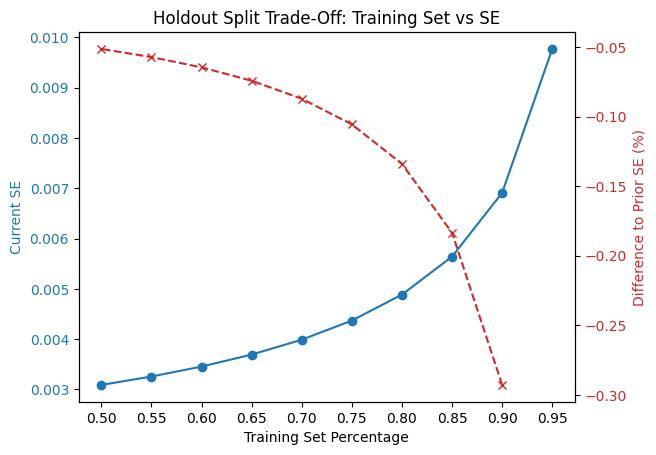

,train_size (%),train_size_count,validation_size (%),validation_size_count,test_size (%),test_size_coount,currentSE,differenceToPriorSE,differenceToPriorSE (%)
0,0.95,50767.0,0.025,1336.0,0.025,1336.0,0.009769,0.009769,inf
1,0.90,48095.0,0.050,2672.0,0.050,2672.0,0.006908,-0.002861,-0.292893
2,0.85,45423.0,0.075,4008.0,0.075,4008.0,0.005640,-0.001268,-0.183503
3,0.80,42751.0,0.100,5344.0,0.100,5344.0,0.004885,-0.000756,-0.133975
4,0.75,40079.0,0.125,6680.0,0.125,6680.0,0.004369,-0.000516,-0.105573
5,0.70,37407.0,0.150,8016.0,0.150,8016.0,0.003988,-0.000381,-0.087129
6,0.65,34735.0,0.175,9352.0,0.175,9352.0,0.003692,-0.000296,-0.074180
7,0.60,32063.0,0.200,10688.0,0.200,10688.0,0.003454,-0.000238,-0.064586
8,0.55,29391.0,0.225,12024.0,0.225,12024.0,0.003256,-0.000198,-0.057191
9,0.50,26720.0,0.250,13360.0,0.250,13360.0,0.003089,-0.000167,-0.051317


In [ ]:
default_pipeline.dataset.split.asses_split_classifier(p=.85, step=.05, plot=True)

[We can see a diminishing-returns class graph](https://en.wikipedia.org/wiki/Knee_of_a_curve). The more we decline the training set percentage the slower and more steadier the current SE varies as well as the difference to prior SE, in percentage. We can see that the knee in the curve is between 80 and 90 training set percentage. This represents the area where when you start going below the lower bound, no **significant** improve appears. Given the fact that our criteria for choice of split percentage is to keep as much training possible while increasing hold-out sets size only if the decrease in SE is significant **we are going to select 80% for the training set**.

In [ ]:
default_pipeline.dataset.split.split_data(y_column="Category",
                                   train_size=.8, 
                                   validation_size=.1,
                                   test_size=.1, 
                                   plot_distribution=False)

In [ ]:
default_pipeline.dataset.X_train.shape, default_pipeline.dataset.X_val.shape, default_pipeline.dataset.X_test.shape, default_pipeline.dataset.y_train.shape, default_pipeline.dataset.y_val.shape, default_pipeline.dataset.y_test.shape

((42751, 142), (5344, 142), (5344, 142), (42751,), (5344,), (5344,))

<hr>

# 3. DATA PREPROCESSING

### Feature Scaling

We will work only with the training set to avoid data leakage.

In [ ]:
#dataset.X_train

We eliminate the field `Reboot_before` since it is boolean.

In [ ]:
# preprocessor.remove_reboot_column()
# preprocessor.X_train_without_reboot

In [ ]:
# preprocessor.X_train_without_reboot.describe().T[['min', 'max']]

Secondly, we're gonna check for kurtosis and skewness. If skewness is high we might need to consider standardizing.

In [ ]:
# print(f"\nSkewness:\n----------------\n{preprocessor.X_train_without_reboot.skew()}")
# print(f"\nKurtosis:\n----------------\n{preprocessor.X_train_without_reboot.kurt()}")

Since there is a very large number of fields, we need to avoid looking at the distribution and information about each feature. For this, we decided to create an automation that decides the appropriate scaling method -if necessary- for each feature.

This function `determine_scaling_method` takes into account outlier detection and skewness and based on that it decides to use a **robust scaler**, **normalize** or **none**.

**Note**: we use robust scaler rather than a standard scaler because robust scales with the median and IQR, which is less sensitive to outliers than standardizing is -computed with $\mu$ and $\sigma$. It will turn the median to 0 and turn the values in a field in values between -1 and 1 with some outliers.

Normalization Formula:
 

Robust Scaler Formula:
 
Where:

IQR (Interquartile Range) = Q3 - Q1

In [ ]:
# preprocessor.prepare_scaling()

In [ ]:
# X_train_scaled = preprocessor.apply_scaling()

# "\nRobust complete! The training data is now ready for modeling."

In [ ]:
# X_train_scaled

The histograms show how `RobustScaler` compresses extreme values and brings the bulk of the data closer to a common scale. Despite the presence of outliers, the core distribution becomes more uniform and comparable across features — ideal for many ML models.

This section below shall be properly written. It is set now for early debugging

## !> Pipeline example
Let us show an example of the pipeline divergence. We will create a divergence for the baseline pipeline. We will exempt it from being scaled. This specific example is not meant to be kept, but rather show the purpose of the corresponding functions.

In [ ]:
baseline_pipeline = pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="logistic")

In [ ]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000
mean,70944.886272,12764.341700,10844.857898,47646.187738,88029.087694,14333.172277,0.0,22278.685996,17539.452434,4738.241304,...,466.232720,3.396201,0.723235,2337.759865,2.370012e+03,2296.848963,2300.166686,2300.399780,1.160519e+04,190.169821
std,36266.506343,12900.070827,999.033790,29793.858149,15871.265926,13468.721351,0.0,12570.621975,10519.885159,2939.327428,...,3644.649287,1.518657,0.981457,2203.232434,1.038044e+04,2273.580562,2031.749201,1976.428885,1.101732e+04,2.896415
min,4808.000000,0.000000,7036.000000,12.000000,4268.000000,0.000000,0.0,5113.000000,3249.000000,1012.000000,...,0.000000,0.000000,0.000000,6.000000,4.000000e+01,36.000000,45.000000,33.000000,3.121000e+03,172.000000
25%,46185.000000,3972.000000,10540.000000,31992.000000,76716.000000,4984.000000,0.0,13486.500000,10670.000000,2994.000000,...,0.000000,2.000000,0.000000,1159.000000,1.098000e+03,1107.000000,1100.000000,1135.000000,9.422000e+03,188.000000
50%,61243.000000,6356.000000,10732.000000,41444.000000,89584.000000,8180.000000,0.0,20447.000000,16560.000000,4070.000000,...,21.000000,3.000000,0.000000,2043.000000,2.020000e+03,2000.000000,2015.000000,2004.000000,1.097700e+04,190.000000
75%,91785.000000,20048.000000,11144.000000,55338.000000,99092.000000,21740.000000,0.0,28743.500000,22846.500000,5838.000000,...,124.500000,4.000000,1.000000,3054.000000,3.028000e+03,3027.000000,3026.000000,3037.000000,1.299250e+04,192.000000
max,819456.000000,106360.000000,40416.000000,809032.000000,183600.000000,110336.000000,0.0,310155.000000,286959.000000,88630.000000,...,85873.000000,12.000000,10.000000,219143.000000,2.066046e+06,142010.000000,89456.000000,102860.000000,2.067038e+06,221.000000


In [ ]:
default_pipeline.preprocessing.scale_features(scaler="robust",
                                      columnsToScale=default_pipeline.dataset.X_train.select_dtypes(include=["number"]).columns)

In [ ]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000
mean,0.212761,0.398628,0.186851,0.265664,-0.069490,0.367222,0.0,0.120055,0.080438,0.234965,...,3.576166,0.198101,0.723235,0.155546,0.181353,0.154609,0.148062,0.155836,0.175938,0.042455
std,0.795318,0.802443,1.654029,1.276187,0.709299,0.803815,0.0,0.823925,0.863950,1.033519,...,29.274291,0.759329,0.981457,1.162656,5.378467,1.184157,1.054906,1.039132,3.085652,0.724104
min,-1.237610,-0.395372,-6.119205,-1.774694,-3.812835,-0.488183,0.0,-1.005047,-1.093171,-1.075246,...,-0.168675,-1.500000,0.000000,-1.074934,-1.025907,-1.022917,-1.022845,-1.036278,-2.200252,-4.500000
25%,-0.330219,-0.148296,-0.317881,-0.404866,-0.575080,-0.190738,0.0,-0.456217,-0.483719,-0.378340,...,-0.168675,-0.500000,0.000000,-0.466491,-0.477720,-0.465104,-0.475078,-0.456887,-0.435513,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.669781,0.851704,0.682119,0.595134,0.424920,0.809262,0.0,0.543783,0.516281,0.621660,...,0.831325,0.500000,1.000000,0.533509,0.522280,0.534896,0.524922,0.543113,0.564487,0.500000
max,16.627478,6.220702,49.145695,32.878780,4.201645,6.096682,0.0,18.988530,22.206628,29.732771,...,689.574297,4.500000,10.000000,114.564644,1069.443523,72.921875,45.400312,53.026288,575.846800,7.750000


In [ ]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000
mean,0.212761,0.398628,0.186851,0.265664,-0.069490,0.367222,0.0,0.120055,0.080438,0.234965,...,3.576166,0.198101,0.723235,0.155546,0.181353,0.154609,0.148062,0.155836,0.175938,0.042455
std,0.795318,0.802443,1.654029,1.276187,0.709299,0.803815,0.0,0.823925,0.863950,1.033519,...,29.274291,0.759329,0.981457,1.162656,5.378467,1.184157,1.054906,1.039132,3.085652,0.724104
min,-1.237610,-0.395372,-6.119205,-1.774694,-3.812835,-0.488183,0.0,-1.005047,-1.093171,-1.075246,...,-0.168675,-1.500000,0.000000,-1.074934,-1.025907,-1.022917,-1.022845,-1.036278,-2.200252,-4.500000
25%,-0.330219,-0.148296,-0.317881,-0.404866,-0.575080,-0.190738,0.0,-0.456217,-0.483719,-0.378340,...,-0.168675,-0.500000,0.000000,-0.466491,-0.477720,-0.465104,-0.475078,-0.456887,-0.435513,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.669781,0.851704,0.682119,0.595134,0.424920,0.809262,0.0,0.543783,0.516281,0.621660,...,0.831325,0.500000,1.000000,0.533509,0.522280,0.534896,0.524922,0.543113,0.564487,0.500000
max,16.627478,6.220702,49.145695,32.878780,4.201645,6.096682,0.0,18.988530,22.206628,29.732771,...,689.574297,4.500000,10.000000,114.564644,1069.443523,72.921875,45.400312,53.026288,575.846800,7.750000


In [ ]:
# This is not updated (as expected)
baseline_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000
mean,70944.886272,12764.341700,10844.857898,47646.187738,88029.087694,14333.172277,0.0,22278.685996,17539.452434,4738.241304,...,466.232720,3.396201,0.723235,2337.759865,2.370012e+03,2296.848963,2300.166686,2300.399780,1.160519e+04,190.169821
std,36266.506343,12900.070827,999.033790,29793.858149,15871.265926,13468.721351,0.0,12570.621975,10519.885159,2939.327428,...,3644.649287,1.518657,0.981457,2203.232434,1.038044e+04,2273.580562,2031.749201,1976.428885,1.101732e+04,2.896415
min,4808.000000,0.000000,7036.000000,12.000000,4268.000000,0.000000,0.0,5113.000000,3249.000000,1012.000000,...,0.000000,0.000000,0.000000,6.000000,4.000000e+01,36.000000,45.000000,33.000000,3.121000e+03,172.000000
25%,46185.000000,3972.000000,10540.000000,31992.000000,76716.000000,4984.000000,0.0,13486.500000,10670.000000,2994.000000,...,0.000000,2.000000,0.000000,1159.000000,1.098000e+03,1107.000000,1100.000000,1135.000000,9.422000e+03,188.000000
50%,61243.000000,6356.000000,10732.000000,41444.000000,89584.000000,8180.000000,0.0,20447.000000,16560.000000,4070.000000,...,21.000000,3.000000,0.000000,2043.000000,2.020000e+03,2000.000000,2015.000000,2004.000000,1.097700e+04,190.000000
75%,91785.000000,20048.000000,11144.000000,55338.000000,99092.000000,21740.000000,0.0,28743.500000,22846.500000,5838.000000,...,124.500000,4.000000,1.000000,3054.000000,3.028000e+03,3027.000000,3026.000000,3037.000000,1.299250e+04,192.000000
max,819456.000000,106360.000000,40416.000000,809032.000000,183600.000000,110336.000000,0.0,310155.000000,286959.000000,88630.000000,...,85873.000000,12.000000,10.000000,219143.000000,2.066046e+06,142010.000000,89456.000000,102860.000000,2.067038e+06,221.000000


### Outliers 

In [ ]:
#models_pipeline.preprocessing.get_outliers_df(plot=True)

<hr>

# 4. FEATURE ANALYSIS

Here we will take adjust the features that compose the learning inputs to our model. The correctness of this section is pivotal for proper learning by the model


## FEATURE ENGINEERING
- Domain-specific features
- Binning
- Interaction terms


In [ ]:
featuresToEncode = ["Reboot"]

In [ ]:
encoded_maps_perPipeline = pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_transformation.get_categorical_features_encoded", verbose=True, features=featuresToEncode, encode_y=True)

Pipeline logistic in category baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}
Pipeline ensembled in category models has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}


Lets visualize the results of the encoding...

In [ ]:
default_pipeline.dataset.X_train

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Reboot_before
48143,-0.572982,-0.212739,3.662252,-0.680374,-0.269575,-0.304846,0.0,-0.744642,-0.903544,-0.190928,...,0.0,0.0,1.229024,0.414508,-0.328646,-0.232606,1.436909,1.088923,-0.50,1
10388,0.223136,0.310774,-2.933775,0.225135,-0.211834,0.196228,0.0,-0.345350,-0.408902,-0.166667,...,-0.5,2.0,-0.712401,-0.995337,0.449479,-0.162513,0.420610,-0.788685,0.25,0
11029,1.298399,1.525006,-0.046358,1.288786,1.902038,1.401289,0.0,1.092089,1.166345,0.800281,...,-0.5,1.0,0.200000,0.486528,-0.559896,-0.995327,0.742376,-0.324044,1.50,0
36609,-0.407325,-0.136850,3.000000,-0.495674,0.071505,-0.239198,0.0,-0.469555,-0.483883,-0.511955,...,1.0,2.0,0.147757,-0.969430,-0.633854,-0.031672,0.475289,-0.801008,0.50,0
26413,0.097281,-0.192834,0.099338,0.481453,0.522524,-0.129864,0.0,0.760766,0.679752,1.106188,...,0.0,0.0,0.120317,2.872539,-0.715625,-0.098131,-0.980547,0.405826,0.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42697,-0.562982,-0.382433,0.543046,-0.389446,-1.457991,-0.475531,0.0,-0.748509,-0.895085,-0.247890,...,0.0,1.0,-0.127704,-0.263212,-0.177083,-0.367082,-0.841220,-1.202073,-0.25,1
36008,-0.192939,-0.072157,2.847682,-0.232845,0.407222,-0.058009,0.0,-0.160779,-0.123270,-0.399437,...,0.0,0.0,-1.018470,0.315026,-0.623958,0.314642,2.321241,0.449797,0.75,0
46265,-0.526820,-0.179895,3.112583,-0.588366,-0.299428,-0.280019,0.0,-0.681523,-0.782819,-0.369198,...,1.0,1.0,0.812137,1.255440,-0.403646,-0.323988,0.519453,0.743873,-0.25,1
23587,1.155789,2.092560,0.198675,0.827551,0.464247,1.995942,0.0,1.539293,1.188190,3.105837,...,1.0,0.0,-0.589446,0.521762,-0.255208,-0.055556,1.700315,0.457079,-0.75,1


In [ ]:
default_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

In [ ]:
baseline_pipeline.dataset.X_train

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Reboot_before
48143,35115,2936,12944,25560,83552,3072,0,9086,5558,3527,...,3,0,4372,2820,1369,1567,4737,14865,188,1
10388,71418,11352,8960,46700,84844,11468,0,15178,11581,3596,...,2,2,693,99,2863,1702,2804,8161,191,0
11029,120450,30872,10704,71532,132144,31660,0,37109,30762,6346,...,2,1,2422,2959,925,98,3416,9820,196,0
36609,42669,4156,12544,29872,91184,4172,0,13283,10668,2614,...,5,2,2323,149,783,1954,2908,8117,192,0
26413,65679,3256,10792,52684,101276,6004,0,32054,24837,7216,...,3,0,2271,7564,626,1826,139,12426,192,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42697,35571,208,11060,32352,56960,212,0,9027,5661,3365,...,3,1,1801,1512,1660,1308,404,6685,189,1
36008,52445,5196,12452,36008,98696,7208,0,17994,15059,2934,...,3,0,113,2628,802,2621,6419,12583,193,0
46265,37220,3464,12612,27708,82884,3488,0,10049,7028,3020,...,5,1,3582,4443,1225,1391,2992,13633,189,1
23587,113947,39996,10852,60764,99972,41624,0,43932,31028,12903,...,5,0,926,3027,1510,1908,5238,12609,187,1


In [ ]:
baseline_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

## FEATURE SELECTION
- Analyze correlation and low-variances


## Feature selection 
As explained before, we now proceed to carefully reduce the present high-dimensionality. High-dimensionality increases the chances of the model overfitting (capturing noise from irrelevant features; increasing variance and reducing bias), as well as introducing a significant computational overhead. We match this high-dimensionality with a highly filtering models_pipeline of feature selection.
The most extensive cut comes given at the first level, with the mutual information threshold-based cut. This metric captures the level of uncertainity between the feature and the target variable (cnt). In marked contrast with pearson coefficeint (correlation), it is able to model non-linear and linea relationships altoghther. 
This feature-selectin models_pipeline is compromised of five (3 as of the final models_pipeline) cuts:
 - mutual information
 - low variance
 - multicolinearity analysis
 - PCA
 - Boruta and/or Lasso

The different thresholds for each of this cuts have been altered over the different models_pipeline iterations. Specifically, in the bias-variance tradeoff (to be elaborated in further detail later), I increased all the thresholds in order to avoid por performance.

#### Feature to target variable mutual information

In [ ]:
# models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="MutualInformation", threshold=.2, delete_features=True, plot=True)

#### Eliminating low-variances features
Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset. The reason why we don't focus on high-variance is because this symbolizes outliers, which have been dealt with before in data preporcesing.
This function call eliminate low-variance (based on threshold) and all cosntant variables (regardless of threshold)

We will start off this analysis eliminating univariate features (i.e: the featuers with constant values)

In [ ]:
# default_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="LowVariances", 
#                                                                          threshold=0.5, 
#                                                                          delete_features=True, 
#                                                                          plot=True)

As explained in scikit-learn's in (1.13.1 Feature selection)[https://scikit-learn.org/stable/modules/feature_selection.html], the variance threshold must be selected carefully. Too low may delete few variables, and too may be too restrictive, deleting more variables than it should.

#### Eliminating highly correlated feature 
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.
Well, thats a lot to digest! We can see some solid red (high positive correlation) and medium-solid blue (some high negative correlation). 
Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.
A brief explanation on VIF. 
Formula: 
$$
VIF_i = \frac{1}{1 - R_i^2}
$$
You regress (i.e: do linear regression) on the ith feature as target variable, and all other features as predictors. You then compute the coefficient of determination as a way to measure how well the predictors fit the target variable. VIF values ranges from [1, inf], where lower bound signifies little multicolinearity (R^2 = 0), and upper bound occurs when R^2=1 (perfect multicolineairty). 5 is considered a standard threshold for VIF as it symbolized an 80% R^2.
Once you ve obtained the results of VIF, you need to delete the variable with the highest VIF, and recompute VIF until there is no multicolinearity. For example, say there are three features that are 4 features, 3 of them being linear combinations of each other. You would delete the variables with VIF until there is no VIF (when only one of those linear combinations remains). You cant delete all n-1 variables where n are the amount of variables with exceeding (with respect to the chosen threshold), because you may be deleting one that has high VIF due to another feature.

A relevant note on why one-hot-encoding must be done dropping the first one:
If we were to not remove one of the labels of one hot encoding, you would be able to predict which level of the categorical variable based on all other ones (there is only degree of freedom for categories levels; they are a linear combination). You would essentially see inf VIF in that area and delete it in this section. 
The VIF has to be computed every time we delete a feature due to high multicolinearity. Lets do that

In [ ]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="VIF", threshold=10, delete_features=True, plot=False)

### PCA
PCA can still bring some more value to feature selection. It will take into account interaction effects by itself and find the principals that capture as much variance as we specify. Thus, its inclusion in the feature selection models_pipeline.
It has been excldued due to underperformance.

In [ ]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="PCA", threshold=.95, delete_features=False, plot=False)

### 1.3 Automatic Feature Selection
#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses. The reason why it sets 0 to insignificant feature is because the objective function is not only the MSE but added a component of the wieght magnitude (which is trying to minimize)

In [ ]:
# excluded_features, predictive_features, coefficients = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="L1",
#                                                                                                                                     max_iter=1000, 
#                                                                                                                                     print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

#### BORUTA
Boruta is a more powerful feature selection method (thus we use it as a reference for variable deletion). It is more powerful that L1 becuase it compares the importance of features to shuffled versions, ensuring robust feature selection


In [ ]:
# excluded_features, predictive_features = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="Boruta", max_iter=10, print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

Awesome, lets move onto the actual modelling part!

<hr>

# MODELLING

## Fitting the model

QUESTIONS FOR THIS SECTION
- Can the ROC curve be used for multiclass?
- Can a unsupervised learning algorithm (e.g: KNN) be used for this problem even tough its nature is to be supervised?
- Does val to train deltas are meaningful here?

TO BE DONE FOR THIS SECTION
- Multiple models as classifiers
- Learn more about each alogrithms' paremters
- Can KNN be used here?

## Random Forest & Decision Trees
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster. We will add its not ensembled version too, along with gradient boosted machine
Note we are not using not-by-default multiclass classifiers (e.g: logistic regressions, svms)

## Non-optimized fitting
We first fit all these models with the default paramterers. This is done to constrat more starkly the difference between pre and post tuning.

In [ ]:
# Ensembled models
gradientBoostingModel = GradientBoostingClassifier()
randomForestModel = RandomForestClassifier()

# Tree-based models
decisionTreeModel = DecisionTreeClassifier()

# Linear models
supportVectorModel = SVC()

# Baseline
logisticRegressionModel = LogisticRegression()

#### MODEL PERFORMANCE, HYPOTHESIS
- Trees (e.g: random forest, decision trees):
  - Time to fit:
    - Ensemble models (random forest) take more time to train due to the fact that they are larger and heavier than their non-ensembled version. 
  - Correctness:
     - High
- Binary-classifiers by default models (e.g: SMV, logistic regression)
  - Time to fit:
    - compute C models for all C number of classes. Each trained to detect a single class, then when we make predictions, we select the ones that has the highest probability in its predictions ("the most confident in its prediction"). This strategy is called One-vs-Rest, note however, a single logistic regression may be used if we used the softmax objective function (instead of log-odds) (it still heavy computationally, tough). They will be sloder than ensemble models
  - Correctness:
     - Very low if the problem is non-linear which it is for the SVM and logistic regression

In [ ]:
pipeline_manager.pipelines

{'models': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x3232ebb50>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x3232ebb50>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x3232ebb50>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x326a70e10>}}

In [ ]:
ensembled_pipeline = pipeline_manager.create_pipeline_divergence(category="models", pipelineName="ensembled")

In [ ]:
pipeline_manager.pipelines

{'models': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x33f3c5d10>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x3232ebb50>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x3232ebb50>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x326a70e10>}}

In [ ]:
# Ensembled models
ensembled_pipeline.model_selection.add_model("Gradient Boosting", gradientBoostingModel)
ensembled_pipeline.model_selection.add_model("Random Forest", randomForestModel)

# Tree-based models
tree_pipeline.model_selection.add_model("Decision Tree", decisionTreeModel)

# Linear models
linear_pipeline.model_selection.add_model("SVM", supportVectorModel) 

# Baseline
baseline_pipeline.model_selection.add_model("Logistic Regression", logisticRegressionModel)


While we debug, lets exlclude some models we dont need for now (they are very slow to train)

In [ ]:
# Ensembled models
ensembled_pipeline.model_selection.models_to_exclude = ["Gradient Boosting"]

# Tree-based models
tree_pipeline.model_selection.models_to_exclude = []

# Linear models
linear_pipeline.model_selection.models_to_exclude = ["SVM"]

# Baseline
baseline_pipeline.model_selection.models_to_exclude = ["Logistic Regression"]


In [ ]:
pipeline_manager.all_pipelines_execute(methodName="model_selection.fit_models")

All models have been fitted and made predictions in parallel.


=> Fitting Decision Tree model
Sklearn model: DecisionTreeClassifier()
!> Started fitting Decision Tree
Lenght of X_data: 42751
=> Fitting Random Forest model
Sklearn model: RandomForestClassifier()
!> Started fitting Random Forest
Lenght of X_data: 42751
		 => Fitted Decision Tree. Took 1.9740900993347168 seconds
=> Predicting Decision Tree model
!> Started predicting Decision Tree
		 => Predicted Decision Tree. Took 0.0040340423583984375 seconds
All models have been fitted and made predictions in parallel.
		 => Fitted Random Forest. Took 10.361052989959717 seconds
=> Predicting Random Forest model
!> Started predicting Random Forest
		 => Predicted Random Forest. Took 0.09710407257080078 seconds
All models have been fitted and made predictions in parallel.


{'models': {'tree-based': None, 'ensembled': None},
 'baseline': {'logistic': None}}

Let's make sure the predictions vary between holdout sets

<i> the aforeshown diagram was originally done with the sole intention to debug an error that made predictions be the same across sets. Insights may not be much meaningful after correctio, but it is worth keeping until the end of the notebook development </i>

### PREDICTIONS RESULTS 
Before we get into the actual results, lets elaborate briefly on all the metrics that we are using to asses our classifiers:

- Accuracy => total correctly predicted elemetnts (sigma over the moments we predicted x_i and it was actually x_i / number_of_samples)
$$
\text{Accuracy} = \frac{\sum_{i} \mathbf{1}(\hat{y}_i = y_i)}{N}
$$
- Precision => out of how many predicted for that class were actually from that class (predicted for class x when it was x/ predicted for class x when it was x + predicted for class x when it was NOT x)
$$
\text{Precision}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FP}_x}
$$
- Recall => out of all cases that were positive how many got predicted correctly?
$$
\text{Recall}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FN}_x}
$$
- F1-score => harmonic mean of precision and recall (balances both metrics, heavily penalize spreadness between ratios that are being averaged out)
$$
\text{F1}_x = 2 \times \frac{\text{Precision}_x \times \text{Recall}_x}{\text{Precision}_x + \text{Recall}_x}
$$
- Support => number of actual occurences of class in the dataset
- macro avg => averages given metric across all classes
$$
\text{Macro Avg} = \frac{1}{C} \sum_{i=1}^{C} M_i
$$
- weighted avg => averages with weights per class occurence (considers frequency of class in average computation)
$$
\text{Weighted Avg} = \sum_{i=1}^{C} \frac{\text{Support}_i}{\text{Total Instances}} \times M_i
$$

In [ ]:
comments = "wiLL THIS work?"

In [ ]:
phaseProcess={"is_EDA_done": False,
             "is_DataPreprocessing_done": False,
              "is_FeatureAnalysis_done": False,
              "is_HyperParameterOptimization_done": False
              }

In [ ]:
model_results = pipeline_manager.all_pipelines_execute(methodName="model_selection.evaluate_models", phaseProcess=phaseProcess, comments=comments)

All models have been evaluated.
[DEBUG] Starting store_results
[DEBUG 0.02s] Completed store_results, processed 0 models
METRIC RESULTS FOR Decision Tree => F1: 0.7608641597772952, Precision: 0.7596317690147999, Recall: 0.7627245508982036, Accuracy: 0.7627245508982036
Metrics stored in assesment
METRIC RESULTS FOR Random Forest => F1: 0.8340672550808625, Precision: 0.8410256606999684, Recall: 0.8394461077844312, Accuracy: 0.8394461077844312
Metrics stored in assesment
All models have been evaluated.
[DEBUG] Starting store_results
Metadata is: {'id': None, 'timeStamp': None, 'comments': None, 'modelName': 'Decision Tree', 'status': 'pre_tuning', 'features_used': None, 'hyperParameters': None, 'timeToFit': 1.9740900993347168, 'timeToMakePredictions': 0.0040340423583984375, 'is_EDA_done': None, 'is_DataPreprocessing_done': None, 'is_FeatureAnalysis_done': None, 'is_HyperParameterOptimization_done': None, 'accuracy': 0.7627245508982036, 'precision': 0.7596317690147999, 'recall': 0.76272455

In [ ]:
model_results["models"]["ensembled"]

,id,timeStamp,comments,modelName,status,features_used,hyperParameters,timeToFit,timeToMakePredictions,is_EDA_done,...,is_FeatureAnalysis_done,is_HyperParameterOptimization_done,accuracy_val,accuracy_test,precision_val,precision_test,recall_val,recall_test,f1-score_val,f1-score_test
0,972adcb09acb6aa202c809cd4ea408be1d92ef4e2a906a...,2025-04-26 16:11:49,wiLL THIS work?,Random Forest,pre_tuning,"[Memory_PssTotal, Memory_PssClean, Memory_Shar...",NA,10.361053,0.097104,No,...,No,No,0.839446,-1,0.841026,-1,0.839446,-1,0.834067,-1


Observed the updated object with all the correct attributes

In [ ]:
model_results.columns

AttributeError: 'dict' object has no attribute 'columns'

## VALIDATION OBSERVATIONS

In [ ]:
default_pipeline.model_selection.results_analysis["pre"].plot_multiple_model_metrics(["accuracy_val", "precision_val", "recall_val", "f1-score_val"])

PLOTS:
- Difference between performance 
- Early signs of overfitting
- Feature importance 
- Plot errors 

In [ ]:
importances = models_pipeline.model_selection.list_of_models["Random Forest"].preTuningState.assesment["model_sklearn"].feature_importances_
# Make a nice DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': models_pipeline.dataset.X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df
)
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

# Hyperparameter Optimization